# Feature Engineering and Modeling

In this section


- Important features that would helping in our modeling process will bne added to the data set


- Distribution of features will be looked at and imbalance data will be addressed


- Modeling will be done with selected features


- Evaluation and performance of each model will be critically looked at


- The best model will be identified

## Importing all the necessary packages

In [522]:
import pandas as pd
import numpy as np

#ploting 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px


#modeling and evaluation
import time
import geopy.distance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from pycaret.classification import compare_models
from pycaret.classification import setup
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix,classification_report,roc_auc_score

#neural networks
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# hyperparameter tuning
import optuna
# For scraping
import requests
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")

#### importing the cleaned data

In [334]:
full_transaction = pd.read_csv('clean_data/new_data.csv',index_col=0)

full_transaction.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
3  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b0e3805106   
4  65266b2da20d04dbe00c5c2d3bb7859e  2c9e548be18521d1c43cde1c582c6de8   

   order_item_id order_status order_purchase_timestamp    order_approved_at  \
0              1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1              1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2              1    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3              1    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4              1    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

   shipping_limit_date order_delivered_carrier_date  ...  \
0  2017-10-06 11:07:15          2017-10-04 19:55:00  ...   
1  2018-07-30 03:24:27          2018-07-26 14:31:00  ...   
2  2018-08-13 08:55:23          2018-08-08 13:50:00  ...   
3  2017-11-23 19:45:59          2017-11-22 13:39:59  ...   
4  2018-02-19 20:31:37          2018-02-14 19:46:34  ...   

  customer_zip_code_prefix            customer_city  customer_state  \
0                   3149.0                sao paulo              SP   
1                  47813.0                barreiras              BA   
2                  75265.0               vianopolis              GO   
3                  59296.0  sao goncalo do amarante              RN   
4                   9195.0              santo andre              SP   

   customer_lat  customer_lng  seller_zip_code_prefix      seller_city  \
0    -23.574809    -46.587471                  9350.0             maua   
1    -12.169860    -44.988369                 31570.0   belo horizonte   
2    -16.746337    -48.514624                 14840.0          guariba   
3     -5.767733    -35.275467                 31842.0   belo horizonte   
4    -23.675037    -46.524784                  8752.0  mogi das cruzes   

  seller_state  seller_lat  seller_lng  
0           SP  -23.680114  -46.452454  
1           SP  -19.810119  -43.984727  
2           SP  -21.362358  -48.232976  
3           MG  -19.840168  -43.923299  
4           SP  -23.551707  -46.260979  

[5 rows x 31 columns]

In [335]:
full_transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109613 entries, 0 to 110154
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   order_id                        109613 non-null  object 
 1   customer_id                     109613 non-null  object 
 2   product_id                      109613 non-null  object 
 3   seller_id                       109613 non-null  object 
 4   order_item_id                   109613 non-null  int64  
 5   order_status                    109613 non-null  object 
 6   order_purchase_timestamp        109613 non-null  object 
 7   order_approved_at               109613 non-null  object 
 8   shipping_limit_date             109613 non-null  object 
 9   order_delivered_carrier_date    109613 non-null  object 
 10  order_delivered_customer_date   109613 non-null  object 
 11  order_estimated_delivery_date   109613 non-null  object 
 12  delivery_time_da

Coverting the date columns to `datetime`

In [336]:
full_transaction['order_delivered_carrier_date'] = pd.to_datetime(full_transaction['order_delivered_carrier_date'])
full_transaction['order_delivered_customer_date'] = pd.to_datetime(full_transaction['order_delivered_customer_date'])
full_transaction['order_estimated_delivery_date'] = pd.to_datetime(full_transaction['order_estimated_delivery_date'])
full_transaction['order_purchase_timestamp'] = pd.to_datetime(full_transaction['order_purchase_timestamp'])

## Feature Engineering

We already started feature engineering from previous note book, columns such as **`delivery_time(days), estimated_delivery_time(days), approval_time(days)`** were added to the table.

We will continue the process adding features related to 

- `Distance`

- `Holidays` 

- `Time` (dayofWeek,week of year, this is help us get the seasons)

- `State` Category for both sellers and customers

- `Same State` Delivery

## Distance

One of the important building blocks of our model is the distance between customer and seller, from our hypothesis we believe the larger the distance the longer it takes for deliveries

We will be using the `goepy` library, we will not be using the google map now, since its in the past, basic distance will do for now

In [337]:
dist_list=[]
full_transaction = full_transaction.reset_index(drop=True)

#looping through all the values and getting the distance 
for i in range(full_transaction.shape[0]):
    
    loc_x = (full_transaction['customer_lat'][i],full_transaction['customer_lng'][i])
    loc_y = (full_transaction['seller_lat'][i],full_transaction['seller_lng'][i])

    dist = geopy.distance.geodesic(loc_x,loc_y)
    
    dist_list.append(dist.km)

In [338]:
#adding the distance to the large table
full_transaction['distance_in_km'] = dist_list
full_transaction.isna().sum()

order_id                             0
customer_id                          0
product_id                           0
seller_id                            0
order_item_id                        0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
shipping_limit_date                  0
order_delivered_carrier_date         0
order_delivered_customer_date        0
order_estimated_delivery_date        0
delivery_time_days                   0
estimated_delivery_time_days         0
over_under_estimated_time_days       0
price                                0
freight_value                        0
product_category_name_english     1512
product_weight_g                     0
product_volume_cm3                   0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
customer_lat                         0
customer_lng             

## Time of Package pickup

We will be adding the pickup: `week`,`year` and `DofW` to the `full_transaction` table

In [339]:
full_transaction['carrier_Week'] = full_transaction['order_delivered_carrier_date'].dt.week
full_transaction['carrier_Year'] = full_transaction['order_delivered_carrier_date'].dt.year
full_transaction['carrier_DofW'] = full_transaction['order_delivered_carrier_date'].dt.dayofweek

display(full_transaction)

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3       949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4       ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                  ...                               ...   
109608  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
109609  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
109610  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
109611  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
109612  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

                              product_id                         seller_id  \
0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1       595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2       aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
3       d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b0e3805106   
4       65266b2da20d04dbe00c5c2d3bb7859e  2c9e548be18521d1c43cde1c582c6de8   
...                                  ...                               ...   
109608  f1d4ce8c6dd66c47bbaa8c6781c2a923  1f9ab4708f3056ede07124aad39a2554   
109609  b80910977a37536adeddd63663f916ad  d50d79cb34e38265a8649c383dcffd48   
109610  d1c427060a0f73f6b889a5c7c61f2ac4  a1043bafd471dff536d0c462352beb48   
109611  d1c427060a0f73f6b889a5c7c61f2ac4  a1043bafd471dff536d0c462352beb48   
109612  006619bbed68b000c8ba3f8725d5409e  ececbfcff9804a2d6b40f589df8eef2b   

        order_item_id order_status order_purchase_timestamp  \
0                   1    delivered      2017-10-02 10:56:33   
1                   1    delivered      2018-07-24 20:41:37   
2                   1    delivered      2018-08-08 08:38:49   
3                   1    delivered      2017-11-18 19:28:06   
4                   1    delivered      2018-02-13 21:18:39   
...               ...          ...                      ...   
109608              1    delivered      2018-02-06 12:58:58   
109609              1    delivered      2017-08-27 14:46:43   
109610              1    delivered      2018-01-08 21:28:27   
109611              2    delivered      2018-01-08 21:28:27   
109612              1    delivered      2018-03-08 20:57:30   

          order_approved_at  shipping_limit_date order_delivered_carrier_date  \
0       2017-10-02 11:07:15  2017-10-06 11:07:15          2017-10-04 19:55:00   
1       2018-07-26 03:24:27  2018-07-30 03:24:27          2018-07-26 14:31:00   
2       2018-08-08 08:55:23  2018-08-13 08:55:23          2018-08-08 13:50:00   
3       2017-11-18 19:45:59  2017-11-23 19:45:59          2017-11-22 13:39:59   
4       2018-02-13 22:20:29  2018-02-19 20:31:37          2018-02-14 19:46:34   
...                     ...                  ...                          ...   
109608  2018-02-06 13:10:37  2018-02-12 13:10:37          2018-02-07 23:22:42   
109609  2017-08-27 15:04:16  2017-09-05 15:04:16          2017-08-28 20:52:26   
109610  2018-01-08 21:36:21  2018-01-12 21:36:21          2018-01-12 15:35:03   
109611  2018-01-08 21:36:21  2018-01-12 21:36:21          2018-01-12 15:35:03   
109612  2018-03-09 11:20:28  2018-03-15 10:55:42          2018-03-09 22:11:59   

        ... customer_lng seller_zip_code_prefix      seller_city  \
0       ...   -46.587471                 9350.0             maua   
1       ...   -44.988369                31570.0   belo horizonte   
2       ...   -48.514624                14840.0          guariba   
3       ...   -35.275467                31842.0   belo horizonte   
4       ...   -46.524784                 8752.0  mogi das cruzes   
...     ...         

## WebScraping for Holidays in Brazil

For this we will be webscraping for the holidays in `Brazil` and appending to the table, since on the avearge it takes more than a week to delivery, this means operations for holiday week will be disrupted. so we will use that to encode our values.

The scraping will be done on the [time table](https://www.timeanddate.com) website as it has all teh holidays for each country and the holidays for previous years can be scraped.

For this feature we will work on a week level, since it takes an average of `9days to delivery` an order, holiday within a week will have an impact on the delivery and also because we dont have visibility on when it was actually taken to the customer from the last fulfillment centre beacause of across state deliveries.

In [340]:
def get_holidays(year):
    
    '''
    This function gets the holiday week for Brazil per year
    
    INPUT - year
    OUTPUT - list of holiday weeks in input year
    
    '''
    
    assert isinstance(year,int)
    
    # website to be scraped
    html_doc = requests.get(f'https://www.timeanddate.com/holidays/brazil/{year}').content
    tables = pd.read_html(html_doc)
    
    #selecting holiday table
    hols_df = tables[0]
    
    #cleeaing and extracting holidays
    hols_df.columns = ['Date','DoW','Name','Type']
    hols_df = hols_df.dropna(axis=0)
    hols_df = hols_df.reset_index(drop=True)
    hols_df['Date'] = pd.to_datetime(hols_df['Date'].replace(' ','-').apply(lambda x:f'{year}-'+x))
    hols_df['Week'] = hols_df['Date'].dt.week
    hols_list = list(set(hols_df['Week']))
    return hols_list

In [341]:
#getting holidays in Brazil for 2016 - 2018 as it relates to the dates in the data 
hols_2018 = get_holidays(2018)
time.sleep(5)
hols_2017 = get_holidays(2017)
time.sleep(5)
hols_2016 = get_holidays(2016)

In [342]:
#adding the holidays the table
full_transaction['Holiday']=((full_transaction['carrier_Year']==2016)&(full_transaction['carrier_Week'].isin(hols_2016))).astype('int')
X_2018 = full_transaction[(full_transaction['carrier_Year']==2018)&(full_transaction['carrier_Week'].isin(hols_2018))]
X_2017 = full_transaction[(full_transaction['carrier_Year']==2017)&(full_transaction['carrier_Week'].isin(hols_2017))]

full_transaction.loc[X_2018.index,'Holiday'] = 1
full_transaction.loc[X_2017.index,'Holiday'] = 1

In [343]:
display(full_transaction.head())

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
3  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b0e3805106   
4  65266b2da20d04dbe00c5c2d3bb7859e  2c9e548be18521d1c43cde1c582c6de8   

   order_item_id order_status order_purchase_timestamp    order_approved_at  \
0              1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1              1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2              1    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3              1    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4              1    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

   shipping_limit_date order_delivered_carrier_date  ...  \
0  2017-10-06 11:07:15          2017-10-04 19:55:00  ...   
1  2018-07-30 03:24:27          2018-07-26 14:31:00  ...   
2  2018-08-13 08:55:23          2018-08-08 13:50:00  ...   
3  2017-11-23 19:45:59          2017-11-22 13:39:59  ...   
4  2018-02-19 20:31:37          2018-02-14 19:46:34  ...   

  seller_zip_code_prefix      seller_city  seller_state  seller_lat  \
0                 9350.0             maua            SP  -23.680114   
1                31570.0   belo horizonte            SP  -19.810119   
2                14840.0          guariba            SP  -21.362358   
3                31842.0   belo horizonte            MG  -19.840168   
4                 8752.0  mogi das cruzes            SP  -23.551707   

   seller_lng  distance_in_km  carrier_Week carrier_Year  carrier_DofW  \
0  -46.452454       18.051106            40         2017             2   
1  -43.984727      852.256379            30         2018             3   
2  -48.232976      511.820721            32         2018             2   
3  -43.923299     1816.652139            47         2017             2   
4  -46.260979       30.189028             7         2018             2   

   Holiday  
0        0  
1        0  
2        1  
3        1  
4        1  

[5 rows x 36 columns]

**First we start location based features**

- Breaking down the customer and seller states to different regions 


From our EDA we know that the data for `customer` and `seller` states are really skewed, with most of the of orders and vendors located mostly in either Sao paulo or Rio de jeneiro.

Therefore we will be breaking them down into various groups based on frequency of occurence, first we will check the distribution

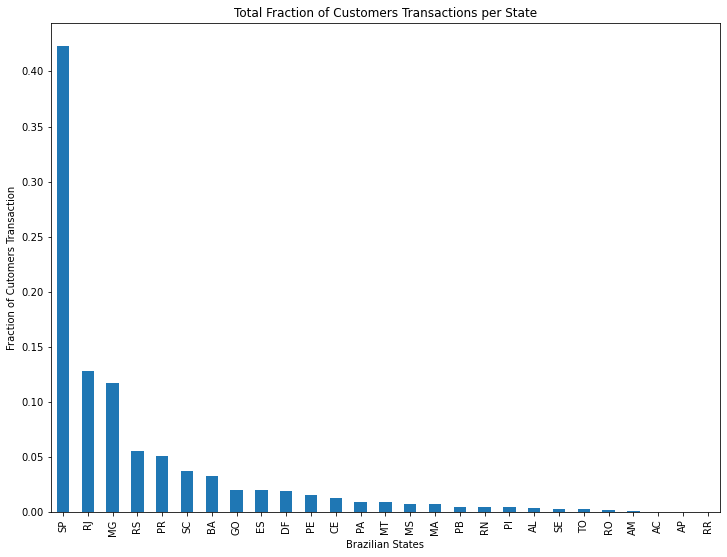

In [344]:
plt.figure(figsize=(12,9))
full_transaction['customer_state'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Brazilian States')
plt.ylabel('Fraction of Cutomers Transaction')
plt.title('Total Fraction of Customers Transactions per State')
plt.show()

Interesting to note that `SP` accounts for `over 40%` of all customer transactions

For the `customer states` we will only classify states that account for over `10%` of the data, these are `SP`, `RJ` and `MG` others will be lumped as one cluster

In [345]:
full_transaction['customer_state_encode'] = full_transaction['customer_state'].map({'SP':1, 'RJ':2, 'MG':3}).fillna(0)

Similarly we will look at the seller states and try to classify them.

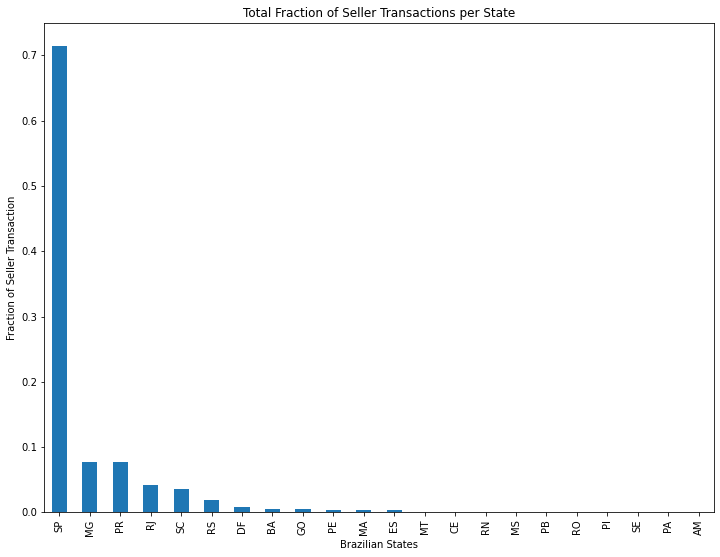

In [346]:
plt.figure(figsize=(12,9))
full_transaction['seller_state'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Brazilian States')
plt.ylabel('Fraction of Seller Transaction')
plt.title('Total Fraction of Seller Transactions per State')
plt.show()

Here there is an imbalance in the seller states, `SP` accounts for `over 70%` of transactions,therefore it safe to group them into two `SP` and the rest. 

In [347]:
full_transaction['seller_state_encode'] = (full_transaction['seller_state'] == 'SP').astype('int')

**Looking at the year `carrier_Year` columns**

We already created a lot of features from our date columns but we want to look 

In [348]:
full_transaction['carrier_Year'].value_counts(normalize=True)

2018    0.554040
2017    0.443068
2016    0.002892
Name: carrier_Year, dtype: float64

From previous EDA, we know that:

- There are alot of gaps and noise in the `2016` data (Oct-Dec) and its just `0.3%` of the data so we should be fine. Therefore we will exclude 2016 data from the data set. 

- We will also be removing errors in delivery days,as there are some negative delivery days, this is probably due to entry errors

In [349]:
new_data = full_transaction[(full_transaction['carrier_Year'] >2016)&(full_transaction['delivery_time_days']>0)]

**Another imbalance noticed from our dataset is the delivery days (our target), that is causing serious outliers in our data.**

we can see in the histogram below

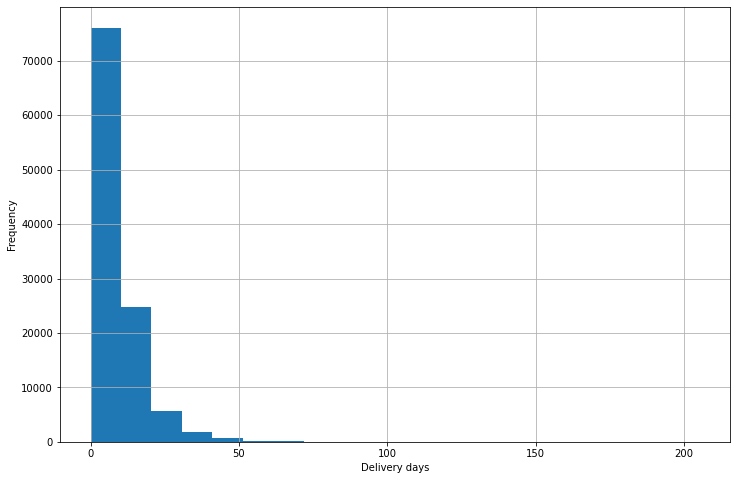

In [350]:
plt.figure(figsize=(12,8))
new_data['delivery_time_days'].hist(bins=20)
plt.xlabel('Delivery days')
plt.ylabel('Frequency')
plt.show()

It can be seen that

- There are delivery days up to `~200` in our dataset

- There are some deliveries that appears to have been delivered before the logistic partner pick them up 

- Also is discovered before most deliveries are done between `10-25` days


From research last mile delivery companies such as Olist that run amazon kind of model, have delivery windows for different types of orders based on different conditions.


The best way to sort this imbalance is bin the target column `delivery_time_days` into different delivery windows, for more efficient experience since one does not control the third party delivery company or the sellers.


Logically we will break the deliveries into 

1. Within 3 days
2. Within 7 days(1 week)
3. more than a week

A good way to achieve this is to break the data into quantiles, using `pd.qcut`, below is a good window to choose from

In [351]:
new_data['delivery_time_days'].quantile([0.20,0.5])

0.2    3.2296
0.5    7.0600
Name: delivery_time_days, dtype: float64

Now breaking down to various `delivery_window`

In [352]:
new_data['delivery_window'] = pd.qcut(new_data['delivery_time_days'],q=[0,.20, .5, 1],
                            labels=False,
                            precision=0)

Now splitting data into target and features

In [353]:
X_full = new_data.drop('delivery_window',axis=1).copy() 

y= new_data['delivery_window'] #target

Next we need to select our features carefully, from our research the features we expect to correlate 3 broad factors

- `Customer` (location, apartment_type, customer_type etc)


- `Order`(order_size, order_weight, purchase_date, approval/pickup_date) 


- `External Factors`(temperature, holiday, traffic, Day of week, season etc).

We will start by selecting features related to the above and selectively drop or add features based on performance of our model on validation data

In [354]:
features = ['product_weight_g','carrier_Week','price','carrier_DofW','freight_value','order_item_id',
       'product_volume_cm3', 'distance_in_km','customer_state_encode','seller_state_encode','seller_city','customer_city','Holiday']

Now taking a look at the distribution of the numerical features from the data

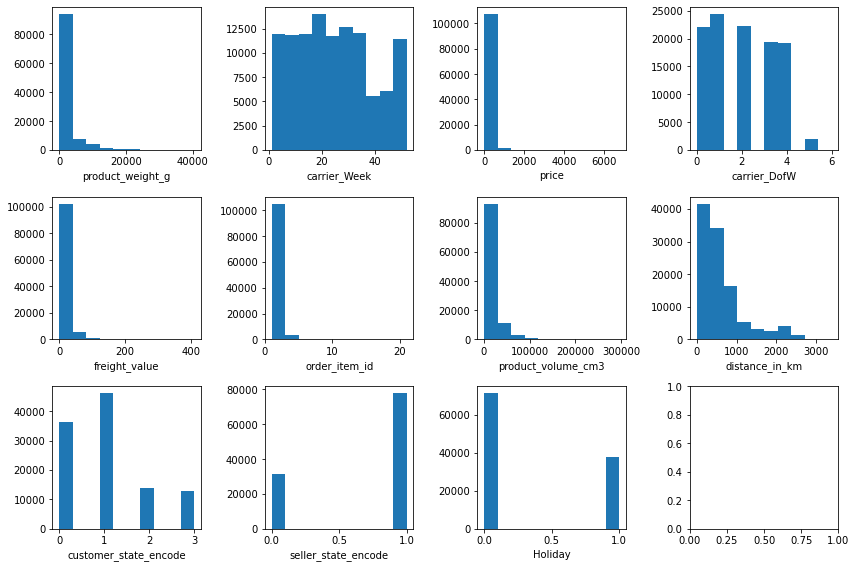

In [355]:
num_col = [col for col in X_full[features].columns if X_full[col].dtypes in ['int64','float64']]

fig,axs = plt.subplots(3,4,figsize=(12, 8))

for i,col in enumerate(num_col):
    
    plt.subplot(3,4, i+1)
    plt.hist(X_full[col])
    plt.xlabel(col)

plt.tight_layout()
plt.show()

It can be seen that most of the numerical features here are right skewed, especially the columns:

- product_weight_g
- price
- freight_value
- order_item_id
- product_volum_cm3
- distance_in_km

Next we apply log transformation to them we may get something better

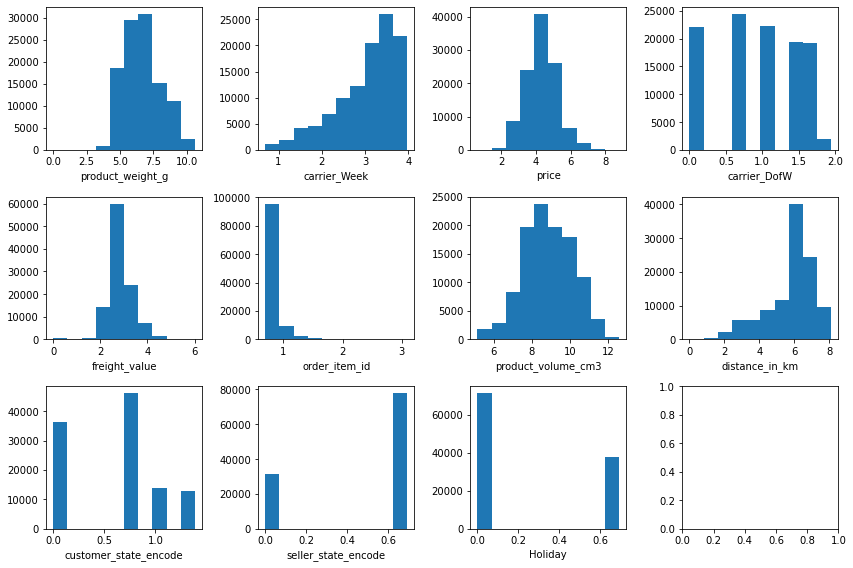

In [356]:
num_col = [col for col in X_full[features].columns if X_full[col].dtypes in ['int64','float64']]

fig,axs = plt.subplots(3,4,figsize=(12, 8))

for i,col in enumerate(num_col):
    
    plt.subplot(3,4, i+1)
    plt.hist(np.log1p(X_full[col]))
    plt.xlabel(col)

plt.tight_layout()
plt.show()

The following columns are responsive to log transformation

- product_weight_g
- price
- freight value
- product_volume_cm3


Other columns such as `carrier_week, carrier_DofW, order_item_id,Holiday, customer_state_encode, seller_state_encode`, are categorical features so we are not concerned with them

However, we will have to bin the `distance` column for better results

Next we apply this to the data fist log transformation to the responsive columns and then bining `distance` with `pd.qcut`

In [357]:
log_transform = ['product_weight_g','price','freight_value','product_volume_cm3']

for c in log_transform:
    X_full[c] = np.log1p(X_full[c])

**Distance Transformation**

Exploring the distance column, with 25th,50th and 75th percentile

In [358]:
X_full['distance_in_km'].quantile([0.25,0.5,0.75])

0.25    183.676588
0.50    431.582784
0.75    790.176394
Name: distance_in_km, dtype: float64

Breaking down the `distance` into 4 below

In [359]:
X_full['distance_category'] = pd.qcut(X_full['distance_in_km'],q=[0,.25,.5,.75, 1],
                            labels=False,
                            precision=0)

**Location Feature Engineering**

Another location feature important to consider is orders that happen in the same state as the seller, it is rational that same state order will be delivered faster that inter state orders.

checking how they perform

In [360]:
y[X_full['seller_state'] == X_full['customer_state']].value_counts(normalize=True)

0    0.471370
1    0.347646
2    0.180984
Name: delivery_window, dtype: float64

Our theory appears to be right, so we add it as column

In [361]:
X_full['same_state'] = (X_full['seller_state'] == X_full['customer_state']).astype('int')

---

**Check point: Saving clean data for final modeling**

In [362]:
clean_data = X_full.copy()

clean_data['delivery_window'] = y

clean_data.to_csv('clean_data/clean_data.csv', header=True)

## Modelling

Now taking a stock of the features again

In [382]:
features = ['product_weight_g','carrier_Week','price','carrier_DofW','freight_value','order_item_id',
       'product_volume_cm3', 'distance_category','same_state','customer_state_encode','seller_state_encode','Holiday']

we will not be adding the cities in our features because  the `same_state` and `distance_category` should help us infer the city column.

In [383]:
#setting feature dataframe
X = X_full[features]

We can start by spliting data into train, validation and test data sets

In [384]:
#split to full_training and test sets
X_train_full,X_test,y_train_full,y_test = train_test_split(X,y,test_size=0.10,random_state=42,stratify=y)

#split to training and validation sets
X_train,X_val,y_train,y_val = train_test_split(X_train_full,y_train_full,test_size=0.10,random_state=42,stratify=y_train_full)

Next up **Scaling** most of our data are not in the same range hence the need to scale our data, 

we will be using a `MinMax Scalar`, to preserve the shape of the original distribution. It doesn’t meaningfully change the information embedded in the original data.

In [385]:
min_max = MinMaxScaler()
X_train_scaled = min_max.fit_transform(X_train)
X_val_scaled = min_max.transform(X_val)

since our business question is setup as a classification problem, we will use classification models such as `Logistic regression`


### Logistic regression

First we run a basic `Logistic Regression` on the data, this will serve as out base model

In [386]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()

log_model.fit(X_train,y_train)
log_model.score(X_val,y_val)

0.6450366151342555

`64.5%` is a good starting score for our model but we need to tune the model and see how far we can get with the model.

Now lets tune the `C` hyperparameter on the validation datasets, by varying C-values from 0.001 to 10

In [47]:
train_score = []
val_score = []

for c in [0.001,0.01,0.1,1,10]:
    
    log_reg = LogisticRegression(C=c)
    log_reg.fit(X_train_scaled, y_train)

    val_score.append(log_reg.score(X_val_scaled,y_val))
    train_score.append(log_reg.score(X_train_scaled, y_train))
    
    print(f'Progress: C = {c}',end="\r")

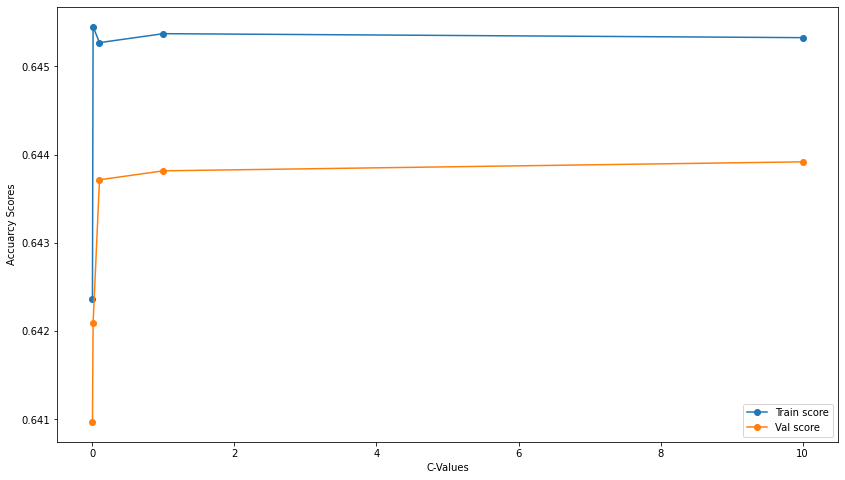

In [48]:
plt.figure(figsize=(14,8))
plt.plot([0.001,0.01,0.1,1,10],train_score,label='Train score',marker='o')
plt.plot([0.001,0.01,0.1,1,10],val_score,label='Val score',marker='o')
plt.xlabel('C-Values')
plt.title('C-values vs Accuracy Scores')
plt.ylabel('Accuarcy Scores')
plt.legend()
plt.show()

The best `C` is `0.1` it is after this point the model stops improving with accuarcy score of `~64%`

Next running the full model on the test set and evaluating the performance of the model

In [49]:
min_max = MinMaxScaler()
X_full_train_scaled = min_max.fit_transform(X_train_full)
X_test_scaled = min_max.transform(X_test)

log_reg = LogisticRegression(C=0.1)
log_reg.fit(X_full_train_scaled, y_train_full)

log_score = round(log_reg.score(X_test_scaled,y_test)*100,2)

print(f'The accuracy score on test set is: {log_score}%')

The accuracy score on test set is: 64.22%


logistic regression accuracy score of `64%` for a multiclass problem is not bad.

**Now lets evaluate further and see how our confusion matrix looks like**

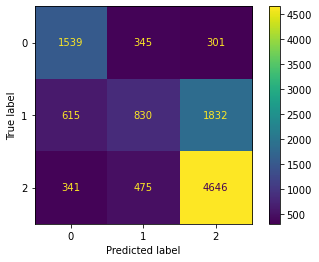

In [50]:
y_pred = log_reg.predict(X_test_scaled)
conf_matrix = confusion_matrix(y_test,y_pred)
# the function expects the estimator, inputs and target as parameters
plot_confusion_matrix(log_reg, X_test_scaled, y_test);

From the confusion matrix, we predicted `1832` as to be delivered after a week but was delivered within a week, similar with 3-day delivery window.

Our appears to be performing well on delivery window `0` and `2` but woefully on `1`

let's see the `precision` and `recall`

In [51]:
log_y_pred = log_reg.predict(X_test_scaled)
report_initial = classification_report(y_test, log_y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.62      0.70      0.66      2185
           1       0.50      0.25      0.34      3277
           2       0.69      0.85      0.76      5462

    accuracy                           0.64     10924
   macro avg       0.60      0.60      0.58     10924
weighted avg       0.62      0.64      0.61     10924



Our logistic regression model is not doing well, as it is mispredicting mostly deliveries that are greater than `3-days` to `7-days`. Our recall values, which is our focus here is very bad. Probably we are getting this results because of the multiclass system we have set and `Logistic regression` is not powerful enough to detect this.

Let's take a look at the items misclassified in this category

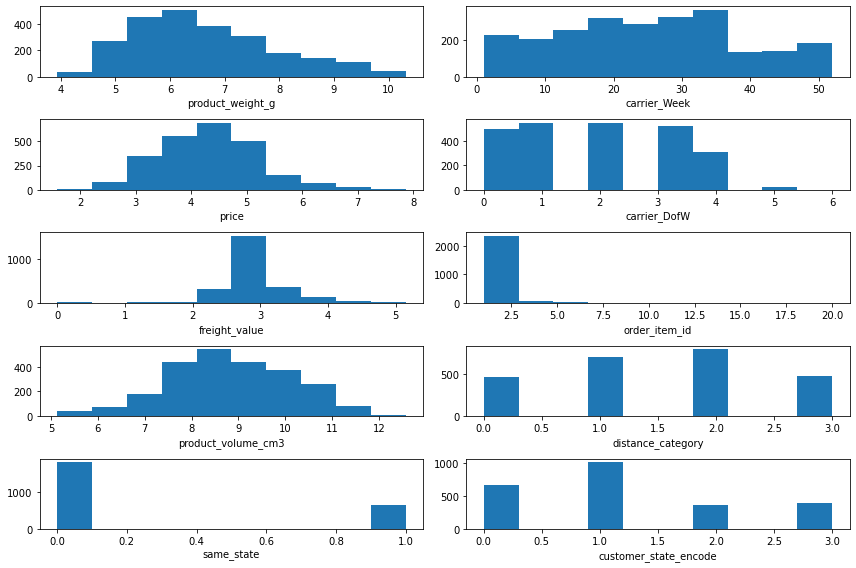

In [52]:
sub_X_data = X_test[(y_test==1)&(y_pred!=y_test)].iloc[:,:10]
num_col = sub_X_data .columns

fig,axs = plt.subplots(5,5,figsize=(12, 8))

for i,col in enumerate(num_col):
    
    plt.subplot(5,2, i+1)
    plt.hist(sub_X_data[col])
    plt.xlabel(col)

plt.tight_layout()
plt.show()

There is no inherent pattern the misclassified items, as the distribution is similar to the general pattern observed in our EDA, probably the Logistic model is not strong enough to detect the patterns.

Next we will try a powerful library with variety of models to choose from

### Pycaret


`PyCaret` is an open-source, **low-code machine learning library in Python** that aims to **reduce the cycle time from hypothesis to insights**. It is well suited for seasoned data scientists who want to **increase the productivity** of their ML experiments by using PyCaret in their workflows or for citizen data scientists and those new to data science with little or no background in coding.

We will run setup a pycaret model for this problem using just the training dataset, this is help select the best set of models to use intead of trying different types of models looking for the best. pycaret will help us run 14 types of models and compare them for the best.

For this problem we will need to we will have to create a dataFrame for the problem, because input to `pycaret` has to be a dataframe. We will be using only the train set since the goal is just to identify the best models

In [525]:
train_data = X_train.copy()

train_data['delivery_window'] = y_train

train_data.to_csv('clean_data/train.csv', header=True)


Due to dependencies on this environment and PC, the pycaret was run on [Google Colab](https://colab.research.google.com/drive/1wAUrjvdhQ3wIoJsg5ZmEBEdb87s1pQDq#scrollTo=a_Av-SBY9DcD)

Results Pycaret comparison table below

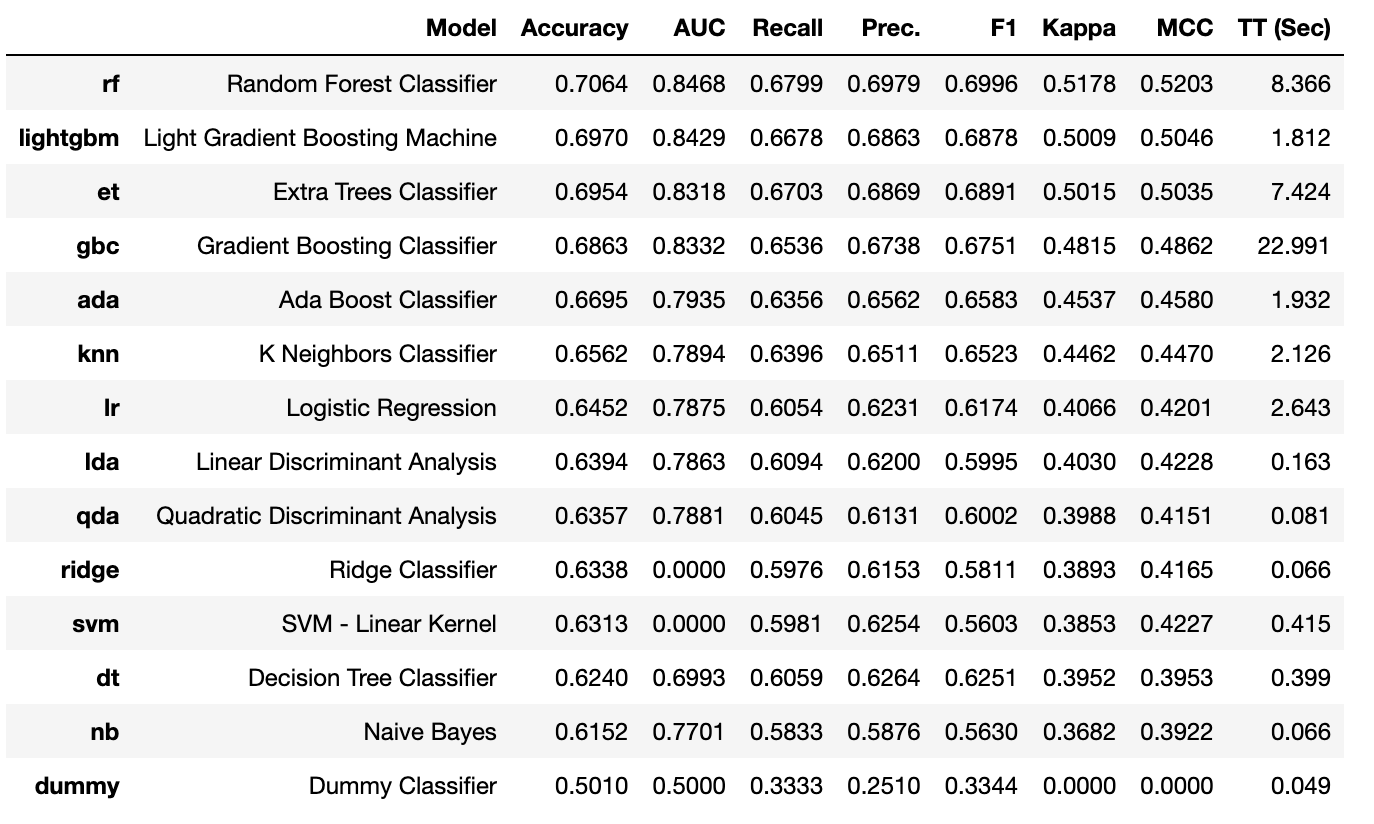

We can see from the table that the best performing models are either `Random Forest` or boosting models such as `Light Gradient Boost`, `Extra Tree Classifier`, `Gradient Boosting Classifier` etc. Instead of using all the boosting models asides focus will be placed on `XGBoost` which is a more powerful gradient boosting model.

The above table only helps to select models to place emphasis on when hypertuning, this does not mean the accuracies scores will be the same but it will be in that range and there is a potential gain to tuning the hyperparameter instead of spreading focus thin on variety of models.

Hypertuning will be done for both `Random Forest` and `XGBoost`

### Random Forest Classifier

A [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Since we know that some kind of hyperparameter tuning is needed, we will go ahead to the tuning stage. The random forest model will be tuned on the validation set.

We will be start by tuning the hyperameter `max_depth` and `min_samples_leaf` using first principles, collecting the accuracy scores for each combination of the above parameters

The search space for  `max_depth` will range from 1-20 while `min_samples_leaf` will go from 1-6

In [53]:
from sklearn.ensemble import RandomForestClassifier
df_scores = []
val_scores = []
train_scores = []
for i in range(1,20):
    for k in range(1,6):
        my_random_forest = RandomForestClassifier(max_depth=i,min_samples_leaf = k)
        my_random_forest.fit(X_train_scaled, y_train)
        val_score = my_random_forest.score(X_val_scaled,y_val)
        train_score = my_random_forest.score(X_train_scaled, y_train)
        
        df_scores.append((i,k,train_score,val_score))
    
    print(f'Progress: max_depth = {i}, min_samples_leaf = {k}',end="\r")

Generatting a table of the accuracy scores for trianing and validation sets, then ploting for each combination

In [54]:
scores_df = pd.DataFrame(df_scores,columns= ['max_dept','min_sample_leaf',
                                             'train_score','val_score']).sort_values(by='val_score',ascending=False)

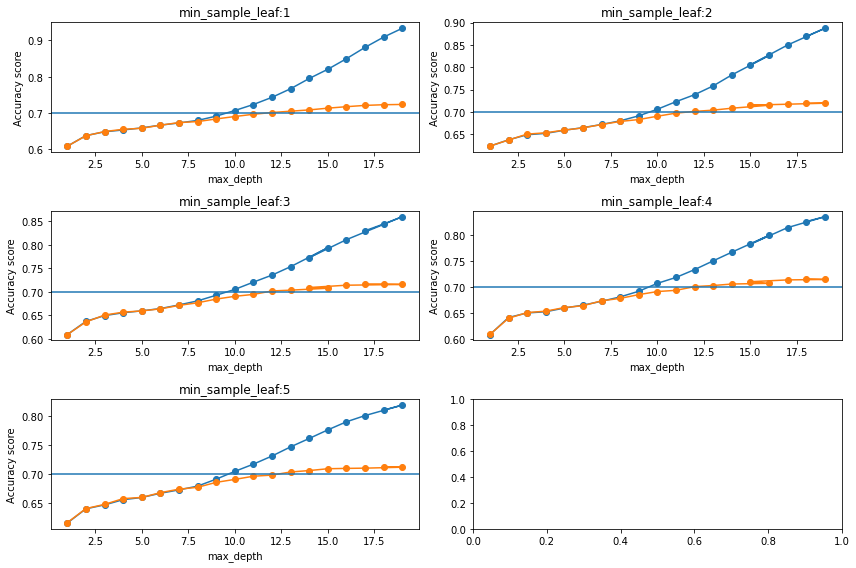

In [55]:
fig,axs = plt.subplots(3,2,figsize=(12, 8))
for i,k in enumerate(range(1,6)):
    
    min_df = scores_df[scores_df['min_sample_leaf'] == k]
    plt.subplot(3,2, i+1)
    plt.plot(min_df['max_dept'],min_df['train_score'],label='Train score',marker='o')
    plt.plot(min_df['max_dept'],min_df['val_score'],label='Val score',marker='o')
    plt.axhline(0.7) # added this for better visuals
    plt.xlabel('max_depth')
    plt.ylabel('Accuracy score')
    plt.title(f'min_sample_leaf:{k}')
plt.tight_layout()
plt.show()

Taking a look at the plots, we will go with `min_sample_leaf = 2` and `max_depth = 12`, beacause

- the plot clearly shows when the model stop learning the validation sets

- it is at the stated points that the model clearly starts to overfits

In [63]:
my_random_forest = RandomForestClassifier(max_depth=13,min_samples_leaf=2)
my_random_forest.fit(X_full_train_scaled, y_train_full)
random_score = round(my_random_forest.score(X_test_scaled,y_test)*100,2)

print(f'The accuracy score on test set is: {random_score}%')

The accuracy score on test set is: 70.04%


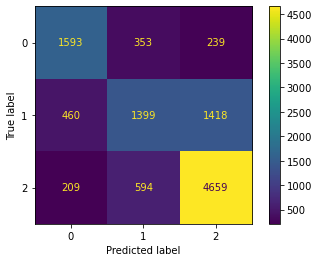

In [64]:
# the function expects the estimator, inputs and target as parameters
plot_confusion_matrix(my_random_forest, X_test_scaled, y_test);

In [65]:
rand_y_pred = my_random_forest.predict(X_test_scaled)
report_initial = classification_report(y_test, rand_y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      2185
           1       0.60      0.43      0.50      3277
           2       0.74      0.85      0.79      5462

    accuracy                           0.70     10924
   macro avg       0.68      0.67      0.67     10924
weighted avg       0.69      0.70      0.69     10924



Our `RandomForest` model is still performing bad on category `1` with recall with a recall of `43%`. It performs better overall with accuracy score of `70.04%`


Next we try to using a more powerful model, a gradient boosting model to be exact and see the perfomance

### XGBoost

[XGBoost](https://xgboost.readthedocs.io/en/stable/) is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. 


For this model, instead of tuning in first priciples, I will use an hypertuning package called [`Optuna`](https://optuna.org/), this will tunig all the required parameters and output the best values for this parameters.

The tuning will go through **`20 iterations` so it will take some time to run** , to avoid the time taken to run, the hypertuned paramaeters can be gotten two cells below

In [67]:
def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBClassifier(**xgb_params)
    xgb.fit(X_train_scaled, y_train)
    return xgb.score(X_val_scaled,y_val)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

[I 2021-11-26 14:08:42,316] A new study created in memory with name: no-name-79b1e2d7-3dee-42fb-886c-6920d3ee4745
[I 2021-11-26 14:10:44,552] Trial 0 finished with value: 0.6835842148087876 and parameters: {'max_depth': 4, 'learning_rate': 0.0027249356619070595, 'n_estimators': 3456, 'min_child_weight': 7, 'colsample_bytree': 0.2858414590773207, 'subsample': 0.3348784924505155, 'reg_alpha': 0.0018658922661432572, 'reg_lambda': 12.957520629362392}. Best is trial 0 with value: 0.6835842148087876.
[I 2021-11-26 14:13:13,267] Trial 1 finished with value: 0.6298820179007323 and parameters: {'max_depth': 5, 'learning_rate': 0.00013516815052549877, 'n_estimators': 3887, 'min_child_weight': 3, 'colsample_bytree': 0.24540786858587388, 'subsample': 0.5630852215641717, 'reg_alpha': 17.100908344117645, 'reg_lambda': 4.667933963259725}. Best is trial 0 with value: 0.6835842148087876.
[I 2021-11-26 14:19:03,674] Trial 2 finished with value: 0.709113100081367 and parameters: {'max_depth': 7, 'learnin

**Tuned parameters below:**

In [80]:
tuned_xgb_params = {'max_depth': 8,
 'learning_rate': 0.03286227389731753,
 'n_estimators': 2744,
 'min_child_weight': 3,
 'colsample_bytree': 0.7310402744020237,
 'subsample': 0.7949429166896618,
 'reg_alpha': 1.4819398025141877,
 'reg_lambda': 0.0001069849518239625}

Next we run the tuned model parameters on the full training set..

In [68]:
XGB_model = XGBClassifier(**xgb_params)
XGB_model.fit(X_full_train_scaled, y_train_full)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7310402744020237, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.03286227389731753, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=2744, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0,
              reg_alpha=1.4819398025141877, reg_lambda=0.0001069849518239625,
              scale_pos_weight=None, subsample=0.7949429166896618,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [69]:
XGB_score  = round(XGB_model.score(X_test_scaled,y_test)*100,2)

print(f'The accuracy score on test set is: {XGB_score}%')

The accuracy score on test set is: 72.68%


`72.68%` This is a very good score 

Let's Check the confusion matrix

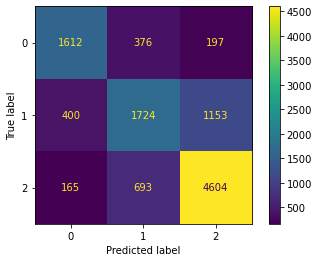

In [70]:
# the function expects the estimator, inputs and target as parameters
plot_confusion_matrix(XGB_model, X_test_scaled, y_test);

In [71]:
XGB_y_pred = XGB_model.predict(X_test_scaled)
report_initial = classification_report(y_test, XGB_y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      2185
           1       0.62      0.53      0.57      3277
           2       0.77      0.84      0.81      5462

    accuracy                           0.73     10924
   macro avg       0.71      0.70      0.70     10924
weighted avg       0.72      0.73      0.72     10924



**XGBoost** is really doing better than others in classifiying the 2nd category, with a recall of `53%` and an accuracy of `72.68%`

Our model accuracies so far:

- **`Logistic Regression`**: `64.22%`
- **`Random Forest`**: `70.04%`
- **`XGBoost`**: `72.68%`

### Model Stacking

Since both our `XGBoost` and `Random Forest` are doing really great overall we can check how they both perform regarding in category 1.

In [72]:
check_pred = pd.DataFrame({'y_test':y_test,'log_pred':log_y_pred,'rand_pred':rand_y_pred,'XGB_pred':XGB_y_pred})
check_pred.head()

y_test  log_pred  rand_pred  XGB_pred
5381        2         2          2         2
81856       1         2          1         1
63610       2         2          2         2
72824       1         2          1         1
74590       1         2          1         1

Let's take a look at how the models performed on category `1`, that is case where `XGBoost` classsified correctly and `Random forest` didn't and vice versa

In [76]:
print('Cases where XGboost predicted correctly better than Random forest:')

print(len(check_pred[(check_pred['y_test']==1) & (check_pred['rand_pred']!=1) & (check_pred['XGB_pred']==1)]))


print('Cases where Random forest predicted correctly better than XGboost:')

print(len(check_pred[(check_pred['y_test']==1) & (check_pred['rand_pred']==1) & (check_pred['XGB_pred']!=1)]))

Cases where XGboost predicted correctly better than Random forest:
531
Cases where Random forest predicted correctly better than XGboost:
206


Appears `XGboost` was better at identifying underlying patterns in the data, we could esily gain calssify better `206` more data point if they can correct each other


What if we could combine the models in such a way that the mistakes of one is corrected by the other?

That is where `Model Stacking` comes into play, 

We will be stacking both the `Random Forest` and `XGBoost` models together using the `StackClassifier` Package then estimating the result with a `Logistic Regression`

In [81]:
# makes sure we all get the same results
np.random.seed(1)

# We instantiate the base models, along with their names
base_models = [('Random_Forest', RandomForestClassifier(max_depth=13,min_samples_leaf=2)),
               ('XGB', XGBClassifier(**xgb_params))]


# building the stacked model
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=(LogisticRegression(C=0.1)))

stacked_model.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('Random_Forest',
                                RandomForestClassifier(max_depth=13,
                                                       min_samples_leaf=2)),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7310402744020237,
                                              gamma=None, gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=0.03286227389731753,
                                              max_d...epth=8,
                                              min_child_weight=3, missing=nan,
                            

Trying the model on the test data set

In [85]:
stacked_score = round(stacked_model.score(X_test_scaled,y_test)*100,2)

print(f'The accuracy score on test set is: {stacked_score}%')

The accuracy score on test set is: 72.6%


There is almost no difference in the accuracy score of a `Stacked` and `XGBoost` model

Checking the classification report

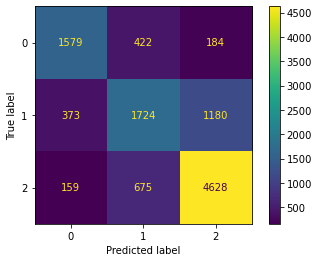

In [86]:
# the function expects the estimator, inputs and target as parameters
plot_confusion_matrix(stacked_model, X_test_scaled, y_test);

In [87]:
stacked_y_pred = stacked_model.predict(X_test_scaled)
report_initial = classification_report(y_test, stacked_y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.75      0.72      0.74      2185
           1       0.61      0.53      0.57      3277
           2       0.77      0.85      0.81      5462

    accuracy                           0.73     10924
   macro avg       0.71      0.70      0.70     10924
weighted avg       0.72      0.73      0.72     10924



Similarly the recall for category `1`, is similar to that of `XGBoost`, there appears to be no significant difference between the two models

For the next model `Neural Networks` will be looked. 

### Neural Network

For the `Neural Network Architeture` to be used, a series of possible options will be tuned over a considerable number of epochs using `Optuna`. this will help in the selection of the best architecture and this will we use to fit our model. Existing tunig network was here was leveraged on [here](https://linuxtut.com/en/4e42b2bb6ab467ef2631/)

Steps:

1. Tune neural network to get best Archecture to be used on data 



2. Create neural network model using tuned archecture



3. Predict on test set, accuracy scores and classification report

In [506]:
def create_model(activation, num_hidden_layer, num_hidden_unit):
    
    '''
    This fuction creates a model using the a wide range of hiden layers
    Input: activation - various posible activation functions
    Input: num_hidden_layer - number of hidden layer
    Input: num_hidden_unit - number of nodes in each layer
    Ouput: Model
    
    '''
    inputs = Input(shape=(X_train.shape[1],))
    model = inputs
    for i in range(1,num_hidden_layer):
        model = Dense(num_hidden_unit, activation=activation,)(model)
        
        
    model = Dense(3, activation="softmax")(model)
    model = Model(inputs, model)

    return model

In [502]:
def objective(trial):
    
    '''
    This function help tuning various parameters in a Neural Network 
    
    '''
    K.clear_session()
    
    # creating various options for activations and optimizers to be tuned on
    activation = trial.suggest_categorical('activation',['relu','tanh','linear'])
    optimizer = trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd'])

    # range of nodes and hidden layer to be tuned on
    num_hidden_layer = trial.suggest_int('num_hidden_layer',1,5,1)
    num_hidden_unit = trial.suggest_int('num_hidden_unit',10,100,10)
    

    
    # iterating through various learning rate for each optimizer
    learning_rate = trial.suggest_loguniform('learning_rate', 0.00001,0.1)
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    elif optimizer =='rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer =='sgd':
        optimizer = SGD(learning_rate=learning_rate)
    
    
    
    #creating model
    model = create_model(activation, num_hidden_layer, num_hidden_unit)
    model_list.append(model)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc', 'sparse_categorical_accuracy'],)
    
    
    # fitting model
    es = EarlyStopping(monitor='val_acc', patience=50)
    history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=10000,batch_size = 20000, verbose=1, callbacks=[es])
    
    
    # recording results
    history_list.append(history)
    
    val_acc = np.array(history.history['val_acc'])
    
    return val_acc[-1]

In [503]:
# Hypertuning with Optuna

model_list=[]
history_list=[]
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2021-12-05 00:46:16,705] A new study created in memory with name: no-name-dc45366b-1f4a-461a-babc-9d763162aa4d


Epoch 1/10000
5/5 [==============================] - 0s 27ms/step - loss: 1.1626 - acc: 0.3127 - sparse_categorical_accuracy: 0.3127 - val_loss: 1.1682 - val_acc: 0.3148 - val_sparse_categorical_accuracy: 0.3148
Epoch 2/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.1603 - acc: 0.3193 - sparse_categorical_accuracy: 0.3193 - val_loss: 1.1658 - val_acc: 0.3219 - val_sparse_categorical_accuracy: 0.3219
Epoch 3/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.1579 - acc: 0.3265 - sparse_categorical_accuracy: 0.3265 - val_loss: 1.1635 - val_acc: 0.3283 - val_sparse_categorical_accuracy: 0.3283
Epoch 4/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.1556 - acc: 0.3335 - sparse_categorical_accuracy: 0.3335 - val_loss: 1.1611 - val_acc: 0.3358 - val_sparse_categorical_accuracy: 0.3358
Epoch 5/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.1533 - acc: 0.3403 - sparse_categorical_accuracy: 0.3403 - val_loss: 1.1589 

5/5 [==============================] - 0s 9ms/step - loss: 1.0978 - acc: 0.4764 - sparse_categorical_accuracy: 0.4764 - val_loss: 1.1036 - val_acc: 0.4789 - val_sparse_categorical_accuracy: 0.4789
Epoch 40/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0967 - acc: 0.4781 - sparse_categorical_accuracy: 0.4781 - val_loss: 1.1025 - val_acc: 0.4812 - val_sparse_categorical_accuracy: 0.4812
Epoch 41/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0956 - acc: 0.4798 - sparse_categorical_accuracy: 0.4798 - val_loss: 1.1014 - val_acc: 0.4830 - val_sparse_categorical_accuracy: 0.4830
Epoch 42/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0945 - acc: 0.4816 - sparse_categorical_accuracy: 0.4816 - val_loss: 1.1003 - val_acc: 0.4850 - val_sparse_categorical_accuracy: 0.4850
Epoch 43/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0934 - acc: 0.4837 - sparse_categorical_accuracy: 0.4837 - val_loss: 1.0992 - val_acc: 0.4

Epoch 78/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0634 - acc: 0.5080 - sparse_categorical_accuracy: 0.5080 - val_loss: 1.0692 - val_acc: 0.5085 - val_sparse_categorical_accuracy: 0.5085
Epoch 79/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0627 - acc: 0.5082 - sparse_categorical_accuracy: 0.5082 - val_loss: 1.0685 - val_acc: 0.5087 - val_sparse_categorical_accuracy: 0.5087
Epoch 80/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0620 - acc: 0.5083 - sparse_categorical_accuracy: 0.5083 - val_loss: 1.0678 - val_acc: 0.5092 - val_sparse_categorical_accuracy: 0.5092
Epoch 81/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0613 - acc: 0.5084 - sparse_categorical_accuracy: 0.5084 - val_loss: 1.0671 - val_acc: 0.5098 - val_sparse_categorical_accuracy: 0.5098
Epoch 82/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.0607 - acc: 0.5086 - sparse_categorical_accuracy: 0.5086 - val_loss: 1.0664

5/5 [==============================] - 0s 9ms/step - loss: 1.0392 - acc: 0.5126 - sparse_categorical_accuracy: 0.5126 - val_loss: 1.0449 - val_acc: 0.5124 - val_sparse_categorical_accuracy: 0.5124
Epoch 117/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0386 - acc: 0.5127 - sparse_categorical_accuracy: 0.5127 - val_loss: 1.0443 - val_acc: 0.5125 - val_sparse_categorical_accuracy: 0.5125
Epoch 118/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0380 - acc: 0.5128 - sparse_categorical_accuracy: 0.5128 - val_loss: 1.0437 - val_acc: 0.5124 - val_sparse_categorical_accuracy: 0.5124
Epoch 119/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0374 - acc: 0.5128 - sparse_categorical_accuracy: 0.5128 - val_loss: 1.0431 - val_acc: 0.5123 - val_sparse_categorical_accuracy: 0.5123
Epoch 120/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.0368 - acc: 0.5129 - sparse_categorical_accuracy: 0.5129 - val_loss: 1.0425 - val_acc

5/5 [==============================] - 0s 8ms/step - loss: 1.0180 - acc: 0.5146 - sparse_categorical_accuracy: 0.5146 - val_loss: 1.0235 - val_acc: 0.5131 - val_sparse_categorical_accuracy: 0.5131
Epoch 155/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0174 - acc: 0.5146 - sparse_categorical_accuracy: 0.5146 - val_loss: 1.0230 - val_acc: 0.5132 - val_sparse_categorical_accuracy: 0.5132
Epoch 156/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0169 - acc: 0.5146 - sparse_categorical_accuracy: 0.5146 - val_loss: 1.0225 - val_acc: 0.5132 - val_sparse_categorical_accuracy: 0.5132
Epoch 157/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0164 - acc: 0.5146 - sparse_categorical_accuracy: 0.5146 - val_loss: 1.0219 - val_acc: 0.5132 - val_sparse_categorical_accuracy: 0.5132
Epoch 158/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.0159 - acc: 0.5147 - sparse_categorical_accuracy: 0.5147 - val_loss: 1.0214 - val_acc:

5/5 [==============================] - 0s 9ms/step - loss: 0.9987 - acc: 0.5155 - sparse_categorical_accuracy: 0.5155 - val_loss: 1.0041 - val_acc: 0.5139 - val_sparse_categorical_accuracy: 0.5139
Epoch 193/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.9982 - acc: 0.5154 - sparse_categorical_accuracy: 0.5154 - val_loss: 1.0036 - val_acc: 0.5139 - val_sparse_categorical_accuracy: 0.5139
Epoch 194/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.9977 - acc: 0.5154 - sparse_categorical_accuracy: 0.5154 - val_loss: 1.0031 - val_acc: 0.5139 - val_sparse_categorical_accuracy: 0.5139
Epoch 195/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9972 - acc: 0.5155 - sparse_categorical_accuracy: 0.5155 - val_loss: 1.0026 - val_acc: 0.5142 - val_sparse_categorical_accuracy: 0.5142
Epoch 196/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9967 - acc: 0.5155 - sparse_categorical_accuracy: 0.5155 - val_loss: 1.0021 - val_acc: 

5/5 [==============================] - 0s 9ms/step - loss: 0.9810 - acc: 0.5172 - sparse_categorical_accuracy: 0.5172 - val_loss: 0.9862 - val_acc: 0.5154 - val_sparse_categorical_accuracy: 0.5154
Epoch 231/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9805 - acc: 0.5174 - sparse_categorical_accuracy: 0.5174 - val_loss: 0.9857 - val_acc: 0.5153 - val_sparse_categorical_accuracy: 0.5153
Epoch 232/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9801 - acc: 0.5174 - sparse_categorical_accuracy: 0.5174 - val_loss: 0.9853 - val_acc: 0.5153 - val_sparse_categorical_accuracy: 0.5153
Epoch 233/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9796 - acc: 0.5175 - sparse_categorical_accuracy: 0.5175 - val_loss: 0.9849 - val_acc: 0.5151 - val_sparse_categorical_accuracy: 0.5151
Epoch 234/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.9792 - acc: 0.5176 - sparse_categorical_accuracy: 0.5176 - val_loss: 0.9844 - val_acc:

5/5 [==============================] - 0s 8ms/step - loss: 0.9646 - acc: 0.5206 - sparse_categorical_accuracy: 0.5206 - val_loss: 0.9697 - val_acc: 0.5185 - val_sparse_categorical_accuracy: 0.5185
Epoch 269/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.9642 - acc: 0.5208 - sparse_categorical_accuracy: 0.5208 - val_loss: 0.9693 - val_acc: 0.5187 - val_sparse_categorical_accuracy: 0.5187
Epoch 270/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.9638 - acc: 0.5210 - sparse_categorical_accuracy: 0.5210 - val_loss: 0.9689 - val_acc: 0.5187 - val_sparse_categorical_accuracy: 0.5187
Epoch 271/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.9634 - acc: 0.5211 - sparse_categorical_accuracy: 0.5211 - val_loss: 0.9684 - val_acc: 0.5189 - val_sparse_categorical_accuracy: 0.5189
Epoch 272/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9630 - acc: 0.5212 - sparse_categorical_accuracy: 0.5212 - val_loss: 0.9680 - val_acc:

5/5 [==============================] - 0s 9ms/step - loss: 0.9496 - acc: 0.5272 - sparse_categorical_accuracy: 0.5272 - val_loss: 0.9544 - val_acc: 0.5242 - val_sparse_categorical_accuracy: 0.5242
Epoch 307/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9492 - acc: 0.5273 - sparse_categorical_accuracy: 0.5273 - val_loss: 0.9541 - val_acc: 0.5242 - val_sparse_categorical_accuracy: 0.5242
Epoch 308/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9489 - acc: 0.5275 - sparse_categorical_accuracy: 0.5275 - val_loss: 0.9537 - val_acc: 0.5244 - val_sparse_categorical_accuracy: 0.5244
Epoch 309/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9485 - acc: 0.5278 - sparse_categorical_accuracy: 0.5278 - val_loss: 0.9533 - val_acc: 0.5240 - val_sparse_categorical_accuracy: 0.5240
Epoch 310/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.9481 - acc: 0.5281 - sparse_categorical_accuracy: 0.5281 - val_loss: 0.9529 - val_acc

5/5 [==============================] - 0s 10ms/step - loss: 0.9358 - acc: 0.5367 - sparse_categorical_accuracy: 0.5367 - val_loss: 0.9404 - val_acc: 0.5309 - val_sparse_categorical_accuracy: 0.5309
Epoch 345/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.9354 - acc: 0.5368 - sparse_categorical_accuracy: 0.5368 - val_loss: 0.9400 - val_acc: 0.5311 - val_sparse_categorical_accuracy: 0.5311
Epoch 346/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9351 - acc: 0.5372 - sparse_categorical_accuracy: 0.5372 - val_loss: 0.9397 - val_acc: 0.5319 - val_sparse_categorical_accuracy: 0.5319
Epoch 347/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.9347 - acc: 0.5373 - sparse_categorical_accuracy: 0.5373 - val_loss: 0.9393 - val_acc: 0.5317 - val_sparse_categorical_accuracy: 0.5317
Epoch 348/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.9344 - acc: 0.5375 - sparse_categorical_accuracy: 0.5375 - val_loss: 0.9390 - val_ac

5/5 [==============================] - 0s 10ms/step - loss: 0.9230 - acc: 0.5473 - sparse_categorical_accuracy: 0.5473 - val_loss: 0.9274 - val_acc: 0.5415 - val_sparse_categorical_accuracy: 0.5415
Epoch 383/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9227 - acc: 0.5476 - sparse_categorical_accuracy: 0.5476 - val_loss: 0.9271 - val_acc: 0.5420 - val_sparse_categorical_accuracy: 0.5420
Epoch 384/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9224 - acc: 0.5478 - sparse_categorical_accuracy: 0.5478 - val_loss: 0.9268 - val_acc: 0.5420 - val_sparse_categorical_accuracy: 0.5420
Epoch 385/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9221 - acc: 0.5482 - sparse_categorical_accuracy: 0.5482 - val_loss: 0.9264 - val_acc: 0.5421 - val_sparse_categorical_accuracy: 0.5421
Epoch 386/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9218 - acc: 0.5485 - sparse_categorical_accuracy: 0.5485 - val_loss: 0.9261 - val_acc

5/5 [==============================] - 0s 11ms/step - loss: 0.9113 - acc: 0.5591 - sparse_categorical_accuracy: 0.5591 - val_loss: 0.9154 - val_acc: 0.5524 - val_sparse_categorical_accuracy: 0.5524
Epoch 421/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9110 - acc: 0.5595 - sparse_categorical_accuracy: 0.5595 - val_loss: 0.9151 - val_acc: 0.5527 - val_sparse_categorical_accuracy: 0.5527
Epoch 422/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9107 - acc: 0.5599 - sparse_categorical_accuracy: 0.5599 - val_loss: 0.9148 - val_acc: 0.5527 - val_sparse_categorical_accuracy: 0.5527
Epoch 423/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9104 - acc: 0.5601 - sparse_categorical_accuracy: 0.5601 - val_loss: 0.9145 - val_acc: 0.5533 - val_sparse_categorical_accuracy: 0.5533
Epoch 424/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9101 - acc: 0.5604 - sparse_categorical_accuracy: 0.5604 - val_loss: 0.9142 - val_ac

5/5 [==============================] - 0s 8ms/step - loss: 0.9006 - acc: 0.5701 - sparse_categorical_accuracy: 0.5701 - val_loss: 0.9044 - val_acc: 0.5662 - val_sparse_categorical_accuracy: 0.5662
Epoch 459/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9003 - acc: 0.5703 - sparse_categorical_accuracy: 0.5703 - val_loss: 0.9041 - val_acc: 0.5664 - val_sparse_categorical_accuracy: 0.5664
Epoch 460/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.9000 - acc: 0.5706 - sparse_categorical_accuracy: 0.5706 - val_loss: 0.9039 - val_acc: 0.5663 - val_sparse_categorical_accuracy: 0.5663
Epoch 461/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.8997 - acc: 0.5708 - sparse_categorical_accuracy: 0.5708 - val_loss: 0.9036 - val_acc: 0.5669 - val_sparse_categorical_accuracy: 0.5669
Epoch 462/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8995 - acc: 0.5711 - sparse_categorical_accuracy: 0.5711 - val_loss: 0.9033 - val_acc:

5/5 [==============================] - 0s 9ms/step - loss: 0.8906 - acc: 0.5811 - sparse_categorical_accuracy: 0.5811 - val_loss: 0.8943 - val_acc: 0.5761 - val_sparse_categorical_accuracy: 0.5761
Epoch 497/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8904 - acc: 0.5814 - sparse_categorical_accuracy: 0.5814 - val_loss: 0.8940 - val_acc: 0.5766 - val_sparse_categorical_accuracy: 0.5766
Epoch 498/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8901 - acc: 0.5816 - sparse_categorical_accuracy: 0.5816 - val_loss: 0.8938 - val_acc: 0.5763 - val_sparse_categorical_accuracy: 0.5763
Epoch 499/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8899 - acc: 0.5819 - sparse_categorical_accuracy: 0.5819 - val_loss: 0.8935 - val_acc: 0.5770 - val_sparse_categorical_accuracy: 0.5770
Epoch 500/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8897 - acc: 0.5821 - sparse_categorical_accuracy: 0.5821 - val_loss: 0.8932 - val_acc

5/5 [==============================] - 0s 8ms/step - loss: 0.8816 - acc: 0.5902 - sparse_categorical_accuracy: 0.5902 - val_loss: 0.8849 - val_acc: 0.5896 - val_sparse_categorical_accuracy: 0.5896
Epoch 535/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8813 - acc: 0.5903 - sparse_categorical_accuracy: 0.5903 - val_loss: 0.8847 - val_acc: 0.5898 - val_sparse_categorical_accuracy: 0.5898
Epoch 536/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.8811 - acc: 0.5904 - sparse_categorical_accuracy: 0.5904 - val_loss: 0.8844 - val_acc: 0.5907 - val_sparse_categorical_accuracy: 0.5907
Epoch 537/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.8809 - acc: 0.5906 - sparse_categorical_accuracy: 0.5906 - val_loss: 0.8842 - val_acc: 0.5911 - val_sparse_categorical_accuracy: 0.5911
Epoch 538/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8806 - acc: 0.5907 - sparse_categorical_accuracy: 0.5907 - val_loss: 0.8840 - val_acc:

5/5 [==============================] - 0s 9ms/step - loss: 0.8732 - acc: 0.5977 - sparse_categorical_accuracy: 0.5977 - val_loss: 0.8763 - val_acc: 0.5969 - val_sparse_categorical_accuracy: 0.5969
Epoch 573/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8730 - acc: 0.5979 - sparse_categorical_accuracy: 0.5979 - val_loss: 0.8761 - val_acc: 0.5969 - val_sparse_categorical_accuracy: 0.5969
Epoch 574/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8728 - acc: 0.5981 - sparse_categorical_accuracy: 0.5981 - val_loss: 0.8759 - val_acc: 0.5973 - val_sparse_categorical_accuracy: 0.5973
Epoch 575/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.8726 - acc: 0.5981 - sparse_categorical_accuracy: 0.5981 - val_loss: 0.8756 - val_acc: 0.5971 - val_sparse_categorical_accuracy: 0.5971
Epoch 576/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8724 - acc: 0.5984 - sparse_categorical_accuracy: 0.5984 - val_loss: 0.8754 - val_acc:

5/5 [==============================] - 0s 8ms/step - loss: 0.8655 - acc: 0.6039 - sparse_categorical_accuracy: 0.6039 - val_loss: 0.8684 - val_acc: 0.6017 - val_sparse_categorical_accuracy: 0.6017
Epoch 611/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8654 - acc: 0.6040 - sparse_categorical_accuracy: 0.6040 - val_loss: 0.8682 - val_acc: 0.6019 - val_sparse_categorical_accuracy: 0.6019
Epoch 612/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.8652 - acc: 0.6042 - sparse_categorical_accuracy: 0.6042 - val_loss: 0.8680 - val_acc: 0.6022 - val_sparse_categorical_accuracy: 0.6022
Epoch 613/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8650 - acc: 0.6043 - sparse_categorical_accuracy: 0.6043 - val_loss: 0.8678 - val_acc: 0.6023 - val_sparse_categorical_accuracy: 0.6023
Epoch 614/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8648 - acc: 0.6044 - sparse_categorical_accuracy: 0.6044 - val_loss: 0.8676 - val_acc

5/5 [==============================] - 0s 9ms/step - loss: 0.8585 - acc: 0.6088 - sparse_categorical_accuracy: 0.6088 - val_loss: 0.8611 - val_acc: 0.6087 - val_sparse_categorical_accuracy: 0.6087
Epoch 649/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8583 - acc: 0.6090 - sparse_categorical_accuracy: 0.6090 - val_loss: 0.8609 - val_acc: 0.6086 - val_sparse_categorical_accuracy: 0.6086
Epoch 650/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8582 - acc: 0.6091 - sparse_categorical_accuracy: 0.6091 - val_loss: 0.8607 - val_acc: 0.6089 - val_sparse_categorical_accuracy: 0.6089
Epoch 651/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.8580 - acc: 0.6092 - sparse_categorical_accuracy: 0.6092 - val_loss: 0.8605 - val_acc: 0.6092 - val_sparse_categorical_accuracy: 0.6092
Epoch 652/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8578 - acc: 0.6093 - sparse_categorical_accuracy: 0.6093 - val_loss: 0.8604 - val_acc:

5/5 [==============================] - 0s 9ms/step - loss: 0.8520 - acc: 0.6135 - sparse_categorical_accuracy: 0.6135 - val_loss: 0.8544 - val_acc: 0.6118 - val_sparse_categorical_accuracy: 0.6118
Epoch 687/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8519 - acc: 0.6136 - sparse_categorical_accuracy: 0.6136 - val_loss: 0.8542 - val_acc: 0.6118 - val_sparse_categorical_accuracy: 0.6118
Epoch 688/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.8517 - acc: 0.6138 - sparse_categorical_accuracy: 0.6138 - val_loss: 0.8540 - val_acc: 0.6118 - val_sparse_categorical_accuracy: 0.6118
Epoch 689/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8516 - acc: 0.6139 - sparse_categorical_accuracy: 0.6139 - val_loss: 0.8539 - val_acc: 0.6119 - val_sparse_categorical_accuracy: 0.6119
Epoch 690/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.8514 - acc: 0.6139 - sparse_categorical_accuracy: 0.6139 - val_loss: 0.8537 - val_acc

5/5 [==============================] - 0s 10ms/step - loss: 0.8461 - acc: 0.6171 - sparse_categorical_accuracy: 0.6171 - val_loss: 0.8482 - val_acc: 0.6152 - val_sparse_categorical_accuracy: 0.6152
Epoch 725/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8460 - acc: 0.6172 - sparse_categorical_accuracy: 0.6172 - val_loss: 0.8481 - val_acc: 0.6152 - val_sparse_categorical_accuracy: 0.6152
Epoch 726/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8458 - acc: 0.6172 - sparse_categorical_accuracy: 0.6172 - val_loss: 0.8479 - val_acc: 0.6152 - val_sparse_categorical_accuracy: 0.6152
Epoch 727/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.8457 - acc: 0.6173 - sparse_categorical_accuracy: 0.6173 - val_loss: 0.8477 - val_acc: 0.6153 - val_sparse_categorical_accuracy: 0.6153
Epoch 728/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8455 - acc: 0.6174 - sparse_categorical_accuracy: 0.6174 - val_loss: 0.8476 - val_a

5/5 [==============================] - 0s 11ms/step - loss: 0.8407 - acc: 0.6201 - sparse_categorical_accuracy: 0.6201 - val_loss: 0.8425 - val_acc: 0.6179 - val_sparse_categorical_accuracy: 0.6179
Epoch 763/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8405 - acc: 0.6203 - sparse_categorical_accuracy: 0.6203 - val_loss: 0.8424 - val_acc: 0.6182 - val_sparse_categorical_accuracy: 0.6182
Epoch 764/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8404 - acc: 0.6202 - sparse_categorical_accuracy: 0.6202 - val_loss: 0.8423 - val_acc: 0.6182 - val_sparse_categorical_accuracy: 0.6182
Epoch 765/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8402 - acc: 0.6203 - sparse_categorical_accuracy: 0.6203 - val_loss: 0.8421 - val_acc: 0.6181 - val_sparse_categorical_accuracy: 0.6181
Epoch 766/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.8401 - acc: 0.6204 - sparse_categorical_accuracy: 0.6204 - val_loss: 0.8420 - val_a

5/5 [==============================] - 0s 8ms/step - loss: 0.8356 - acc: 0.6222 - sparse_categorical_accuracy: 0.6222 - val_loss: 0.8373 - val_acc: 0.6211 - val_sparse_categorical_accuracy: 0.6211
Epoch 801/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8355 - acc: 0.6223 - sparse_categorical_accuracy: 0.6223 - val_loss: 0.8372 - val_acc: 0.6213 - val_sparse_categorical_accuracy: 0.6213
Epoch 802/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8354 - acc: 0.6224 - sparse_categorical_accuracy: 0.6224 - val_loss: 0.8370 - val_acc: 0.6214 - val_sparse_categorical_accuracy: 0.6214
Epoch 803/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8353 - acc: 0.6225 - sparse_categorical_accuracy: 0.6225 - val_loss: 0.8369 - val_acc: 0.6215 - val_sparse_categorical_accuracy: 0.6215
Epoch 804/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.8351 - acc: 0.6226 - sparse_categorical_accuracy: 0.6226 - val_loss: 0.8368 - val_acc:

5/5 [==============================] - 0s 12ms/step - loss: 0.8310 - acc: 0.6247 - sparse_categorical_accuracy: 0.6247 - val_loss: 0.8325 - val_acc: 0.6239 - val_sparse_categorical_accuracy: 0.6239
Epoch 839/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8309 - acc: 0.6248 - sparse_categorical_accuracy: 0.6248 - val_loss: 0.8324 - val_acc: 0.6239 - val_sparse_categorical_accuracy: 0.6239
Epoch 840/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8308 - acc: 0.6248 - sparse_categorical_accuracy: 0.6248 - val_loss: 0.8323 - val_acc: 0.6238 - val_sparse_categorical_accuracy: 0.6238
Epoch 841/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.8307 - acc: 0.6249 - sparse_categorical_accuracy: 0.6249 - val_loss: 0.8321 - val_acc: 0.6238 - val_sparse_categorical_accuracy: 0.6238
Epoch 842/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.8305 - acc: 0.6249 - sparse_categorical_accuracy: 0.6249 - val_loss: 0.8320 - val_

5/5 [==============================] - 0s 8ms/step - loss: 0.8267 - acc: 0.6260 - sparse_categorical_accuracy: 0.6260 - val_loss: 0.8281 - val_acc: 0.6244 - val_sparse_categorical_accuracy: 0.6244
Epoch 877/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8266 - acc: 0.6260 - sparse_categorical_accuracy: 0.6260 - val_loss: 0.8279 - val_acc: 0.6245 - val_sparse_categorical_accuracy: 0.6245
Epoch 878/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8265 - acc: 0.6260 - sparse_categorical_accuracy: 0.6260 - val_loss: 0.8278 - val_acc: 0.6245 - val_sparse_categorical_accuracy: 0.6245
Epoch 879/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8264 - acc: 0.6260 - sparse_categorical_accuracy: 0.6260 - val_loss: 0.8277 - val_acc: 0.6245 - val_sparse_categorical_accuracy: 0.6245
Epoch 880/10000
5/5 [==============================] - 0s 16ms/step - loss: 0.8263 - acc: 0.6259 - sparse_categorical_accuracy: 0.6259 - val_loss: 0.8276 - val_acc

5/5 [==============================] - 0s 11ms/step - loss: 0.8228 - acc: 0.6269 - sparse_categorical_accuracy: 0.6269 - val_loss: 0.8240 - val_acc: 0.6264 - val_sparse_categorical_accuracy: 0.6264
Epoch 915/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8227 - acc: 0.6271 - sparse_categorical_accuracy: 0.6271 - val_loss: 0.8239 - val_acc: 0.6266 - val_sparse_categorical_accuracy: 0.6266
Epoch 916/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8226 - acc: 0.6271 - sparse_categorical_accuracy: 0.6271 - val_loss: 0.8238 - val_acc: 0.6266 - val_sparse_categorical_accuracy: 0.6266
Epoch 917/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8225 - acc: 0.6272 - sparse_categorical_accuracy: 0.6272 - val_loss: 0.8237 - val_acc: 0.6264 - val_sparse_categorical_accuracy: 0.6264
Epoch 918/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.8224 - acc: 0.6272 - sparse_categorical_accuracy: 0.6272 - val_loss: 0.8236 - val_

5/5 [==============================] - 0s 11ms/step - loss: 0.8192 - acc: 0.6284 - sparse_categorical_accuracy: 0.6284 - val_loss: 0.8202 - val_acc: 0.6279 - val_sparse_categorical_accuracy: 0.6279
Epoch 953/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8191 - acc: 0.6285 - sparse_categorical_accuracy: 0.6285 - val_loss: 0.8201 - val_acc: 0.6282 - val_sparse_categorical_accuracy: 0.6282
Epoch 954/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8190 - acc: 0.6285 - sparse_categorical_accuracy: 0.6285 - val_loss: 0.8200 - val_acc: 0.6287 - val_sparse_categorical_accuracy: 0.6287
Epoch 955/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.8189 - acc: 0.6286 - sparse_categorical_accuracy: 0.6286 - val_loss: 0.8199 - val_acc: 0.6289 - val_sparse_categorical_accuracy: 0.6289
Epoch 956/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.8188 - acc: 0.6287 - sparse_categorical_accuracy: 0.6287 - val_loss: 0.8198 - val_

5/5 [==============================] - 0s 7ms/step - loss: 0.8159 - acc: 0.6301 - sparse_categorical_accuracy: 0.6301 - val_loss: 0.8168 - val_acc: 0.6297 - val_sparse_categorical_accuracy: 0.6297
Epoch 991/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8158 - acc: 0.6301 - sparse_categorical_accuracy: 0.6301 - val_loss: 0.8167 - val_acc: 0.6297 - val_sparse_categorical_accuracy: 0.6297
Epoch 992/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8157 - acc: 0.6301 - sparse_categorical_accuracy: 0.6301 - val_loss: 0.8166 - val_acc: 0.6297 - val_sparse_categorical_accuracy: 0.6297
Epoch 993/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8156 - acc: 0.6301 - sparse_categorical_accuracy: 0.6301 - val_loss: 0.8165 - val_acc: 0.6299 - val_sparse_categorical_accuracy: 0.6299
Epoch 994/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.8155 - acc: 0.6302 - sparse_categorical_accuracy: 0.6302 - val_loss: 0.8164 - val_acc

5/5 [==============================] - 0s 8ms/step - loss: 0.8128 - acc: 0.6312 - sparse_categorical_accuracy: 0.6312 - val_loss: 0.8136 - val_acc: 0.6306 - val_sparse_categorical_accuracy: 0.6306
Epoch 1029/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.8127 - acc: 0.6313 - sparse_categorical_accuracy: 0.6313 - val_loss: 0.8135 - val_acc: 0.6307 - val_sparse_categorical_accuracy: 0.6307
Epoch 1030/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8127 - acc: 0.6313 - sparse_categorical_accuracy: 0.6313 - val_loss: 0.8134 - val_acc: 0.6307 - val_sparse_categorical_accuracy: 0.6307
Epoch 1031/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8126 - acc: 0.6313 - sparse_categorical_accuracy: 0.6313 - val_loss: 0.8133 - val_acc: 0.6306 - val_sparse_categorical_accuracy: 0.6306
Epoch 1032/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.8125 - acc: 0.6314 - sparse_categorical_accuracy: 0.6314 - val_loss: 0.8133 - val_

5/5 [==============================] - 0s 9ms/step - loss: 0.8100 - acc: 0.6324 - sparse_categorical_accuracy: 0.6324 - val_loss: 0.8107 - val_acc: 0.6313 - val_sparse_categorical_accuracy: 0.6313
Epoch 1067/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8099 - acc: 0.6323 - sparse_categorical_accuracy: 0.6323 - val_loss: 0.8106 - val_acc: 0.6312 - val_sparse_categorical_accuracy: 0.6312
Epoch 1068/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8099 - acc: 0.6323 - sparse_categorical_accuracy: 0.6323 - val_loss: 0.8105 - val_acc: 0.6310 - val_sparse_categorical_accuracy: 0.6310
Epoch 1069/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8098 - acc: 0.6324 - sparse_categorical_accuracy: 0.6324 - val_loss: 0.8104 - val_acc: 0.6311 - val_sparse_categorical_accuracy: 0.6311
Epoch 1070/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8097 - acc: 0.6324 - sparse_categorical_accuracy: 0.6324 - val_loss: 0.8104 - va

[I 2021-12-05 00:47:20,690] Trial 0 finished with value: 0.6313059329986572 and parameters: {'activation': 'linear', 'optimizer': 'adam', 'num_hidden_layer': 1, 'num_hidden_unit': 100, 'learning_rate': 0.00023866834810619614}. Best is trial 0 with value: 0.6313059329986572.


Epoch 1/10000
5/5 [==============================] - 0s 56ms/step - loss: 1.2454 - acc: 0.3537 - sparse_categorical_accuracy: 0.3537 - val_loss: 1.2510 - val_acc: 0.3493 - val_sparse_categorical_accuracy: 0.3493
Epoch 2/10000
5/5 [==============================] - 0s 16ms/step - loss: 1.2444 - acc: 0.3550 - sparse_categorical_accuracy: 0.3550 - val_loss: 1.2500 - val_acc: 0.3501 - val_sparse_categorical_accuracy: 0.3501
Epoch 3/10000
5/5 [==============================] - 0s 15ms/step - loss: 1.2433 - acc: 0.3561 - sparse_categorical_accuracy: 0.3561 - val_loss: 1.2489 - val_acc: 0.3510 - val_sparse_categorical_accuracy: 0.3510
Epoch 4/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2423 - acc: 0.3575 - sparse_categorical_accuracy: 0.3575 - val_loss: 1.2478 - val_acc: 0.3518 - val_sparse_categorical_accuracy: 0.3518
Epoch 5/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.2412 - acc: 0.3584 - sparse_categorical_accuracy: 0.3584 - val_loss: 1.2468 

5/5 [==============================] - 0s 8ms/step - loss: 1.2118 - acc: 0.3978 - sparse_categorical_accuracy: 0.3978 - val_loss: 1.2174 - val_acc: 0.3875 - val_sparse_categorical_accuracy: 0.3875
Epoch 40/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2111 - acc: 0.3990 - sparse_categorical_accuracy: 0.3990 - val_loss: 1.2167 - val_acc: 0.3893 - val_sparse_categorical_accuracy: 0.3893
Epoch 41/10000
5/5 [==============================] - 0s 7ms/step - loss: 1.2104 - acc: 0.4001 - sparse_categorical_accuracy: 0.4001 - val_loss: 1.2160 - val_acc: 0.3894 - val_sparse_categorical_accuracy: 0.3894
Epoch 42/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.2097 - acc: 0.4013 - sparse_categorical_accuracy: 0.4013 - val_loss: 1.2153 - val_acc: 0.3904 - val_sparse_categorical_accuracy: 0.3904
Epoch 43/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.2090 - acc: 0.4023 - sparse_categorical_accuracy: 0.4023 - val_loss: 1.2146 - val_acc: 0.3

Epoch 78/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1889 - acc: 0.4328 - sparse_categorical_accuracy: 0.4328 - val_loss: 1.1945 - val_acc: 0.4235 - val_sparse_categorical_accuracy: 0.4235
Epoch 79/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1884 - acc: 0.4335 - sparse_categorical_accuracy: 0.4335 - val_loss: 1.1940 - val_acc: 0.4243 - val_sparse_categorical_accuracy: 0.4243
Epoch 80/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1879 - acc: 0.4342 - sparse_categorical_accuracy: 0.4342 - val_loss: 1.1935 - val_acc: 0.4255 - val_sparse_categorical_accuracy: 0.4255
Epoch 81/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1874 - acc: 0.4350 - sparse_categorical_accuracy: 0.4350 - val_loss: 1.1930 - val_acc: 0.4259 - val_sparse_categorical_accuracy: 0.4259
Epoch 82/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1869 - acc: 0.4359 - sparse_categorical_accuracy: 0.4359 - val_loss: 1.1925 

5/5 [==============================] - 0s 9ms/step - loss: 1.1721 - acc: 0.4566 - sparse_categorical_accuracy: 0.4566 - val_loss: 1.1776 - val_acc: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 117/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1717 - acc: 0.4571 - sparse_categorical_accuracy: 0.4571 - val_loss: 1.1772 - val_acc: 0.4510 - val_sparse_categorical_accuracy: 0.4510
Epoch 118/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1713 - acc: 0.4576 - sparse_categorical_accuracy: 0.4576 - val_loss: 1.1768 - val_acc: 0.4516 - val_sparse_categorical_accuracy: 0.4516
Epoch 119/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1709 - acc: 0.4581 - sparse_categorical_accuracy: 0.4581 - val_loss: 1.1764 - val_acc: 0.4511 - val_sparse_categorical_accuracy: 0.4511
Epoch 120/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1705 - acc: 0.4583 - sparse_categorical_accuracy: 0.4583 - val_loss: 1.1760 - val_acc: 

5/5 [==============================] - 0s 9ms/step - loss: 1.1576 - acc: 0.4709 - sparse_categorical_accuracy: 0.4709 - val_loss: 1.1630 - val_acc: 0.4652 - val_sparse_categorical_accuracy: 0.4652
Epoch 155/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1572 - acc: 0.4713 - sparse_categorical_accuracy: 0.4713 - val_loss: 1.1627 - val_acc: 0.4656 - val_sparse_categorical_accuracy: 0.4656
Epoch 156/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1568 - acc: 0.4717 - sparse_categorical_accuracy: 0.4717 - val_loss: 1.1623 - val_acc: 0.4663 - val_sparse_categorical_accuracy: 0.4663
Epoch 157/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1565 - acc: 0.4719 - sparse_categorical_accuracy: 0.4719 - val_loss: 1.1619 - val_acc: 0.4670 - val_sparse_categorical_accuracy: 0.4670
Epoch 158/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1561 - acc: 0.4722 - sparse_categorical_accuracy: 0.4722 - val_loss: 1.1616 - val_acc: 

5/5 [==============================] - 0s 8ms/step - loss: 1.1441 - acc: 0.4799 - sparse_categorical_accuracy: 0.4799 - val_loss: 1.1495 - val_acc: 0.4761 - val_sparse_categorical_accuracy: 0.4761
Epoch 193/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1438 - acc: 0.4801 - sparse_categorical_accuracy: 0.4801 - val_loss: 1.1492 - val_acc: 0.4763 - val_sparse_categorical_accuracy: 0.4763
Epoch 194/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1434 - acc: 0.4802 - sparse_categorical_accuracy: 0.4802 - val_loss: 1.1489 - val_acc: 0.4766 - val_sparse_categorical_accuracy: 0.4766
Epoch 195/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1431 - acc: 0.4804 - sparse_categorical_accuracy: 0.4804 - val_loss: 1.1485 - val_acc: 0.4768 - val_sparse_categorical_accuracy: 0.4768
Epoch 196/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1427 - acc: 0.4806 - sparse_categorical_accuracy: 0.4806 - val_loss: 1.1482 - val_acc: 

5/5 [==============================] - 0s 9ms/step - loss: 1.1314 - acc: 0.4869 - sparse_categorical_accuracy: 0.4869 - val_loss: 1.1368 - val_acc: 0.4830 - val_sparse_categorical_accuracy: 0.4830
Epoch 231/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1311 - acc: 0.4870 - sparse_categorical_accuracy: 0.4870 - val_loss: 1.1365 - val_acc: 0.4832 - val_sparse_categorical_accuracy: 0.4832
Epoch 232/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1308 - acc: 0.4871 - sparse_categorical_accuracy: 0.4871 - val_loss: 1.1361 - val_acc: 0.4832 - val_sparse_categorical_accuracy: 0.4832
Epoch 233/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1304 - acc: 0.4872 - sparse_categorical_accuracy: 0.4872 - val_loss: 1.1358 - val_acc: 0.4833 - val_sparse_categorical_accuracy: 0.4833
Epoch 234/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1301 - acc: 0.4872 - sparse_categorical_accuracy: 0.4872 - val_loss: 1.1355 - val_acc: 

5/5 [==============================] - 0s 8ms/step - loss: 1.1193 - acc: 0.4899 - sparse_categorical_accuracy: 0.4899 - val_loss: 1.1246 - val_acc: 0.4885 - val_sparse_categorical_accuracy: 0.4885
Epoch 269/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1190 - acc: 0.4899 - sparse_categorical_accuracy: 0.4899 - val_loss: 1.1243 - val_acc: 0.4887 - val_sparse_categorical_accuracy: 0.4887
Epoch 270/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1186 - acc: 0.4900 - sparse_categorical_accuracy: 0.4900 - val_loss: 1.1240 - val_acc: 0.4885 - val_sparse_categorical_accuracy: 0.4885
Epoch 271/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1183 - acc: 0.4901 - sparse_categorical_accuracy: 0.4901 - val_loss: 1.1237 - val_acc: 0.4887 - val_sparse_categorical_accuracy: 0.4887
Epoch 272/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1180 - acc: 0.4902 - sparse_categorical_accuracy: 0.4902 - val_loss: 1.1234 - val_acc: 

5/5 [==============================] - 0s 8ms/step - loss: 1.1076 - acc: 0.4923 - sparse_categorical_accuracy: 0.4923 - val_loss: 1.1130 - val_acc: 0.4904 - val_sparse_categorical_accuracy: 0.4904
Epoch 307/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1073 - acc: 0.4923 - sparse_categorical_accuracy: 0.4923 - val_loss: 1.1127 - val_acc: 0.4905 - val_sparse_categorical_accuracy: 0.4905
Epoch 308/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1070 - acc: 0.4924 - sparse_categorical_accuracy: 0.4924 - val_loss: 1.1124 - val_acc: 0.4903 - val_sparse_categorical_accuracy: 0.4903
Epoch 309/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1067 - acc: 0.4925 - sparse_categorical_accuracy: 0.4925 - val_loss: 1.1121 - val_acc: 0.4903 - val_sparse_categorical_accuracy: 0.4903
Epoch 310/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1064 - acc: 0.4925 - sparse_categorical_accuracy: 0.4925 - val_loss: 1.1118 - val_acc: 

5/5 [==============================] - 0s 9ms/step - loss: 1.0964 - acc: 0.4938 - sparse_categorical_accuracy: 0.4938 - val_loss: 1.1018 - val_acc: 0.4907 - val_sparse_categorical_accuracy: 0.4907
Epoch 345/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0962 - acc: 0.4938 - sparse_categorical_accuracy: 0.4938 - val_loss: 1.1015 - val_acc: 0.4906 - val_sparse_categorical_accuracy: 0.4906
Epoch 346/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0959 - acc: 0.4938 - sparse_categorical_accuracy: 0.4938 - val_loss: 1.1012 - val_acc: 0.4906 - val_sparse_categorical_accuracy: 0.4906
Epoch 347/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0956 - acc: 0.4938 - sparse_categorical_accuracy: 0.4938 - val_loss: 1.1009 - val_acc: 0.4905 - val_sparse_categorical_accuracy: 0.4905
Epoch 348/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0953 - acc: 0.4940 - sparse_categorical_accuracy: 0.4940 - val_loss: 1.1006 - val_acc: 

5/5 [==============================] - 0s 9ms/step - loss: 1.0857 - acc: 0.4946 - sparse_categorical_accuracy: 0.4946 - val_loss: 1.0910 - val_acc: 0.4931 - val_sparse_categorical_accuracy: 0.4931
Epoch 383/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0854 - acc: 0.4946 - sparse_categorical_accuracy: 0.4946 - val_loss: 1.0907 - val_acc: 0.4929 - val_sparse_categorical_accuracy: 0.4929
Epoch 384/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0851 - acc: 0.4947 - sparse_categorical_accuracy: 0.4947 - val_loss: 1.0904 - val_acc: 0.4930 - val_sparse_categorical_accuracy: 0.4930
Epoch 385/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0848 - acc: 0.4946 - sparse_categorical_accuracy: 0.4946 - val_loss: 1.0901 - val_acc: 0.4928 - val_sparse_categorical_accuracy: 0.4928
Epoch 386/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0846 - acc: 0.4947 - sparse_categorical_accuracy: 0.4947 - val_loss: 1.0898 - val_acc: 

5/5 [==============================] - 0s 48ms/step - loss: 1.0753 - acc: 0.4952 - sparse_categorical_accuracy: 0.4952 - val_loss: 1.0805 - val_acc: 0.4933 - val_sparse_categorical_accuracy: 0.4933
Epoch 421/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.0750 - acc: 0.4952 - sparse_categorical_accuracy: 0.4952 - val_loss: 1.0803 - val_acc: 0.4935 - val_sparse_categorical_accuracy: 0.4935
Epoch 422/10000
5/5 [==============================] - 0s 16ms/step - loss: 1.0747 - acc: 0.4953 - sparse_categorical_accuracy: 0.4953 - val_loss: 1.0800 - val_acc: 0.4935 - val_sparse_categorical_accuracy: 0.4935
Epoch 423/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.0745 - acc: 0.4953 - sparse_categorical_accuracy: 0.4953 - val_loss: 1.0797 - val_acc: 0.4937 - val_sparse_categorical_accuracy: 0.4937
Epoch 424/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.0742 - acc: 0.4953 - sparse_categorical_accuracy: 0.4953 - val_loss: 1.0795 - val_

5/5 [==============================] - 0s 8ms/step - loss: 1.0652 - acc: 0.4958 - sparse_categorical_accuracy: 0.4958 - val_loss: 1.0705 - val_acc: 0.4944 - val_sparse_categorical_accuracy: 0.4944
Epoch 459/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0650 - acc: 0.4958 - sparse_categorical_accuracy: 0.4958 - val_loss: 1.0702 - val_acc: 0.4944 - val_sparse_categorical_accuracy: 0.4944
Epoch 460/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0647 - acc: 0.4959 - sparse_categorical_accuracy: 0.4959 - val_loss: 1.0700 - val_acc: 0.4944 - val_sparse_categorical_accuracy: 0.4944
Epoch 461/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0645 - acc: 0.4959 - sparse_categorical_accuracy: 0.4959 - val_loss: 1.0697 - val_acc: 0.4944 - val_sparse_categorical_accuracy: 0.4944
Epoch 462/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0642 - acc: 0.4959 - sparse_categorical_accuracy: 0.4959 - val_loss: 1.0694 - val_acc: 

5/5 [==============================] - 0s 8ms/step - loss: 1.0555 - acc: 0.4965 - sparse_categorical_accuracy: 0.4965 - val_loss: 1.0608 - val_acc: 0.4957 - val_sparse_categorical_accuracy: 0.4957
Epoch 497/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0553 - acc: 0.4965 - sparse_categorical_accuracy: 0.4965 - val_loss: 1.0605 - val_acc: 0.4957 - val_sparse_categorical_accuracy: 0.4957
Epoch 498/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0550 - acc: 0.4965 - sparse_categorical_accuracy: 0.4965 - val_loss: 1.0602 - val_acc: 0.4957 - val_sparse_categorical_accuracy: 0.4957
Epoch 499/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0548 - acc: 0.4967 - sparse_categorical_accuracy: 0.4967 - val_loss: 1.0600 - val_acc: 0.4957 - val_sparse_categorical_accuracy: 0.4957
Epoch 500/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0545 - acc: 0.4966 - sparse_categorical_accuracy: 0.4966 - val_loss: 1.0597 - val_acc: 

5/5 [==============================] - 0s 8ms/step - loss: 1.0462 - acc: 0.4969 - sparse_categorical_accuracy: 0.4969 - val_loss: 1.0514 - val_acc: 0.4961 - val_sparse_categorical_accuracy: 0.4961
Epoch 535/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0459 - acc: 0.4969 - sparse_categorical_accuracy: 0.4969 - val_loss: 1.0511 - val_acc: 0.4962 - val_sparse_categorical_accuracy: 0.4962
Epoch 536/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0457 - acc: 0.4969 - sparse_categorical_accuracy: 0.4969 - val_loss: 1.0509 - val_acc: 0.4962 - val_sparse_categorical_accuracy: 0.4962
Epoch 537/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0455 - acc: 0.4969 - sparse_categorical_accuracy: 0.4969 - val_loss: 1.0506 - val_acc: 0.4962 - val_sparse_categorical_accuracy: 0.4962
Epoch 538/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0452 - acc: 0.4969 - sparse_categorical_accuracy: 0.4969 - val_loss: 1.0504 - val_acc: 

5/5 [==============================] - 0s 7ms/step - loss: 1.0371 - acc: 0.4974 - sparse_categorical_accuracy: 0.4974 - val_loss: 1.0422 - val_acc: 0.4962 - val_sparse_categorical_accuracy: 0.4962
Epoch 573/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0369 - acc: 0.4974 - sparse_categorical_accuracy: 0.4974 - val_loss: 1.0420 - val_acc: 0.4964 - val_sparse_categorical_accuracy: 0.4964
Epoch 574/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0366 - acc: 0.4974 - sparse_categorical_accuracy: 0.4974 - val_loss: 1.0418 - val_acc: 0.4965 - val_sparse_categorical_accuracy: 0.4965
Epoch 575/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0364 - acc: 0.4975 - sparse_categorical_accuracy: 0.4975 - val_loss: 1.0415 - val_acc: 0.4965 - val_sparse_categorical_accuracy: 0.4965
Epoch 576/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0362 - acc: 0.4975 - sparse_categorical_accuracy: 0.4975 - val_loss: 1.0413 - val_acc: 

5/5 [==============================] - 0s 8ms/step - loss: 1.0283 - acc: 0.4977 - sparse_categorical_accuracy: 0.4977 - val_loss: 1.0334 - val_acc: 0.4969 - val_sparse_categorical_accuracy: 0.4969
Epoch 611/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0281 - acc: 0.4977 - sparse_categorical_accuracy: 0.4977 - val_loss: 1.0332 - val_acc: 0.4969 - val_sparse_categorical_accuracy: 0.4969
Epoch 612/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0279 - acc: 0.4977 - sparse_categorical_accuracy: 0.4977 - val_loss: 1.0330 - val_acc: 0.4968 - val_sparse_categorical_accuracy: 0.4968
Epoch 613/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0277 - acc: 0.4977 - sparse_categorical_accuracy: 0.4977 - val_loss: 1.0327 - val_acc: 0.4969 - val_sparse_categorical_accuracy: 0.4969
Epoch 614/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0274 - acc: 0.4977 - sparse_categorical_accuracy: 0.4977 - val_loss: 1.0325 - val_acc: 

[I 2021-12-05 00:47:52,756] Trial 1 finished with value: 0.49644020199775696 and parameters: {'activation': 'linear', 'optimizer': 'adam', 'num_hidden_layer': 1, 'num_hidden_unit': 50, 'learning_rate': 0.00010643288509630275}. Best is trial 0 with value: 0.6313059329986572.


Epoch 1/10000
5/5 [==============================] - 0s 35ms/step - loss: 3.6221 - acc: 0.4395 - sparse_categorical_accuracy: 0.4395 - val_loss: 1.3010 - val_acc: 0.2735 - val_sparse_categorical_accuracy: 0.2735
Epoch 2/10000
5/5 [==============================] - 0s 19ms/step - loss: 1.1149 - acc: 0.3700 - sparse_categorical_accuracy: 0.3700 - val_loss: 0.8891 - val_acc: 0.6072 - val_sparse_categorical_accuracy: 0.6072
Epoch 3/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.9083 - acc: 0.6000 - sparse_categorical_accuracy: 0.6000 - val_loss: 0.9166 - val_acc: 0.5339 - val_sparse_categorical_accuracy: 0.5339
Epoch 4/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.8702 - acc: 0.6012 - sparse_categorical_accuracy: 0.6012 - val_loss: 0.8689 - val_acc: 0.5846 - val_sparse_categorical_accuracy: 0.5846
Epoch 5/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.8392 - acc: 0.6291 - sparse_categorical_accuracy: 0.6291 - val_loss: 0.8388 

5/5 [==============================] - 0s 17ms/step - loss: 0.7535 - acc: 0.6557 - sparse_categorical_accuracy: 0.6557 - val_loss: 0.7577 - val_acc: 0.6538 - val_sparse_categorical_accuracy: 0.6538
Epoch 40/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.7550 - acc: 0.6547 - sparse_categorical_accuracy: 0.6547 - val_loss: 0.7521 - val_acc: 0.6558 - val_sparse_categorical_accuracy: 0.6558
Epoch 41/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7518 - acc: 0.6573 - sparse_categorical_accuracy: 0.6573 - val_loss: 0.7555 - val_acc: 0.6562 - val_sparse_categorical_accuracy: 0.6562
Epoch 42/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.7546 - acc: 0.6561 - sparse_categorical_accuracy: 0.6561 - val_loss: 0.7589 - val_acc: 0.6562 - val_sparse_categorical_accuracy: 0.6562
Epoch 43/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7546 - acc: 0.6565 - sparse_categorical_accuracy: 0.6565 - val_loss: 0.7509 - val_acc:

5/5 [==============================] - 0s 18ms/step - loss: 0.7474 - acc: 0.6620 - sparse_categorical_accuracy: 0.6620 - val_loss: 0.7449 - val_acc: 0.6664 - val_sparse_categorical_accuracy: 0.6664
Epoch 78/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.7430 - acc: 0.6640 - sparse_categorical_accuracy: 0.6640 - val_loss: 0.7457 - val_acc: 0.6661 - val_sparse_categorical_accuracy: 0.6661
Epoch 79/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7434 - acc: 0.6642 - sparse_categorical_accuracy: 0.6642 - val_loss: 0.7469 - val_acc: 0.6662 - val_sparse_categorical_accuracy: 0.6662
Epoch 80/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7439 - acc: 0.6635 - sparse_categorical_accuracy: 0.6635 - val_loss: 0.7480 - val_acc: 0.6682 - val_sparse_categorical_accuracy: 0.6682
Epoch 81/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.7440 - acc: 0.6618 - sparse_categorical_accuracy: 0.6618 - val_loss: 0.7423 - val_acc:

5/5 [==============================] - 0s 18ms/step - loss: 0.7337 - acc: 0.6694 - sparse_categorical_accuracy: 0.6694 - val_loss: 0.7321 - val_acc: 0.6734 - val_sparse_categorical_accuracy: 0.6734
Epoch 116/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.7311 - acc: 0.6711 - sparse_categorical_accuracy: 0.6711 - val_loss: 0.7322 - val_acc: 0.6727 - val_sparse_categorical_accuracy: 0.6727
Epoch 117/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.7288 - acc: 0.6724 - sparse_categorical_accuracy: 0.6724 - val_loss: 0.7311 - val_acc: 0.6719 - val_sparse_categorical_accuracy: 0.6719
Epoch 118/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7286 - acc: 0.6735 - sparse_categorical_accuracy: 0.6735 - val_loss: 0.7391 - val_acc: 0.6666 - val_sparse_categorical_accuracy: 0.6666
Epoch 119/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7304 - acc: 0.6720 - sparse_categorical_accuracy: 0.6720 - val_loss: 0.7383 - val_

5/5 [==============================] - 0s 19ms/step - loss: 0.7201 - acc: 0.6758 - sparse_categorical_accuracy: 0.6758 - val_loss: 0.7247 - val_acc: 0.6752 - val_sparse_categorical_accuracy: 0.6752
Epoch 154/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.7183 - acc: 0.6769 - sparse_categorical_accuracy: 0.6769 - val_loss: 0.7207 - val_acc: 0.6758 - val_sparse_categorical_accuracy: 0.6758
Epoch 155/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.7172 - acc: 0.6766 - sparse_categorical_accuracy: 0.6766 - val_loss: 0.7228 - val_acc: 0.6775 - val_sparse_categorical_accuracy: 0.6775
Epoch 156/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7186 - acc: 0.6762 - sparse_categorical_accuracy: 0.6762 - val_loss: 0.7206 - val_acc: 0.6762 - val_sparse_categorical_accuracy: 0.6762
Epoch 157/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7183 - acc: 0.6773 - sparse_categorical_accuracy: 0.6773 - val_loss: 0.7313 - val_

5/5 [==============================] - 0s 23ms/step - loss: 0.7183 - acc: 0.6770 - sparse_categorical_accuracy: 0.6770 - val_loss: 0.7168 - val_acc: 0.6797 - val_sparse_categorical_accuracy: 0.6797
Epoch 192/10000
5/5 [==============================] - 0s 24ms/step - loss: 0.7187 - acc: 0.6765 - sparse_categorical_accuracy: 0.6765 - val_loss: 0.7234 - val_acc: 0.6761 - val_sparse_categorical_accuracy: 0.6761
Epoch 193/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7191 - acc: 0.6760 - sparse_categorical_accuracy: 0.6760 - val_loss: 0.7237 - val_acc: 0.6761 - val_sparse_categorical_accuracy: 0.6761
Epoch 194/10000
5/5 [==============================] - 0s 28ms/step - loss: 0.7193 - acc: 0.6780 - sparse_categorical_accuracy: 0.6780 - val_loss: 0.7202 - val_acc: 0.6795 - val_sparse_categorical_accuracy: 0.6795
Epoch 195/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7159 - acc: 0.6786 - sparse_categorical_accuracy: 0.6786 - val_loss: 0.7195 - val_

5/5 [==============================] - 0s 19ms/step - loss: 0.7150 - acc: 0.6783 - sparse_categorical_accuracy: 0.6783 - val_loss: 0.7171 - val_acc: 0.6742 - val_sparse_categorical_accuracy: 0.6742
Epoch 230/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.7133 - acc: 0.6777 - sparse_categorical_accuracy: 0.6777 - val_loss: 0.7165 - val_acc: 0.6798 - val_sparse_categorical_accuracy: 0.6798
Epoch 231/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7132 - acc: 0.6784 - sparse_categorical_accuracy: 0.6784 - val_loss: 0.7174 - val_acc: 0.6778 - val_sparse_categorical_accuracy: 0.6778
Epoch 232/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7130 - acc: 0.6786 - sparse_categorical_accuracy: 0.6786 - val_loss: 0.7174 - val_acc: 0.6810 - val_sparse_categorical_accuracy: 0.6810
Epoch 233/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7149 - acc: 0.6783 - sparse_categorical_accuracy: 0.6783 - val_loss: 0.7194 - val_

5/5 [==============================] - 0s 24ms/step - loss: 0.7173 - acc: 0.6776 - sparse_categorical_accuracy: 0.6776 - val_loss: 0.7171 - val_acc: 0.6791 - val_sparse_categorical_accuracy: 0.6791
Epoch 268/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7148 - acc: 0.6774 - sparse_categorical_accuracy: 0.6774 - val_loss: 0.7171 - val_acc: 0.6805 - val_sparse_categorical_accuracy: 0.6805
Epoch 269/10000
5/5 [==============================] - 0s 23ms/step - loss: 0.7141 - acc: 0.6787 - sparse_categorical_accuracy: 0.6787 - val_loss: 0.7187 - val_acc: 0.6774 - val_sparse_categorical_accuracy: 0.6774
Epoch 270/10000
5/5 [==============================] - 0s 23ms/step - loss: 0.7148 - acc: 0.6785 - sparse_categorical_accuracy: 0.6785 - val_loss: 0.7209 - val_acc: 0.6808 - val_sparse_categorical_accuracy: 0.6808
Epoch 271/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7143 - acc: 0.6779 - sparse_categorical_accuracy: 0.6779 - val_loss: 0.7223 - val_

5/5 [==============================] - 0s 23ms/step - loss: 0.7124 - acc: 0.6786 - sparse_categorical_accuracy: 0.6786 - val_loss: 0.7202 - val_acc: 0.6833 - val_sparse_categorical_accuracy: 0.6833
Epoch 306/10000
5/5 [==============================] - 0s 23ms/step - loss: 0.7122 - acc: 0.6795 - sparse_categorical_accuracy: 0.6795 - val_loss: 0.7161 - val_acc: 0.6814 - val_sparse_categorical_accuracy: 0.6814
Epoch 307/10000
5/5 [==============================] - 0s 35ms/step - loss: 0.7111 - acc: 0.6794 - sparse_categorical_accuracy: 0.6794 - val_loss: 0.7166 - val_acc: 0.6773 - val_sparse_categorical_accuracy: 0.6773
Epoch 308/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7125 - acc: 0.6782 - sparse_categorical_accuracy: 0.6782 - val_loss: 0.7177 - val_acc: 0.6807 - val_sparse_categorical_accuracy: 0.6807
Epoch 309/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7117 - acc: 0.6791 - sparse_categorical_accuracy: 0.6791 - val_loss: 0.7156 - val_

5/5 [==============================] - 0s 19ms/step - loss: 0.7112 - acc: 0.6794 - sparse_categorical_accuracy: 0.6794 - val_loss: 0.7145 - val_acc: 0.6817 - val_sparse_categorical_accuracy: 0.6817
Epoch 344/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.7100 - acc: 0.6802 - sparse_categorical_accuracy: 0.6802 - val_loss: 0.7149 - val_acc: 0.6788 - val_sparse_categorical_accuracy: 0.6788
Epoch 345/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7092 - acc: 0.6809 - sparse_categorical_accuracy: 0.6809 - val_loss: 0.7164 - val_acc: 0.6788 - val_sparse_categorical_accuracy: 0.6788
Epoch 346/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.7106 - acc: 0.6797 - sparse_categorical_accuracy: 0.6797 - val_loss: 0.7151 - val_acc: 0.6803 - val_sparse_categorical_accuracy: 0.6803
Epoch 347/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.7105 - acc: 0.6794 - sparse_categorical_accuracy: 0.6794 - val_loss: 0.7173 - val_

5/5 [==============================] - 0s 19ms/step - loss: 0.7122 - acc: 0.6797 - sparse_categorical_accuracy: 0.6797 - val_loss: 0.7197 - val_acc: 0.6766 - val_sparse_categorical_accuracy: 0.6766
Epoch 382/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.7124 - acc: 0.6780 - sparse_categorical_accuracy: 0.6780 - val_loss: 0.7163 - val_acc: 0.6808 - val_sparse_categorical_accuracy: 0.6808
Epoch 383/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.7145 - acc: 0.6782 - sparse_categorical_accuracy: 0.6782 - val_loss: 0.7173 - val_acc: 0.6799 - val_sparse_categorical_accuracy: 0.6799
Epoch 384/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7141 - acc: 0.6786 - sparse_categorical_accuracy: 0.6786 - val_loss: 0.7135 - val_acc: 0.6845 - val_sparse_categorical_accuracy: 0.6845
Epoch 385/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.7118 - acc: 0.6802 - sparse_categorical_accuracy: 0.6802 - val_loss: 0.7123 - val_

5/5 [==============================] - 0s 19ms/step - loss: 0.7116 - acc: 0.6808 - sparse_categorical_accuracy: 0.6808 - val_loss: 0.7157 - val_acc: 0.6801 - val_sparse_categorical_accuracy: 0.6801
Epoch 420/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.7140 - acc: 0.6771 - sparse_categorical_accuracy: 0.6771 - val_loss: 0.7195 - val_acc: 0.6766 - val_sparse_categorical_accuracy: 0.6766
Epoch 421/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.7123 - acc: 0.6780 - sparse_categorical_accuracy: 0.6780 - val_loss: 0.7133 - val_acc: 0.6821 - val_sparse_categorical_accuracy: 0.6821
Epoch 422/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.7100 - acc: 0.6804 - sparse_categorical_accuracy: 0.6804 - val_loss: 0.7153 - val_acc: 0.6791 - val_sparse_categorical_accuracy: 0.6791
Epoch 423/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.7097 - acc: 0.6810 - sparse_categorical_accuracy: 0.6810 - val_loss: 0.7175 - val_

[I 2021-12-05 00:48:48,972] Trial 2 finished with value: 0.6835842132568359 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'num_hidden_layer': 4, 'num_hidden_unit': 70, 'learning_rate': 0.0771046780007288}. Best is trial 2 with value: 0.6835842132568359.


Epoch 1/10000
5/5 [==============================] - 0s 27ms/step - loss: 1.2362 - acc: 0.3261 - sparse_categorical_accuracy: 0.3261 - val_loss: 1.2403 - val_acc: 0.3226 - val_sparse_categorical_accuracy: 0.3226
Epoch 2/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2362 - acc: 0.3261 - sparse_categorical_accuracy: 0.3261 - val_loss: 1.2402 - val_acc: 0.3227 - val_sparse_categorical_accuracy: 0.3227
Epoch 3/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2361 - acc: 0.3261 - sparse_categorical_accuracy: 0.3261 - val_loss: 1.2402 - val_acc: 0.3227 - val_sparse_categorical_accuracy: 0.3227
Epoch 4/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.2361 - acc: 0.3261 - sparse_categorical_accuracy: 0.3261 - val_loss: 1.2401 - val_acc: 0.3227 - val_sparse_categorical_accuracy: 0.3227
Epoch 5/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.2360 - acc: 0.3261 - sparse_categorical_accuracy: 0.3261 - val_loss: 1.2401 - va

Epoch 40/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.2340 - acc: 0.3264 - sparse_categorical_accuracy: 0.3264 - val_loss: 1.2381 - val_acc: 0.3226 - val_sparse_categorical_accuracy: 0.3226
Epoch 41/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.2340 - acc: 0.3264 - sparse_categorical_accuracy: 0.3264 - val_loss: 1.2380 - val_acc: 0.3226 - val_sparse_categorical_accuracy: 0.3226
Epoch 42/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.2339 - acc: 0.3264 - sparse_categorical_accuracy: 0.3264 - val_loss: 1.2380 - val_acc: 0.3226 - val_sparse_categorical_accuracy: 0.3226
Epoch 43/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2339 - acc: 0.3265 - sparse_categorical_accuracy: 0.3265 - val_loss: 1.2379 - val_acc: 0.3226 - val_sparse_categorical_accuracy: 0.3226
Epoch 44/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2338 - acc: 0.3265 - sparse_categorical_accuracy: 0.3265 - val_loss: 1.2379 

Epoch 79/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2319 - acc: 0.3270 - sparse_categorical_accuracy: 0.3270 - val_loss: 1.2359 - val_acc: 0.3229 - val_sparse_categorical_accuracy: 0.3229
Epoch 80/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.2318 - acc: 0.3270 - sparse_categorical_accuracy: 0.3270 - val_loss: 1.2359 - val_acc: 0.3229 - val_sparse_categorical_accuracy: 0.3229
Epoch 81/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2318 - acc: 0.3271 - sparse_categorical_accuracy: 0.3271 - val_loss: 1.2358 - val_acc: 0.3229 - val_sparse_categorical_accuracy: 0.3229
Epoch 82/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2317 - acc: 0.3271 - sparse_categorical_accuracy: 0.3271 - val_loss: 1.2358 - val_acc: 0.3229 - val_sparse_categorical_accuracy: 0.3229
Epoch 83/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2316 - acc: 0.3271 - sparse_categorical_accuracy: 0.3271 - val_loss: 1.2357 

[I 2021-12-05 00:48:54,982] Trial 3 finished with value: 0.3229251503944397 and parameters: {'activation': 'linear', 'optimizer': 'sgd', 'num_hidden_layer': 1, 'num_hidden_unit': 30, 'learning_rate': 2.48971421214273e-05}. Best is trial 2 with value: 0.6835842132568359.


Epoch 1/10000
5/5 [==============================] - 0s 25ms/step - loss: 1.2371 - acc: 0.2193 - sparse_categorical_accuracy: 0.2193 - val_loss: 1.2331 - val_acc: 0.2212 - val_sparse_categorical_accuracy: 0.2212
Epoch 2/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2330 - acc: 0.2206 - sparse_categorical_accuracy: 0.2206 - val_loss: 1.2290 - val_acc: 0.2228 - val_sparse_categorical_accuracy: 0.2228
Epoch 3/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2288 - acc: 0.2219 - sparse_categorical_accuracy: 0.2219 - val_loss: 1.2249 - val_acc: 0.2243 - val_sparse_categorical_accuracy: 0.2243
Epoch 4/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2248 - acc: 0.2230 - sparse_categorical_accuracy: 0.2230 - val_loss: 1.2209 - val_acc: 0.2259 - val_sparse_categorical_accuracy: 0.2259
Epoch 5/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2209 - acc: 0.2243 - sparse_categorical_accuracy: 0.2243 - val_loss: 1.2170 

5/5 [==============================] - 0s 11ms/step - loss: 1.1216 - acc: 0.3249 - sparse_categorical_accuracy: 0.3249 - val_loss: 1.1190 - val_acc: 0.3274 - val_sparse_categorical_accuracy: 0.3274
Epoch 40/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.1194 - acc: 0.3316 - sparse_categorical_accuracy: 0.3316 - val_loss: 1.1169 - val_acc: 0.3349 - val_sparse_categorical_accuracy: 0.3349
Epoch 41/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.1174 - acc: 0.3387 - sparse_categorical_accuracy: 0.3387 - val_loss: 1.1149 - val_acc: 0.3419 - val_sparse_categorical_accuracy: 0.3419
Epoch 42/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1153 - acc: 0.3460 - sparse_categorical_accuracy: 0.3460 - val_loss: 1.1129 - val_acc: 0.3505 - val_sparse_categorical_accuracy: 0.3505
Epoch 43/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1133 - acc: 0.3538 - sparse_categorical_accuracy: 0.3538 - val_loss: 1.1109 - val_acc: 0

5/5 [==============================] - 0s 12ms/step - loss: 1.0610 - acc: 0.5101 - sparse_categorical_accuracy: 0.5101 - val_loss: 1.0593 - val_acc: 0.5113 - val_sparse_categorical_accuracy: 0.5113
Epoch 78/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0598 - acc: 0.5104 - sparse_categorical_accuracy: 0.5104 - val_loss: 1.0581 - val_acc: 0.5108 - val_sparse_categorical_accuracy: 0.5108
Epoch 79/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0587 - acc: 0.5102 - sparse_categorical_accuracy: 0.5102 - val_loss: 1.0570 - val_acc: 0.5102 - val_sparse_categorical_accuracy: 0.5102
Epoch 80/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0575 - acc: 0.5106 - sparse_categorical_accuracy: 0.5106 - val_loss: 1.0559 - val_acc: 0.5101 - val_sparse_categorical_accuracy: 0.5101
Epoch 81/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0564 - acc: 0.5100 - sparse_categorical_accuracy: 0.5100 - val_loss: 1.0548 - val_acc:

5/5 [==============================] - 0s 13ms/step - loss: 1.0255 - acc: 0.4863 - sparse_categorical_accuracy: 0.4863 - val_loss: 1.0243 - val_acc: 0.4834 - val_sparse_categorical_accuracy: 0.4834
Epoch 116/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0247 - acc: 0.4860 - sparse_categorical_accuracy: 0.4860 - val_loss: 1.0236 - val_acc: 0.4823 - val_sparse_categorical_accuracy: 0.4823
Epoch 117/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0240 - acc: 0.4857 - sparse_categorical_accuracy: 0.4857 - val_loss: 1.0229 - val_acc: 0.4823 - val_sparse_categorical_accuracy: 0.4823
Epoch 118/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0233 - acc: 0.4852 - sparse_categorical_accuracy: 0.4852 - val_loss: 1.0221 - val_acc: 0.4821 - val_sparse_categorical_accuracy: 0.4821
Epoch 119/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0226 - acc: 0.4849 - sparse_categorical_accuracy: 0.4849 - val_loss: 1.0214 - val_

[I 2021-12-05 00:49:02,913] Trial 4 finished with value: 0.48108217120170593 and parameters: {'activation': 'linear', 'optimizer': 'sgd', 'num_hidden_layer': 2, 'num_hidden_unit': 70, 'learning_rate': 0.0005094702121434776}. Best is trial 2 with value: 0.6835842132568359.


Epoch 1/10000
5/5 [==============================] - 0s 28ms/step - loss: 1.0576 - acc: 0.4953 - sparse_categorical_accuracy: 0.4953 - val_loss: 1.0563 - val_acc: 0.4943 - val_sparse_categorical_accuracy: 0.4943
Epoch 2/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0503 - acc: 0.4983 - sparse_categorical_accuracy: 0.4983 - val_loss: 1.0492 - val_acc: 0.4979 - val_sparse_categorical_accuracy: 0.4979
Epoch 3/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.0433 - acc: 0.5012 - sparse_categorical_accuracy: 0.5012 - val_loss: 1.0424 - val_acc: 0.5006 - val_sparse_categorical_accuracy: 0.5006
Epoch 4/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.0366 - acc: 0.5034 - sparse_categorical_accuracy: 0.5034 - val_loss: 1.0359 - val_acc: 0.5039 - val_sparse_categorical_accuracy: 0.5039
Epoch 5/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0302 - acc: 0.5059 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.0297 

5/5 [==============================] - 0s 12ms/step - loss: 0.9254 - acc: 0.5452 - sparse_categorical_accuracy: 0.5452 - val_loss: 0.9276 - val_acc: 0.5444 - val_sparse_categorical_accuracy: 0.5444
Epoch 40/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.9236 - acc: 0.5459 - sparse_categorical_accuracy: 0.5459 - val_loss: 0.9258 - val_acc: 0.5451 - val_sparse_categorical_accuracy: 0.5451
Epoch 41/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.9218 - acc: 0.5468 - sparse_categorical_accuracy: 0.5468 - val_loss: 0.9240 - val_acc: 0.5463 - val_sparse_categorical_accuracy: 0.5463
Epoch 42/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.9201 - acc: 0.5475 - sparse_categorical_accuracy: 0.5475 - val_loss: 0.9223 - val_acc: 0.5474 - val_sparse_categorical_accuracy: 0.5474
Epoch 43/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.9183 - acc: 0.5483 - sparse_categorical_accuracy: 0.5483 - val_loss: 0.9205 - val_acc:

5/5 [==============================] - 0s 11ms/step - loss: 0.8690 - acc: 0.5899 - sparse_categorical_accuracy: 0.5899 - val_loss: 0.8707 - val_acc: 0.5884 - val_sparse_categorical_accuracy: 0.5884
Epoch 78/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8678 - acc: 0.5921 - sparse_categorical_accuracy: 0.5921 - val_loss: 0.8694 - val_acc: 0.5909 - val_sparse_categorical_accuracy: 0.5909
Epoch 79/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8666 - acc: 0.5943 - sparse_categorical_accuracy: 0.5943 - val_loss: 0.8682 - val_acc: 0.5913 - val_sparse_categorical_accuracy: 0.5913
Epoch 80/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.8654 - acc: 0.5963 - sparse_categorical_accuracy: 0.5963 - val_loss: 0.8670 - val_acc: 0.5940 - val_sparse_categorical_accuracy: 0.5940
Epoch 81/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8642 - acc: 0.5983 - sparse_categorical_accuracy: 0.5983 - val_loss: 0.8658 - val_acc:

5/5 [==============================] - 0s 13ms/step - loss: 0.8322 - acc: 0.6337 - sparse_categorical_accuracy: 0.6337 - val_loss: 0.8332 - val_acc: 0.6328 - val_sparse_categorical_accuracy: 0.6328
Epoch 116/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.8315 - acc: 0.6339 - sparse_categorical_accuracy: 0.6339 - val_loss: 0.8325 - val_acc: 0.6324 - val_sparse_categorical_accuracy: 0.6324
Epoch 117/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8307 - acc: 0.6342 - sparse_categorical_accuracy: 0.6342 - val_loss: 0.8317 - val_acc: 0.6319 - val_sparse_categorical_accuracy: 0.6319
Epoch 118/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.8300 - acc: 0.6341 - sparse_categorical_accuracy: 0.6341 - val_loss: 0.8310 - val_acc: 0.6322 - val_sparse_categorical_accuracy: 0.6322
Epoch 119/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.8293 - acc: 0.6344 - sparse_categorical_accuracy: 0.6344 - val_loss: 0.8303 - val_

5/5 [==============================] - 0s 12ms/step - loss: 0.8110 - acc: 0.6386 - sparse_categorical_accuracy: 0.6386 - val_loss: 0.8115 - val_acc: 0.6373 - val_sparse_categorical_accuracy: 0.6373
Epoch 154/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.8106 - acc: 0.6386 - sparse_categorical_accuracy: 0.6386 - val_loss: 0.8111 - val_acc: 0.6372 - val_sparse_categorical_accuracy: 0.6372
Epoch 155/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8102 - acc: 0.6385 - sparse_categorical_accuracy: 0.6385 - val_loss: 0.8107 - val_acc: 0.6375 - val_sparse_categorical_accuracy: 0.6375
Epoch 156/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.8099 - acc: 0.6388 - sparse_categorical_accuracy: 0.6388 - val_loss: 0.8103 - val_acc: 0.6377 - val_sparse_categorical_accuracy: 0.6377
Epoch 157/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8095 - acc: 0.6389 - sparse_categorical_accuracy: 0.6389 - val_loss: 0.8099 - val_

5/5 [==============================] - 0s 11ms/step - loss: 0.7996 - acc: 0.6404 - sparse_categorical_accuracy: 0.6404 - val_loss: 0.7997 - val_acc: 0.6410 - val_sparse_categorical_accuracy: 0.6410
Epoch 192/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7993 - acc: 0.6403 - sparse_categorical_accuracy: 0.6403 - val_loss: 0.7994 - val_acc: 0.6413 - val_sparse_categorical_accuracy: 0.6413
Epoch 193/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7991 - acc: 0.6403 - sparse_categorical_accuracy: 0.6403 - val_loss: 0.7992 - val_acc: 0.6414 - val_sparse_categorical_accuracy: 0.6414
Epoch 194/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.7989 - acc: 0.6404 - sparse_categorical_accuracy: 0.6404 - val_loss: 0.7990 - val_acc: 0.6414 - val_sparse_categorical_accuracy: 0.6414
Epoch 195/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7987 - acc: 0.6404 - sparse_categorical_accuracy: 0.6404 - val_loss: 0.7988 - val_

5/5 [==============================] - 0s 12ms/step - loss: 0.7929 - acc: 0.6419 - sparse_categorical_accuracy: 0.6419 - val_loss: 0.7929 - val_acc: 0.6427 - val_sparse_categorical_accuracy: 0.6427
Epoch 230/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7928 - acc: 0.6420 - sparse_categorical_accuracy: 0.6420 - val_loss: 0.7927 - val_acc: 0.6427 - val_sparse_categorical_accuracy: 0.6427
Epoch 231/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7926 - acc: 0.6420 - sparse_categorical_accuracy: 0.6420 - val_loss: 0.7926 - val_acc: 0.6428 - val_sparse_categorical_accuracy: 0.6428
Epoch 232/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7925 - acc: 0.6419 - sparse_categorical_accuracy: 0.6419 - val_loss: 0.7925 - val_acc: 0.6429 - val_sparse_categorical_accuracy: 0.6429
Epoch 233/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7924 - acc: 0.6419 - sparse_categorical_accuracy: 0.6419 - val_loss: 0.7923 - val_

5/5 [==============================] - 0s 10ms/step - loss: 0.7886 - acc: 0.6431 - sparse_categorical_accuracy: 0.6431 - val_loss: 0.7885 - val_acc: 0.6423 - val_sparse_categorical_accuracy: 0.6423
Epoch 268/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7885 - acc: 0.6430 - sparse_categorical_accuracy: 0.6430 - val_loss: 0.7884 - val_acc: 0.6427 - val_sparse_categorical_accuracy: 0.6427
Epoch 269/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7884 - acc: 0.6430 - sparse_categorical_accuracy: 0.6430 - val_loss: 0.7883 - val_acc: 0.6428 - val_sparse_categorical_accuracy: 0.6428
Epoch 270/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7883 - acc: 0.6432 - sparse_categorical_accuracy: 0.6432 - val_loss: 0.7882 - val_acc: 0.6428 - val_sparse_categorical_accuracy: 0.6428
Epoch 271/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7882 - acc: 0.6433 - sparse_categorical_accuracy: 0.6433 - val_loss: 0.7881 - val_

5/5 [==============================] - 0s 11ms/step - loss: 0.7856 - acc: 0.6437 - sparse_categorical_accuracy: 0.6437 - val_loss: 0.7855 - val_acc: 0.6437 - val_sparse_categorical_accuracy: 0.6437
Epoch 306/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7856 - acc: 0.6437 - sparse_categorical_accuracy: 0.6437 - val_loss: 0.7854 - val_acc: 0.6438 - val_sparse_categorical_accuracy: 0.6438
Epoch 307/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7855 - acc: 0.6437 - sparse_categorical_accuracy: 0.6437 - val_loss: 0.7854 - val_acc: 0.6439 - val_sparse_categorical_accuracy: 0.6439
Epoch 308/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7854 - acc: 0.6437 - sparse_categorical_accuracy: 0.6437 - val_loss: 0.7853 - val_acc: 0.6437 - val_sparse_categorical_accuracy: 0.6437
Epoch 309/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7854 - acc: 0.6437 - sparse_categorical_accuracy: 0.6437 - val_loss: 0.7852 - val_

5/5 [==============================] - 0s 11ms/step - loss: 0.7835 - acc: 0.6439 - sparse_categorical_accuracy: 0.6439 - val_loss: 0.7834 - val_acc: 0.6447 - val_sparse_categorical_accuracy: 0.6447
Epoch 344/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7835 - acc: 0.6440 - sparse_categorical_accuracy: 0.6440 - val_loss: 0.7833 - val_acc: 0.6445 - val_sparse_categorical_accuracy: 0.6445
Epoch 345/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7834 - acc: 0.6439 - sparse_categorical_accuracy: 0.6439 - val_loss: 0.7833 - val_acc: 0.6445 - val_sparse_categorical_accuracy: 0.6445
Epoch 346/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7834 - acc: 0.6440 - sparse_categorical_accuracy: 0.6440 - val_loss: 0.7832 - val_acc: 0.6445 - val_sparse_categorical_accuracy: 0.6445
Epoch 347/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7833 - acc: 0.6440 - sparse_categorical_accuracy: 0.6440 - val_loss: 0.7832 - val_

5/5 [==============================] - 0s 13ms/step - loss: 0.7819 - acc: 0.6438 - sparse_categorical_accuracy: 0.6438 - val_loss: 0.7818 - val_acc: 0.6457 - val_sparse_categorical_accuracy: 0.6457
Epoch 382/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7819 - acc: 0.6437 - sparse_categorical_accuracy: 0.6437 - val_loss: 0.7818 - val_acc: 0.6455 - val_sparse_categorical_accuracy: 0.6455
Epoch 383/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7819 - acc: 0.6437 - sparse_categorical_accuracy: 0.6437 - val_loss: 0.7817 - val_acc: 0.6453 - val_sparse_categorical_accuracy: 0.6453
Epoch 384/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7818 - acc: 0.6437 - sparse_categorical_accuracy: 0.6437 - val_loss: 0.7817 - val_acc: 0.6452 - val_sparse_categorical_accuracy: 0.6452
Epoch 385/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7818 - acc: 0.6437 - sparse_categorical_accuracy: 0.6437 - val_loss: 0.7817 - val_

[I 2021-12-05 00:49:31,852] Trial 5 finished with value: 0.6454434394836426 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'num_hidden_layer': 3, 'num_hidden_unit': 40, 'learning_rate': 5.68748310222693e-05}. Best is trial 2 with value: 0.6835842132568359.


Epoch 1/10000
5/5 [==============================] - 0s 29ms/step - loss: 1.1029 - acc: 0.3686 - sparse_categorical_accuracy: 0.3686 - val_loss: 1.0832 - val_acc: 0.4072 - val_sparse_categorical_accuracy: 0.4072
Epoch 2/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0746 - acc: 0.4267 - sparse_categorical_accuracy: 0.4267 - val_loss: 1.0584 - val_acc: 0.4563 - val_sparse_categorical_accuracy: 0.4563
Epoch 3/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0515 - acc: 0.4677 - sparse_categorical_accuracy: 0.4677 - val_loss: 1.0386 - val_acc: 0.4803 - val_sparse_categorical_accuracy: 0.4803
Epoch 4/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0331 - acc: 0.4860 - sparse_categorical_accuracy: 0.4860 - val_loss: 1.0227 - val_acc: 0.4923 - val_sparse_categorical_accuracy: 0.4923
Epoch 5/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0181 - acc: 0.4952 - sparse_categorical_accuracy: 0.4952 - val_loss: 1.0097 -

5/5 [==============================] - 0s 10ms/step - loss: 0.8277 - acc: 0.6347 - sparse_categorical_accuracy: 0.6347 - val_loss: 0.8272 - val_acc: 0.6324 - val_sparse_categorical_accuracy: 0.6324
Epoch 40/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.8255 - acc: 0.6352 - sparse_categorical_accuracy: 0.6352 - val_loss: 0.8250 - val_acc: 0.6328 - val_sparse_categorical_accuracy: 0.6328
Epoch 41/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.8235 - acc: 0.6354 - sparse_categorical_accuracy: 0.6354 - val_loss: 0.8230 - val_acc: 0.6340 - val_sparse_categorical_accuracy: 0.6340
Epoch 42/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.8215 - acc: 0.6352 - sparse_categorical_accuracy: 0.6352 - val_loss: 0.8211 - val_acc: 0.6345 - val_sparse_categorical_accuracy: 0.6345
Epoch 43/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8196 - acc: 0.6355 - sparse_categorical_accuracy: 0.6355 - val_loss: 0.8192 - val_acc:

5/5 [==============================] - 0s 12ms/step - loss: 0.7903 - acc: 0.6407 - sparse_categorical_accuracy: 0.6407 - val_loss: 0.7903 - val_acc: 0.6402 - val_sparse_categorical_accuracy: 0.6402
Epoch 78/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7900 - acc: 0.6407 - sparse_categorical_accuracy: 0.6407 - val_loss: 0.7899 - val_acc: 0.6405 - val_sparse_categorical_accuracy: 0.6405
Epoch 79/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7897 - acc: 0.6408 - sparse_categorical_accuracy: 0.6408 - val_loss: 0.7896 - val_acc: 0.6408 - val_sparse_categorical_accuracy: 0.6408
Epoch 80/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7894 - acc: 0.6408 - sparse_categorical_accuracy: 0.6408 - val_loss: 0.7893 - val_acc: 0.6410 - val_sparse_categorical_accuracy: 0.6410
Epoch 81/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7891 - acc: 0.6410 - sparse_categorical_accuracy: 0.6410 - val_loss: 0.7891 - val_acc:

5/5 [==============================] - 0s 11ms/step - loss: 0.7842 - acc: 0.6425 - sparse_categorical_accuracy: 0.6425 - val_loss: 0.7842 - val_acc: 0.6430 - val_sparse_categorical_accuracy: 0.6430
Epoch 116/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7841 - acc: 0.6426 - sparse_categorical_accuracy: 0.6426 - val_loss: 0.7842 - val_acc: 0.6427 - val_sparse_categorical_accuracy: 0.6427
Epoch 117/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7841 - acc: 0.6425 - sparse_categorical_accuracy: 0.6425 - val_loss: 0.7841 - val_acc: 0.6429 - val_sparse_categorical_accuracy: 0.6429
Epoch 118/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7840 - acc: 0.6425 - sparse_categorical_accuracy: 0.6425 - val_loss: 0.7841 - val_acc: 0.6428 - val_sparse_categorical_accuracy: 0.6428
Epoch 119/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7839 - acc: 0.6426 - sparse_categorical_accuracy: 0.6426 - val_loss: 0.7840 - val_

5/5 [==============================] - 0s 13ms/step - loss: 0.7820 - acc: 0.6431 - sparse_categorical_accuracy: 0.6431 - val_loss: 0.7823 - val_acc: 0.6437 - val_sparse_categorical_accuracy: 0.6437
Epoch 154/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7820 - acc: 0.6432 - sparse_categorical_accuracy: 0.6432 - val_loss: 0.7823 - val_acc: 0.6437 - val_sparse_categorical_accuracy: 0.6437
Epoch 155/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7819 - acc: 0.6433 - sparse_categorical_accuracy: 0.6433 - val_loss: 0.7823 - val_acc: 0.6439 - val_sparse_categorical_accuracy: 0.6439
Epoch 156/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7819 - acc: 0.6432 - sparse_categorical_accuracy: 0.6432 - val_loss: 0.7822 - val_acc: 0.6437 - val_sparse_categorical_accuracy: 0.6437
Epoch 157/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7818 - acc: 0.6432 - sparse_categorical_accuracy: 0.6432 - val_loss: 0.7822 - val_

5/5 [==============================] - 0s 12ms/step - loss: 0.7806 - acc: 0.6434 - sparse_categorical_accuracy: 0.6434 - val_loss: 0.7812 - val_acc: 0.6439 - val_sparse_categorical_accuracy: 0.6439
Epoch 192/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7805 - acc: 0.6434 - sparse_categorical_accuracy: 0.6434 - val_loss: 0.7811 - val_acc: 0.6440 - val_sparse_categorical_accuracy: 0.6440
Epoch 193/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7805 - acc: 0.6434 - sparse_categorical_accuracy: 0.6434 - val_loss: 0.7811 - val_acc: 0.6440 - val_sparse_categorical_accuracy: 0.6440
Epoch 194/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7804 - acc: 0.6435 - sparse_categorical_accuracy: 0.6435 - val_loss: 0.7810 - val_acc: 0.6440 - val_sparse_categorical_accuracy: 0.6440
Epoch 195/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7804 - acc: 0.6434 - sparse_categorical_accuracy: 0.6434 - val_loss: 0.7810 - val_

5/5 [==============================] - 0s 12ms/step - loss: 0.7795 - acc: 0.6439 - sparse_categorical_accuracy: 0.6439 - val_loss: 0.7804 - val_acc: 0.6425 - val_sparse_categorical_accuracy: 0.6425
Epoch 230/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7795 - acc: 0.6440 - sparse_categorical_accuracy: 0.6440 - val_loss: 0.7804 - val_acc: 0.6429 - val_sparse_categorical_accuracy: 0.6429
Epoch 231/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7795 - acc: 0.6442 - sparse_categorical_accuracy: 0.6442 - val_loss: 0.7804 - val_acc: 0.6428 - val_sparse_categorical_accuracy: 0.6428
Epoch 232/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7795 - acc: 0.6442 - sparse_categorical_accuracy: 0.6442 - val_loss: 0.7803 - val_acc: 0.6428 - val_sparse_categorical_accuracy: 0.6428
Epoch 233/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7794 - acc: 0.6442 - sparse_categorical_accuracy: 0.6442 - val_loss: 0.7803 - val_

[I 2021-12-05 00:49:48,978] Trial 6 finished with value: 0.6433075666427612 and parameters: {'activation': 'linear', 'optimizer': 'adam', 'num_hidden_layer': 2, 'num_hidden_unit': 80, 'learning_rate': 0.0003339091851515111}. Best is trial 2 with value: 0.6835842132568359.


Epoch 1/10000
5/5 [==============================] - 0s 23ms/step - loss: 1.5438 - acc: 0.2985 - sparse_categorical_accuracy: 0.2985 - val_loss: 1.5432 - val_acc: 0.2986 - val_sparse_categorical_accuracy: 0.2986
Epoch 2/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.5424 - acc: 0.2985 - sparse_categorical_accuracy: 0.2985 - val_loss: 1.5420 - val_acc: 0.2986 - val_sparse_categorical_accuracy: 0.2986
Epoch 3/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.5413 - acc: 0.2985 - sparse_categorical_accuracy: 0.2985 - val_loss: 1.5411 - val_acc: 0.2986 - val_sparse_categorical_accuracy: 0.2986
Epoch 4/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.5404 - acc: 0.2985 - sparse_categorical_accuracy: 0.2985 - val_loss: 1.5402 - val_acc: 0.2986 - val_sparse_categorical_accuracy: 0.2986
Epoch 5/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.5396 - acc: 0.2985 - sparse_categorical_accuracy: 0.2985 - val_loss: 1.5394 - va

Epoch 40/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.5254 - acc: 0.2984 - sparse_categorical_accuracy: 0.2984 - val_loss: 1.5255 - val_acc: 0.2982 - val_sparse_categorical_accuracy: 0.2982
Epoch 41/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.5251 - acc: 0.2984 - sparse_categorical_accuracy: 0.2984 - val_loss: 1.5253 - val_acc: 0.2982 - val_sparse_categorical_accuracy: 0.2982
Epoch 42/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.5248 - acc: 0.2984 - sparse_categorical_accuracy: 0.2984 - val_loss: 1.5250 - val_acc: 0.2982 - val_sparse_categorical_accuracy: 0.2982
Epoch 43/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.5246 - acc: 0.2984 - sparse_categorical_accuracy: 0.2984 - val_loss: 1.5247 - val_acc: 0.2983 - val_sparse_categorical_accuracy: 0.2983
Epoch 44/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.5243 - acc: 0.2984 - sparse_categorical_accuracy: 0.2984 - val_loss: 1.5245

[I 2021-12-05 00:49:51,876] Trial 7 finished with value: 0.29820993542671204 and parameters: {'activation': 'relu', 'optimizer': 'adagrad', 'num_hidden_layer': 1, 'num_hidden_unit': 20, 'learning_rate': 0.0001812313831666454}. Best is trial 2 with value: 0.6835842132568359.


Epoch 1/10000
5/5 [==============================] - 0s 28ms/step - loss: 1.1554 - acc: 0.2743 - sparse_categorical_accuracy: 0.2743 - val_loss: 1.1173 - val_acc: 0.3081 - val_sparse_categorical_accuracy: 0.3081
Epoch 2/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.1045 - acc: 0.3611 - sparse_categorical_accuracy: 0.3611 - val_loss: 1.0823 - val_acc: 0.4581 - val_sparse_categorical_accuracy: 0.4581
Epoch 3/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.0726 - acc: 0.4907 - sparse_categorical_accuracy: 0.4907 - val_loss: 1.0554 - val_acc: 0.5343 - val_sparse_categorical_accuracy: 0.5343
Epoch 4/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.0473 - acc: 0.5423 - sparse_categorical_accuracy: 0.5423 - val_loss: 1.0330 - val_acc: 0.5563 - val_sparse_categorical_accuracy: 0.5563
Epoch 5/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.0258 - acc: 0.5527 - sparse_categorical_accuracy: 0.5527 - val_loss: 1.0137 

5/5 [==============================] - 0s 12ms/step - loss: 0.7783 - acc: 0.6450 - sparse_categorical_accuracy: 0.6450 - val_loss: 0.7777 - val_acc: 0.6429 - val_sparse_categorical_accuracy: 0.6429
Epoch 40/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7773 - acc: 0.6454 - sparse_categorical_accuracy: 0.6454 - val_loss: 0.7770 - val_acc: 0.6423 - val_sparse_categorical_accuracy: 0.6423
Epoch 41/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7762 - acc: 0.6463 - sparse_categorical_accuracy: 0.6463 - val_loss: 0.7762 - val_acc: 0.6436 - val_sparse_categorical_accuracy: 0.6436
Epoch 42/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7758 - acc: 0.6462 - sparse_categorical_accuracy: 0.6462 - val_loss: 0.7757 - val_acc: 0.6429 - val_sparse_categorical_accuracy: 0.6429
Epoch 43/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7747 - acc: 0.6475 - sparse_categorical_accuracy: 0.6475 - val_loss: 0.7750 - val_acc:

5/5 [==============================] - 0s 11ms/step - loss: 0.7596 - acc: 0.6531 - sparse_categorical_accuracy: 0.6531 - val_loss: 0.7608 - val_acc: 0.6497 - val_sparse_categorical_accuracy: 0.6497
Epoch 78/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7596 - acc: 0.6535 - sparse_categorical_accuracy: 0.6535 - val_loss: 0.7606 - val_acc: 0.6489 - val_sparse_categorical_accuracy: 0.6489
Epoch 79/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7592 - acc: 0.6536 - sparse_categorical_accuracy: 0.6536 - val_loss: 0.7602 - val_acc: 0.6496 - val_sparse_categorical_accuracy: 0.6496
Epoch 80/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7587 - acc: 0.6535 - sparse_categorical_accuracy: 0.6535 - val_loss: 0.7601 - val_acc: 0.6504 - val_sparse_categorical_accuracy: 0.6504
Epoch 81/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7587 - acc: 0.6533 - sparse_categorical_accuracy: 0.6533 - val_loss: 0.7603 - val_acc:

5/5 [==============================] - 0s 12ms/step - loss: 0.7492 - acc: 0.6601 - sparse_categorical_accuracy: 0.6601 - val_loss: 0.7512 - val_acc: 0.6535 - val_sparse_categorical_accuracy: 0.6535
Epoch 116/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7494 - acc: 0.6602 - sparse_categorical_accuracy: 0.6602 - val_loss: 0.7503 - val_acc: 0.6578 - val_sparse_categorical_accuracy: 0.6578
Epoch 117/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7489 - acc: 0.6601 - sparse_categorical_accuracy: 0.6601 - val_loss: 0.7510 - val_acc: 0.6552 - val_sparse_categorical_accuracy: 0.6552
Epoch 118/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7487 - acc: 0.6604 - sparse_categorical_accuracy: 0.6604 - val_loss: 0.7514 - val_acc: 0.6542 - val_sparse_categorical_accuracy: 0.6542
Epoch 119/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7485 - acc: 0.6609 - sparse_categorical_accuracy: 0.6609 - val_loss: 0.7497 - val_

5/5 [==============================] - 0s 11ms/step - loss: 0.7403 - acc: 0.6663 - sparse_categorical_accuracy: 0.6663 - val_loss: 0.7432 - val_acc: 0.6616 - val_sparse_categorical_accuracy: 0.6616
Epoch 154/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7406 - acc: 0.6651 - sparse_categorical_accuracy: 0.6651 - val_loss: 0.7415 - val_acc: 0.6630 - val_sparse_categorical_accuracy: 0.6630
Epoch 155/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7402 - acc: 0.6652 - sparse_categorical_accuracy: 0.6652 - val_loss: 0.7409 - val_acc: 0.6646 - val_sparse_categorical_accuracy: 0.6646
Epoch 156/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7396 - acc: 0.6664 - sparse_categorical_accuracy: 0.6664 - val_loss: 0.7407 - val_acc: 0.6656 - val_sparse_categorical_accuracy: 0.6656
Epoch 157/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.7397 - acc: 0.6667 - sparse_categorical_accuracy: 0.6667 - val_loss: 0.7406 - val_

5/5 [==============================] - 0s 12ms/step - loss: 0.7347 - acc: 0.6699 - sparse_categorical_accuracy: 0.6699 - val_loss: 0.7369 - val_acc: 0.6673 - val_sparse_categorical_accuracy: 0.6673
Epoch 192/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7345 - acc: 0.6688 - sparse_categorical_accuracy: 0.6688 - val_loss: 0.7361 - val_acc: 0.6679 - val_sparse_categorical_accuracy: 0.6679
Epoch 193/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7343 - acc: 0.6693 - sparse_categorical_accuracy: 0.6693 - val_loss: 0.7357 - val_acc: 0.6695 - val_sparse_categorical_accuracy: 0.6695
Epoch 194/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7343 - acc: 0.6691 - sparse_categorical_accuracy: 0.6691 - val_loss: 0.7374 - val_acc: 0.6671 - val_sparse_categorical_accuracy: 0.6671
Epoch 195/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7340 - acc: 0.6693 - sparse_categorical_accuracy: 0.6693 - val_loss: 0.7362 - val_

5/5 [==============================] - 0s 11ms/step - loss: 0.7307 - acc: 0.6709 - sparse_categorical_accuracy: 0.6709 - val_loss: 0.7329 - val_acc: 0.6692 - val_sparse_categorical_accuracy: 0.6692
Epoch 230/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7306 - acc: 0.6714 - sparse_categorical_accuracy: 0.6714 - val_loss: 0.7347 - val_acc: 0.6674 - val_sparse_categorical_accuracy: 0.6674
Epoch 231/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7316 - acc: 0.6705 - sparse_categorical_accuracy: 0.6705 - val_loss: 0.7328 - val_acc: 0.6704 - val_sparse_categorical_accuracy: 0.6704
Epoch 232/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7305 - acc: 0.6711 - sparse_categorical_accuracy: 0.6711 - val_loss: 0.7342 - val_acc: 0.6687 - val_sparse_categorical_accuracy: 0.6687
Epoch 233/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7309 - acc: 0.6703 - sparse_categorical_accuracy: 0.6703 - val_loss: 0.7330 - val_

5/5 [==============================] - 0s 13ms/step - loss: 0.7281 - acc: 0.6718 - sparse_categorical_accuracy: 0.6718 - val_loss: 0.7312 - val_acc: 0.6707 - val_sparse_categorical_accuracy: 0.6707
Epoch 268/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7285 - acc: 0.6715 - sparse_categorical_accuracy: 0.6715 - val_loss: 0.7319 - val_acc: 0.6711 - val_sparse_categorical_accuracy: 0.6711
Epoch 269/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7280 - acc: 0.6718 - sparse_categorical_accuracy: 0.6718 - val_loss: 0.7320 - val_acc: 0.6714 - val_sparse_categorical_accuracy: 0.6714
Epoch 270/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7281 - acc: 0.6722 - sparse_categorical_accuracy: 0.6722 - val_loss: 0.7306 - val_acc: 0.6716 - val_sparse_categorical_accuracy: 0.6716
Epoch 271/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7277 - acc: 0.6725 - sparse_categorical_accuracy: 0.6725 - val_loss: 0.7311 - val_

5/5 [==============================] - 0s 12ms/step - loss: 0.7268 - acc: 0.6728 - sparse_categorical_accuracy: 0.6728 - val_loss: 0.7289 - val_acc: 0.6721 - val_sparse_categorical_accuracy: 0.6721
Epoch 306/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7264 - acc: 0.6727 - sparse_categorical_accuracy: 0.6727 - val_loss: 0.7310 - val_acc: 0.6715 - val_sparse_categorical_accuracy: 0.6715
Epoch 307/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7263 - acc: 0.6739 - sparse_categorical_accuracy: 0.6739 - val_loss: 0.7293 - val_acc: 0.6742 - val_sparse_categorical_accuracy: 0.6742
Epoch 308/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7263 - acc: 0.6732 - sparse_categorical_accuracy: 0.6732 - val_loss: 0.7290 - val_acc: 0.6732 - val_sparse_categorical_accuracy: 0.6732
Epoch 309/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7257 - acc: 0.6732 - sparse_categorical_accuracy: 0.6732 - val_loss: 0.7293 - val_

5/5 [==============================] - 0s 14ms/step - loss: 0.7242 - acc: 0.6746 - sparse_categorical_accuracy: 0.6746 - val_loss: 0.7281 - val_acc: 0.6750 - val_sparse_categorical_accuracy: 0.6750
Epoch 344/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.7248 - acc: 0.6736 - sparse_categorical_accuracy: 0.6736 - val_loss: 0.7281 - val_acc: 0.6742 - val_sparse_categorical_accuracy: 0.6742
Epoch 345/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.7242 - acc: 0.6746 - sparse_categorical_accuracy: 0.6746 - val_loss: 0.7311 - val_acc: 0.6737 - val_sparse_categorical_accuracy: 0.6737
Epoch 346/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.7249 - acc: 0.6744 - sparse_categorical_accuracy: 0.6744 - val_loss: 0.7282 - val_acc: 0.6757 - val_sparse_categorical_accuracy: 0.6757
Epoch 347/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.7243 - acc: 0.6746 - sparse_categorical_accuracy: 0.6746 - val_loss: 0.7276 - val_

5/5 [==============================] - 0s 13ms/step - loss: 0.7227 - acc: 0.6752 - sparse_categorical_accuracy: 0.6752 - val_loss: 0.7314 - val_acc: 0.6731 - val_sparse_categorical_accuracy: 0.6731
Epoch 382/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.7241 - acc: 0.6744 - sparse_categorical_accuracy: 0.6744 - val_loss: 0.7267 - val_acc: 0.6751 - val_sparse_categorical_accuracy: 0.6751
Epoch 383/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.7231 - acc: 0.6747 - sparse_categorical_accuracy: 0.6747 - val_loss: 0.7277 - val_acc: 0.6747 - val_sparse_categorical_accuracy: 0.6747
Epoch 384/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7230 - acc: 0.6752 - sparse_categorical_accuracy: 0.6752 - val_loss: 0.7267 - val_acc: 0.6753 - val_sparse_categorical_accuracy: 0.6753
Epoch 385/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7232 - acc: 0.6750 - sparse_categorical_accuracy: 0.6750 - val_loss: 0.7280 - val_

5/5 [==============================] - 0s 13ms/step - loss: 0.7214 - acc: 0.6765 - sparse_categorical_accuracy: 0.6765 - val_loss: 0.7256 - val_acc: 0.6772 - val_sparse_categorical_accuracy: 0.6772
Epoch 420/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.7220 - acc: 0.6759 - sparse_categorical_accuracy: 0.6759 - val_loss: 0.7273 - val_acc: 0.6736 - val_sparse_categorical_accuracy: 0.6736
Epoch 421/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.7224 - acc: 0.6752 - sparse_categorical_accuracy: 0.6752 - val_loss: 0.7259 - val_acc: 0.6775 - val_sparse_categorical_accuracy: 0.6775
Epoch 422/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.7215 - acc: 0.6760 - sparse_categorical_accuracy: 0.6760 - val_loss: 0.7258 - val_acc: 0.6775 - val_sparse_categorical_accuracy: 0.6775
Epoch 423/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7215 - acc: 0.6755 - sparse_categorical_accuracy: 0.6755 - val_loss: 0.7257 - val_

5/5 [==============================] - 0s 12ms/step - loss: 0.7213 - acc: 0.6764 - sparse_categorical_accuracy: 0.6764 - val_loss: 0.7251 - val_acc: 0.6771 - val_sparse_categorical_accuracy: 0.6771
Epoch 458/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7211 - acc: 0.6763 - sparse_categorical_accuracy: 0.6763 - val_loss: 0.7253 - val_acc: 0.6775 - val_sparse_categorical_accuracy: 0.6775
Epoch 459/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7206 - acc: 0.6769 - sparse_categorical_accuracy: 0.6769 - val_loss: 0.7260 - val_acc: 0.6734 - val_sparse_categorical_accuracy: 0.6734
Epoch 460/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7213 - acc: 0.6763 - sparse_categorical_accuracy: 0.6763 - val_loss: 0.7263 - val_acc: 0.6782 - val_sparse_categorical_accuracy: 0.6782
Epoch 461/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7213 - acc: 0.6763 - sparse_categorical_accuracy: 0.6763 - val_loss: 0.7249 - val_

5/5 [==============================] - 0s 14ms/step - loss: 0.7202 - acc: 0.6765 - sparse_categorical_accuracy: 0.6765 - val_loss: 0.7249 - val_acc: 0.6764 - val_sparse_categorical_accuracy: 0.6764
Epoch 496/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.7205 - acc: 0.6770 - sparse_categorical_accuracy: 0.6770 - val_loss: 0.7243 - val_acc: 0.6769 - val_sparse_categorical_accuracy: 0.6769
Epoch 497/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7196 - acc: 0.6773 - sparse_categorical_accuracy: 0.6773 - val_loss: 0.7252 - val_acc: 0.6791 - val_sparse_categorical_accuracy: 0.6791
Epoch 498/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7197 - acc: 0.6770 - sparse_categorical_accuracy: 0.6770 - val_loss: 0.7245 - val_acc: 0.6796 - val_sparse_categorical_accuracy: 0.6796
Epoch 499/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7193 - acc: 0.6776 - sparse_categorical_accuracy: 0.6776 - val_loss: 0.7258 - val_

5/5 [==============================] - 0s 11ms/step - loss: 0.7186 - acc: 0.6777 - sparse_categorical_accuracy: 0.6777 - val_loss: 0.7250 - val_acc: 0.6783 - val_sparse_categorical_accuracy: 0.6783
Epoch 534/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7193 - acc: 0.6775 - sparse_categorical_accuracy: 0.6775 - val_loss: 0.7246 - val_acc: 0.6777 - val_sparse_categorical_accuracy: 0.6777
Epoch 535/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7199 - acc: 0.6774 - sparse_categorical_accuracy: 0.6774 - val_loss: 0.7245 - val_acc: 0.6785 - val_sparse_categorical_accuracy: 0.6785
Epoch 536/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.7189 - acc: 0.6771 - sparse_categorical_accuracy: 0.6771 - val_loss: 0.7236 - val_acc: 0.6770 - val_sparse_categorical_accuracy: 0.6770
Epoch 537/10000
5/5 [==============================] - 0s 17ms/step - loss: 0.7186 - acc: 0.6779 - sparse_categorical_accuracy: 0.6779 - val_loss: 0.7249 - val_

5/5 [==============================] - 0s 11ms/step - loss: 0.7183 - acc: 0.6776 - sparse_categorical_accuracy: 0.6776 - val_loss: 0.7237 - val_acc: 0.6760 - val_sparse_categorical_accuracy: 0.6760
Epoch 572/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.7193 - acc: 0.6777 - sparse_categorical_accuracy: 0.6777 - val_loss: 0.7263 - val_acc: 0.6776 - val_sparse_categorical_accuracy: 0.6776
Epoch 573/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.7188 - acc: 0.6777 - sparse_categorical_accuracy: 0.6777 - val_loss: 0.7225 - val_acc: 0.6788 - val_sparse_categorical_accuracy: 0.6788
Epoch 574/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7177 - acc: 0.6784 - sparse_categorical_accuracy: 0.6784 - val_loss: 0.7245 - val_acc: 0.6760 - val_sparse_categorical_accuracy: 0.6760
Epoch 575/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7191 - acc: 0.6780 - sparse_categorical_accuracy: 0.6780 - val_loss: 0.7229 - val_

[I 2021-12-05 00:50:36,609] Trial 8 finished with value: 0.6798210144042969 and parameters: {'activation': 'relu', 'optimizer': 'rmsprop', 'num_hidden_layer': 4, 'num_hidden_unit': 30, 'learning_rate': 0.0004515370056831614}. Best is trial 2 with value: 0.6835842132568359.


Epoch 1/10000
5/5 [==============================] - 0s 35ms/step - loss: 1.0778 - acc: 0.4719 - sparse_categorical_accuracy: 0.4719 - val_loss: 1.0783 - val_acc: 0.4723 - val_sparse_categorical_accuracy: 0.4723
Epoch 2/10000
5/5 [==============================] - 0s 15ms/step - loss: 1.0774 - acc: 0.4731 - sparse_categorical_accuracy: 0.4731 - val_loss: 1.0779 - val_acc: 0.4730 - val_sparse_categorical_accuracy: 0.4730
Epoch 3/10000
5/5 [==============================] - 0s 14ms/step - loss: 1.0769 - acc: 0.4742 - sparse_categorical_accuracy: 0.4742 - val_loss: 1.0774 - val_acc: 0.4737 - val_sparse_categorical_accuracy: 0.4737
Epoch 4/10000
5/5 [==============================] - 0s 15ms/step - loss: 1.0764 - acc: 0.4756 - sparse_categorical_accuracy: 0.4756 - val_loss: 1.0770 - val_acc: 0.4747 - val_sparse_categorical_accuracy: 0.4747
Epoch 5/10000
5/5 [==============================] - 0s 15ms/step - loss: 1.0760 - acc: 0.4766 - sparse_categorical_accuracy: 0.4766 - val_loss: 1.0765 

5/5 [==============================] - 0s 14ms/step - loss: 1.0621 - acc: 0.4969 - sparse_categorical_accuracy: 0.4969 - val_loss: 1.0628 - val_acc: 0.4964 - val_sparse_categorical_accuracy: 0.4964
Epoch 40/10000
5/5 [==============================] - 0s 16ms/step - loss: 1.0617 - acc: 0.4971 - sparse_categorical_accuracy: 0.4971 - val_loss: 1.0625 - val_acc: 0.4967 - val_sparse_categorical_accuracy: 0.4967
Epoch 41/10000
5/5 [==============================] - 0s 14ms/step - loss: 1.0614 - acc: 0.4972 - sparse_categorical_accuracy: 0.4972 - val_loss: 1.0621 - val_acc: 0.4969 - val_sparse_categorical_accuracy: 0.4969
Epoch 42/10000
5/5 [==============================] - 0s 15ms/step - loss: 1.0610 - acc: 0.4974 - sparse_categorical_accuracy: 0.4974 - val_loss: 1.0618 - val_acc: 0.4972 - val_sparse_categorical_accuracy: 0.4972
Epoch 43/10000
5/5 [==============================] - 0s 16ms/step - loss: 1.0606 - acc: 0.4976 - sparse_categorical_accuracy: 0.4976 - val_loss: 1.0614 - val_acc:

5/5 [==============================] - 0s 16ms/step - loss: 1.0495 - acc: 0.4998 - sparse_categorical_accuracy: 0.4998 - val_loss: 1.0504 - val_acc: 0.4999 - val_sparse_categorical_accuracy: 0.4999
Epoch 78/10000
5/5 [==============================] - 0s 15ms/step - loss: 1.0492 - acc: 0.4998 - sparse_categorical_accuracy: 0.4998 - val_loss: 1.0501 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 79/10000
5/5 [==============================] - 0s 16ms/step - loss: 1.0489 - acc: 0.4998 - sparse_categorical_accuracy: 0.4998 - val_loss: 1.0498 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 80/10000
5/5 [==============================] - 0s 17ms/step - loss: 1.0486 - acc: 0.4999 - sparse_categorical_accuracy: 0.4999 - val_loss: 1.0495 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 81/10000
5/5 [==============================] - 0s 18ms/step - loss: 1.0483 - acc: 0.4999 - sparse_categorical_accuracy: 0.4999 - val_loss: 1.0492 - val_acc:

5/5 [==============================] - 0s 16ms/step - loss: 1.0389 - acc: 0.5000 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.0400 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 116/10000
5/5 [==============================] - 0s 17ms/step - loss: 1.0387 - acc: 0.5000 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.0398 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 117/10000
5/5 [==============================] - 0s 16ms/step - loss: 1.0384 - acc: 0.5000 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.0395 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 118/10000
5/5 [==============================] - 0s 16ms/step - loss: 1.0382 - acc: 0.5000 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.0393 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 119/10000
5/5 [==============================] - 0s 17ms/step - loss: 1.0379 - acc: 0.5000 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.0390 - val_

[I 2021-12-05 00:50:50,449] Trial 9 finished with value: 0.5 and parameters: {'activation': 'relu', 'optimizer': 'sgd', 'num_hidden_layer': 3, 'num_hidden_unit': 60, 'learning_rate': 0.00038128744217224517}. Best is trial 2 with value: 0.6835842132568359.


Epoch 1/10000
5/5 [==============================] - 0s 60ms/step - loss: 10.8824 - acc: 0.3208 - sparse_categorical_accuracy: 0.3208 - val_loss: 3.8415 - val_acc: 0.3000 - val_sparse_categorical_accuracy: 0.3000
Epoch 2/10000
5/5 [==============================] - 0s 39ms/step - loss: 7.7397 - acc: 0.3660 - sparse_categorical_accuracy: 0.3660 - val_loss: 6.5583 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/10000
5/5 [==============================] - 0s 36ms/step - loss: 6.6330 - acc: 0.3871 - sparse_categorical_accuracy: 0.3871 - val_loss: 2.3235 - val_acc: 0.3000 - val_sparse_categorical_accuracy: 0.3000
Epoch 4/10000
5/5 [==============================] - 0s 37ms/step - loss: 3.9844 - acc: 0.3909 - sparse_categorical_accuracy: 0.3909 - val_loss: 5.6692 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/10000
5/5 [==============================] - 0s 45ms/step - loss: 6.5637 - acc: 0.3865 - sparse_categorical_accuracy: 0.3865 - val_loss: 3.2752

5/5 [==============================] - 0s 44ms/step - loss: 4.8449 - acc: 0.3844 - sparse_categorical_accuracy: 0.3844 - val_loss: 9.1295 - val_acc: 0.3000 - val_sparse_categorical_accuracy: 0.3000
Epoch 40/10000
5/5 [==============================] - 0s 40ms/step - loss: 5.5148 - acc: 0.3678 - sparse_categorical_accuracy: 0.3678 - val_loss: 5.3166 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 41/10000
5/5 [==============================] - 0s 40ms/step - loss: 6.2195 - acc: 0.3891 - sparse_categorical_accuracy: 0.3891 - val_loss: 3.6189 - val_acc: 0.2000 - val_sparse_categorical_accuracy: 0.2000
Epoch 42/10000
5/5 [==============================] - 0s 38ms/step - loss: 4.8189 - acc: 0.3546 - sparse_categorical_accuracy: 0.3546 - val_loss: 3.0820 - val_acc: 0.3000 - val_sparse_categorical_accuracy: 0.3000
Epoch 43/10000
5/5 [==============================] - 0s 41ms/step - loss: 4.9216 - acc: 0.3683 - sparse_categorical_accuracy: 0.3683 - val_loss: 6.0094 - val_acc:

[I 2021-12-05 00:51:04,445] Trial 10 finished with value: 0.5 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'num_hidden_layer': 5, 'num_hidden_unit': 100, 'learning_rate': 0.08195408773482134}. Best is trial 2 with value: 0.6835842132568359.


Epoch 1/10000
5/5 [==============================] - 0s 34ms/step - loss: 1.0470 - acc: 0.4955 - sparse_categorical_accuracy: 0.4955 - val_loss: 0.9269 - val_acc: 0.5783 - val_sparse_categorical_accuracy: 0.5783
Epoch 2/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.9031 - acc: 0.5856 - sparse_categorical_accuracy: 0.5856 - val_loss: 0.8432 - val_acc: 0.6233 - val_sparse_categorical_accuracy: 0.6233
Epoch 3/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8422 - acc: 0.6180 - sparse_categorical_accuracy: 0.6180 - val_loss: 0.8424 - val_acc: 0.6052 - val_sparse_categorical_accuracy: 0.6052
Epoch 4/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8262 - acc: 0.6274 - sparse_categorical_accuracy: 0.6274 - val_loss: 0.8115 - val_acc: 0.6388 - val_sparse_categorical_accuracy: 0.6388
Epoch 5/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.8225 - acc: 0.6272 - sparse_categorical_accuracy: 0.6272 - val_loss: 0.8166 

5/5 [==============================] - 0s 12ms/step - loss: 0.7769 - acc: 0.6465 - sparse_categorical_accuracy: 0.6465 - val_loss: 0.7830 - val_acc: 0.6482 - val_sparse_categorical_accuracy: 0.6482
Epoch 40/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7736 - acc: 0.6483 - sparse_categorical_accuracy: 0.6483 - val_loss: 0.7752 - val_acc: 0.6447 - val_sparse_categorical_accuracy: 0.6447
Epoch 41/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.7744 - acc: 0.6474 - sparse_categorical_accuracy: 0.6474 - val_loss: 0.7733 - val_acc: 0.6478 - val_sparse_categorical_accuracy: 0.6478
Epoch 42/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7731 - acc: 0.6493 - sparse_categorical_accuracy: 0.6493 - val_loss: 0.7740 - val_acc: 0.6442 - val_sparse_categorical_accuracy: 0.6442
Epoch 43/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7767 - acc: 0.6449 - sparse_categorical_accuracy: 0.6449 - val_loss: 0.7708 - val_acc:

5/5 [==============================] - 0s 11ms/step - loss: 0.7589 - acc: 0.6530 - sparse_categorical_accuracy: 0.6530 - val_loss: 0.7704 - val_acc: 0.6475 - val_sparse_categorical_accuracy: 0.6475
Epoch 78/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7703 - acc: 0.6470 - sparse_categorical_accuracy: 0.6470 - val_loss: 0.7658 - val_acc: 0.6495 - val_sparse_categorical_accuracy: 0.6495
Epoch 79/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7657 - acc: 0.6510 - sparse_categorical_accuracy: 0.6510 - val_loss: 0.7602 - val_acc: 0.6499 - val_sparse_categorical_accuracy: 0.6499
Epoch 80/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7602 - acc: 0.6516 - sparse_categorical_accuracy: 0.6516 - val_loss: 0.7665 - val_acc: 0.6494 - val_sparse_categorical_accuracy: 0.6494
Epoch 81/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7686 - acc: 0.6497 - sparse_categorical_accuracy: 0.6497 - val_loss: 0.7628 - val_acc:

5/5 [==============================] - 0s 11ms/step - loss: 0.7562 - acc: 0.6536 - sparse_categorical_accuracy: 0.6536 - val_loss: 0.7536 - val_acc: 0.6581 - val_sparse_categorical_accuracy: 0.6581
Epoch 116/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7595 - acc: 0.6524 - sparse_categorical_accuracy: 0.6524 - val_loss: 0.7541 - val_acc: 0.6547 - val_sparse_categorical_accuracy: 0.6547
Epoch 117/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7531 - acc: 0.6554 - sparse_categorical_accuracy: 0.6554 - val_loss: 0.7647 - val_acc: 0.6512 - val_sparse_categorical_accuracy: 0.6512
Epoch 118/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7621 - acc: 0.6531 - sparse_categorical_accuracy: 0.6531 - val_loss: 0.7532 - val_acc: 0.6575 - val_sparse_categorical_accuracy: 0.6575
Epoch 119/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7537 - acc: 0.6557 - sparse_categorical_accuracy: 0.6557 - val_loss: 0.7537 - val_acc:

5/5 [==============================] - 0s 9ms/step - loss: 0.7479 - acc: 0.6617 - sparse_categorical_accuracy: 0.6617 - val_loss: 0.7441 - val_acc: 0.6664 - val_sparse_categorical_accuracy: 0.6664
Epoch 154/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7394 - acc: 0.6657 - sparse_categorical_accuracy: 0.6657 - val_loss: 0.7400 - val_acc: 0.6701 - val_sparse_categorical_accuracy: 0.6701
Epoch 155/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7476 - acc: 0.6639 - sparse_categorical_accuracy: 0.6639 - val_loss: 0.7459 - val_acc: 0.6630 - val_sparse_categorical_accuracy: 0.6630
Epoch 156/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7417 - acc: 0.6641 - sparse_categorical_accuracy: 0.6641 - val_loss: 0.7449 - val_acc: 0.6659 - val_sparse_categorical_accuracy: 0.6659
Epoch 157/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7419 - acc: 0.6655 - sparse_categorical_accuracy: 0.6655 - val_loss: 0.7481 - val_acc:

5/5 [==============================] - 0s 10ms/step - loss: 0.7333 - acc: 0.6678 - sparse_categorical_accuracy: 0.6678 - val_loss: 0.7551 - val_acc: 0.6582 - val_sparse_categorical_accuracy: 0.6582
Epoch 192/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7434 - acc: 0.6645 - sparse_categorical_accuracy: 0.6645 - val_loss: 0.7407 - val_acc: 0.6685 - val_sparse_categorical_accuracy: 0.6685
Epoch 193/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7414 - acc: 0.6655 - sparse_categorical_accuracy: 0.6655 - val_loss: 0.7375 - val_acc: 0.6711 - val_sparse_categorical_accuracy: 0.6711
Epoch 194/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7321 - acc: 0.6688 - sparse_categorical_accuracy: 0.6688 - val_loss: 0.7378 - val_acc: 0.6664 - val_sparse_categorical_accuracy: 0.6664
Epoch 195/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7367 - acc: 0.6658 - sparse_categorical_accuracy: 0.6658 - val_loss: 0.7391 - val_a

5/5 [==============================] - 0s 10ms/step - loss: 0.7344 - acc: 0.6688 - sparse_categorical_accuracy: 0.6688 - val_loss: 0.7436 - val_acc: 0.6666 - val_sparse_categorical_accuracy: 0.6666
Epoch 230/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7354 - acc: 0.6677 - sparse_categorical_accuracy: 0.6677 - val_loss: 0.7339 - val_acc: 0.6692 - val_sparse_categorical_accuracy: 0.6692
Epoch 231/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7321 - acc: 0.6704 - sparse_categorical_accuracy: 0.6704 - val_loss: 0.7418 - val_acc: 0.6650 - val_sparse_categorical_accuracy: 0.6650
Epoch 232/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7366 - acc: 0.6668 - sparse_categorical_accuracy: 0.6668 - val_loss: 0.7358 - val_acc: 0.6685 - val_sparse_categorical_accuracy: 0.6685
Epoch 233/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7329 - acc: 0.6699 - sparse_categorical_accuracy: 0.6699 - val_loss: 0.7382 - val_acc

5/5 [==============================] - 0s 10ms/step - loss: 0.7318 - acc: 0.6689 - sparse_categorical_accuracy: 0.6689 - val_loss: 0.7324 - val_acc: 0.6704 - val_sparse_categorical_accuracy: 0.6704
Epoch 268/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7304 - acc: 0.6716 - sparse_categorical_accuracy: 0.6716 - val_loss: 0.7416 - val_acc: 0.6676 - val_sparse_categorical_accuracy: 0.6676
Epoch 269/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7346 - acc: 0.6684 - sparse_categorical_accuracy: 0.6684 - val_loss: 0.7313 - val_acc: 0.6718 - val_sparse_categorical_accuracy: 0.6718
Epoch 270/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7341 - acc: 0.6682 - sparse_categorical_accuracy: 0.6682 - val_loss: 0.7371 - val_acc: 0.6683 - val_sparse_categorical_accuracy: 0.6683
Epoch 271/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7317 - acc: 0.6684 - sparse_categorical_accuracy: 0.6684 - val_loss: 0.7402 - val_

5/5 [==============================] - 0s 9ms/step - loss: 0.7321 - acc: 0.6706 - sparse_categorical_accuracy: 0.6706 - val_loss: 0.7332 - val_acc: 0.6729 - val_sparse_categorical_accuracy: 0.6729
Epoch 306/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7292 - acc: 0.6706 - sparse_categorical_accuracy: 0.6706 - val_loss: 0.7299 - val_acc: 0.6717 - val_sparse_categorical_accuracy: 0.6717
Epoch 307/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7296 - acc: 0.6707 - sparse_categorical_accuracy: 0.6707 - val_loss: 0.7382 - val_acc: 0.6714 - val_sparse_categorical_accuracy: 0.6714
Epoch 308/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7312 - acc: 0.6693 - sparse_categorical_accuracy: 0.6693 - val_loss: 0.7332 - val_acc: 0.6685 - val_sparse_categorical_accuracy: 0.6685
Epoch 309/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7280 - acc: 0.6713 - sparse_categorical_accuracy: 0.6713 - val_loss: 0.7368 - val_acc

5/5 [==============================] - 0s 9ms/step - loss: 0.7303 - acc: 0.6692 - sparse_categorical_accuracy: 0.6692 - val_loss: 0.7276 - val_acc: 0.6769 - val_sparse_categorical_accuracy: 0.6769
Epoch 344/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7261 - acc: 0.6725 - sparse_categorical_accuracy: 0.6725 - val_loss: 0.7386 - val_acc: 0.6672 - val_sparse_categorical_accuracy: 0.6672
Epoch 345/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7309 - acc: 0.6690 - sparse_categorical_accuracy: 0.6690 - val_loss: 0.7376 - val_acc: 0.6708 - val_sparse_categorical_accuracy: 0.6708
Epoch 346/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7270 - acc: 0.6720 - sparse_categorical_accuracy: 0.6720 - val_loss: 0.7409 - val_acc: 0.6728 - val_sparse_categorical_accuracy: 0.6728
Epoch 347/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7355 - acc: 0.6695 - sparse_categorical_accuracy: 0.6695 - val_loss: 0.7314 - val_acc:

5/5 [==============================] - 0s 10ms/step - loss: 0.7244 - acc: 0.6732 - sparse_categorical_accuracy: 0.6732 - val_loss: 0.7305 - val_acc: 0.6752 - val_sparse_categorical_accuracy: 0.6752
Epoch 382/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7288 - acc: 0.6696 - sparse_categorical_accuracy: 0.6696 - val_loss: 0.7293 - val_acc: 0.6723 - val_sparse_categorical_accuracy: 0.6723
Epoch 383/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7270 - acc: 0.6732 - sparse_categorical_accuracy: 0.6732 - val_loss: 0.7322 - val_acc: 0.6767 - val_sparse_categorical_accuracy: 0.6767
Epoch 384/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.7273 - acc: 0.6717 - sparse_categorical_accuracy: 0.6717 - val_loss: 0.7313 - val_acc: 0.6713 - val_sparse_categorical_accuracy: 0.6713
Epoch 385/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7266 - acc: 0.6707 - sparse_categorical_accuracy: 0.6707 - val_loss: 0.7351 - val_a

5/5 [==============================] - 0s 11ms/step - loss: 0.7297 - acc: 0.6710 - sparse_categorical_accuracy: 0.6710 - val_loss: 0.7241 - val_acc: 0.6743 - val_sparse_categorical_accuracy: 0.6743
Epoch 420/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.7222 - acc: 0.6735 - sparse_categorical_accuracy: 0.6735 - val_loss: 0.7335 - val_acc: 0.6763 - val_sparse_categorical_accuracy: 0.6763
Epoch 421/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7272 - acc: 0.6710 - sparse_categorical_accuracy: 0.6710 - val_loss: 0.7276 - val_acc: 0.6723 - val_sparse_categorical_accuracy: 0.6723
Epoch 422/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7225 - acc: 0.6726 - sparse_categorical_accuracy: 0.6726 - val_loss: 0.7318 - val_acc: 0.6734 - val_sparse_categorical_accuracy: 0.6734
Epoch 423/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7273 - acc: 0.6702 - sparse_categorical_accuracy: 0.6702 - val_loss: 0.7395 - val_

5/5 [==============================] - 0s 10ms/step - loss: 0.7219 - acc: 0.6733 - sparse_categorical_accuracy: 0.6733 - val_loss: 0.7298 - val_acc: 0.6727 - val_sparse_categorical_accuracy: 0.6727
Epoch 458/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7246 - acc: 0.6722 - sparse_categorical_accuracy: 0.6722 - val_loss: 0.7270 - val_acc: 0.6754 - val_sparse_categorical_accuracy: 0.6754
Epoch 459/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7244 - acc: 0.6714 - sparse_categorical_accuracy: 0.6714 - val_loss: 0.7341 - val_acc: 0.6737 - val_sparse_categorical_accuracy: 0.6737
Epoch 460/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7315 - acc: 0.6707 - sparse_categorical_accuracy: 0.6707 - val_loss: 0.7274 - val_acc: 0.6780 - val_sparse_categorical_accuracy: 0.6780
Epoch 461/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7212 - acc: 0.6750 - sparse_categorical_accuracy: 0.6750 - val_loss: 0.7259 - val_ac

[I 2021-12-05 00:51:32,857] Trial 11 finished with value: 0.6731082201004028 and parameters: {'activation': 'relu', 'optimizer': 'rmsprop', 'num_hidden_layer': 5, 'num_hidden_unit': 10, 'learning_rate': 0.006708702731292344}. Best is trial 2 with value: 0.6835842132568359.


Epoch 1/10000
5/5 [==============================] - 0s 36ms/step - loss: 0.9984 - acc: 0.4748 - sparse_categorical_accuracy: 0.4748 - val_loss: 0.8503 - val_acc: 0.6139 - val_sparse_categorical_accuracy: 0.6139
Epoch 2/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.8674 - acc: 0.5964 - sparse_categorical_accuracy: 0.5964 - val_loss: 0.8072 - val_acc: 0.6385 - val_sparse_categorical_accuracy: 0.6385
Epoch 3/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.8097 - acc: 0.6315 - sparse_categorical_accuracy: 0.6315 - val_loss: 0.8098 - val_acc: 0.6301 - val_sparse_categorical_accuracy: 0.6301
Epoch 4/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7918 - acc: 0.6433 - sparse_categorical_accuracy: 0.6433 - val_loss: 0.8045 - val_acc: 0.6456 - val_sparse_categorical_accuracy: 0.6456
Epoch 5/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.8244 - acc: 0.6187 - sparse_categorical_accuracy: 0.6187 - val_loss: 0.7780 

5/5 [==============================] - 0s 20ms/step - loss: 0.7406 - acc: 0.6635 - sparse_categorical_accuracy: 0.6635 - val_loss: 0.7435 - val_acc: 0.6682 - val_sparse_categorical_accuracy: 0.6682
Epoch 40/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.7405 - acc: 0.6632 - sparse_categorical_accuracy: 0.6632 - val_loss: 0.7402 - val_acc: 0.6640 - val_sparse_categorical_accuracy: 0.6640
Epoch 41/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.7405 - acc: 0.6644 - sparse_categorical_accuracy: 0.6644 - val_loss: 0.7503 - val_acc: 0.6695 - val_sparse_categorical_accuracy: 0.6695
Epoch 42/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.7547 - acc: 0.6605 - sparse_categorical_accuracy: 0.6605 - val_loss: 0.7403 - val_acc: 0.6670 - val_sparse_categorical_accuracy: 0.6670
Epoch 43/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.7334 - acc: 0.6697 - sparse_categorical_accuracy: 0.6697 - val_loss: 0.7360 - val_acc:

5/5 [==============================] - 0s 24ms/step - loss: 0.7228 - acc: 0.6757 - sparse_categorical_accuracy: 0.6757 - val_loss: 0.7314 - val_acc: 0.6759 - val_sparse_categorical_accuracy: 0.6759
Epoch 78/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.7277 - acc: 0.6725 - sparse_categorical_accuracy: 0.6725 - val_loss: 0.7298 - val_acc: 0.6769 - val_sparse_categorical_accuracy: 0.6769
Epoch 79/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.7268 - acc: 0.6742 - sparse_categorical_accuracy: 0.6742 - val_loss: 0.7246 - val_acc: 0.6798 - val_sparse_categorical_accuracy: 0.6798
Epoch 80/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.7300 - acc: 0.6712 - sparse_categorical_accuracy: 0.6712 - val_loss: 0.7282 - val_acc: 0.6739 - val_sparse_categorical_accuracy: 0.6739
Epoch 81/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7260 - acc: 0.6757 - sparse_categorical_accuracy: 0.6757 - val_loss: 0.7583 - val_acc:

5/5 [==============================] - 0s 23ms/step - loss: 0.7176 - acc: 0.6779 - sparse_categorical_accuracy: 0.6779 - val_loss: 0.7285 - val_acc: 0.6801 - val_sparse_categorical_accuracy: 0.6801
Epoch 116/10000
5/5 [==============================] - 0s 23ms/step - loss: 0.7228 - acc: 0.6768 - sparse_categorical_accuracy: 0.6768 - val_loss: 0.7234 - val_acc: 0.6784 - val_sparse_categorical_accuracy: 0.6784
Epoch 117/10000
5/5 [==============================] - 0s 23ms/step - loss: 0.7170 - acc: 0.6777 - sparse_categorical_accuracy: 0.6777 - val_loss: 0.7212 - val_acc: 0.6811 - val_sparse_categorical_accuracy: 0.6811
Epoch 118/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7172 - acc: 0.6792 - sparse_categorical_accuracy: 0.6792 - val_loss: 0.7261 - val_acc: 0.6794 - val_sparse_categorical_accuracy: 0.6794
Epoch 119/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7262 - acc: 0.6780 - sparse_categorical_accuracy: 0.6780 - val_loss: 0.7304 - val_

5/5 [==============================] - 0s 22ms/step - loss: 0.7229 - acc: 0.6766 - sparse_categorical_accuracy: 0.6766 - val_loss: 0.7277 - val_acc: 0.6770 - val_sparse_categorical_accuracy: 0.6770
Epoch 154/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7105 - acc: 0.6820 - sparse_categorical_accuracy: 0.6820 - val_loss: 0.7237 - val_acc: 0.6771 - val_sparse_categorical_accuracy: 0.6771
Epoch 155/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7127 - acc: 0.6800 - sparse_categorical_accuracy: 0.6800 - val_loss: 0.7186 - val_acc: 0.6818 - val_sparse_categorical_accuracy: 0.6818
Epoch 156/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7156 - acc: 0.6808 - sparse_categorical_accuracy: 0.6808 - val_loss: 0.7315 - val_acc: 0.6749 - val_sparse_categorical_accuracy: 0.6749
Epoch 157/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7146 - acc: 0.6802 - sparse_categorical_accuracy: 0.6802 - val_loss: 0.7150 - val_

5/5 [==============================] - 0s 20ms/step - loss: 0.7042 - acc: 0.6845 - sparse_categorical_accuracy: 0.6845 - val_loss: 0.7229 - val_acc: 0.6851 - val_sparse_categorical_accuracy: 0.6851
Epoch 192/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7059 - acc: 0.6855 - sparse_categorical_accuracy: 0.6855 - val_loss: 0.7234 - val_acc: 0.6766 - val_sparse_categorical_accuracy: 0.6766
Epoch 193/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7188 - acc: 0.6767 - sparse_categorical_accuracy: 0.6767 - val_loss: 0.7174 - val_acc: 0.6804 - val_sparse_categorical_accuracy: 0.6804
Epoch 194/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7057 - acc: 0.6852 - sparse_categorical_accuracy: 0.6852 - val_loss: 0.7228 - val_acc: 0.6789 - val_sparse_categorical_accuracy: 0.6789
Epoch 195/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.7108 - acc: 0.6843 - sparse_categorical_accuracy: 0.6843 - val_loss: 0.7186 - val_

5/5 [==============================] - 0s 20ms/step - loss: 0.7090 - acc: 0.6836 - sparse_categorical_accuracy: 0.6836 - val_loss: 0.7158 - val_acc: 0.6790 - val_sparse_categorical_accuracy: 0.6790
Epoch 230/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7027 - acc: 0.6851 - sparse_categorical_accuracy: 0.6851 - val_loss: 0.7156 - val_acc: 0.6831 - val_sparse_categorical_accuracy: 0.6831
Epoch 231/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.6999 - acc: 0.6865 - sparse_categorical_accuracy: 0.6865 - val_loss: 0.7154 - val_acc: 0.6834 - val_sparse_categorical_accuracy: 0.6834
Epoch 232/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.7086 - acc: 0.6812 - sparse_categorical_accuracy: 0.6812 - val_loss: 0.7133 - val_acc: 0.6841 - val_sparse_categorical_accuracy: 0.6841
Epoch 233/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.6985 - acc: 0.6860 - sparse_categorical_accuracy: 0.6860 - val_loss: 0.7253 - val_

5/5 [==============================] - 0s 26ms/step - loss: 0.6977 - acc: 0.6899 - sparse_categorical_accuracy: 0.6899 - val_loss: 0.7224 - val_acc: 0.6806 - val_sparse_categorical_accuracy: 0.6806
Epoch 268/10000
5/5 [==============================] - 0s 27ms/step - loss: 0.7012 - acc: 0.6860 - sparse_categorical_accuracy: 0.6860 - val_loss: 0.7172 - val_acc: 0.6765 - val_sparse_categorical_accuracy: 0.6765
Epoch 269/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.7033 - acc: 0.6847 - sparse_categorical_accuracy: 0.6847 - val_loss: 0.7262 - val_acc: 0.6836 - val_sparse_categorical_accuracy: 0.6836
Epoch 270/10000
5/5 [==============================] - 0s 27ms/step - loss: 0.6953 - acc: 0.6892 - sparse_categorical_accuracy: 0.6892 - val_loss: 0.7132 - val_acc: 0.6814 - val_sparse_categorical_accuracy: 0.6814
Epoch 271/10000
5/5 [==============================] - 0s 23ms/step - loss: 0.6967 - acc: 0.6874 - sparse_categorical_accuracy: 0.6874 - val_loss: 0.7164 - val_

[I 2021-12-05 00:52:15,766] Trial 12 finished with value: 0.6810414791107178 and parameters: {'activation': 'relu', 'optimizer': 'rmsprop', 'num_hidden_layer': 4, 'num_hidden_unit': 80, 'learning_rate': 0.003514591811732494}. Best is trial 2 with value: 0.6835842132568359.


Epoch 1/10000
5/5 [==============================] - 0s 53ms/step - loss: 1.0568 - acc: 0.5000 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.0491 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/10000
5/5 [==============================] - 0s 24ms/step - loss: 1.0450 - acc: 0.5000 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.0385 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/10000
5/5 [==============================] - 0s 25ms/step - loss: 1.0348 - acc: 0.5000 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.0290 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/10000
5/5 [==============================] - 0s 22ms/step - loss: 1.0255 - acc: 0.5000 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.0203 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/10000
5/5 [==============================] - 0s 23ms/step - loss: 1.0170 - acc: 0.5000 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.0123 

5/5 [==============================] - ETA: 0s - loss: 0.8559 - acc: 0.6330 - sparse_categorical_accuracy: 0.633 - 0s 24ms/step - loss: 0.8555 - acc: 0.6331 - sparse_categorical_accuracy: 0.6331 - val_loss: 0.8551 - val_acc: 0.6312 - val_sparse_categorical_accuracy: 0.6312
Epoch 40/10000
5/5 [==============================] - 0s 23ms/step - loss: 0.8528 - acc: 0.6344 - sparse_categorical_accuracy: 0.6344 - val_loss: 0.8525 - val_acc: 0.6341 - val_sparse_categorical_accuracy: 0.6341
Epoch 41/10000
5/5 [==============================] - 0s 23ms/step - loss: 0.8501 - acc: 0.6364 - sparse_categorical_accuracy: 0.6364 - val_loss: 0.8499 - val_acc: 0.6364 - val_sparse_categorical_accuracy: 0.6364
Epoch 42/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.8476 - acc: 0.6377 - sparse_categorical_accuracy: 0.6377 - val_loss: 0.8474 - val_acc: 0.6358 - val_sparse_categorical_accuracy: 0.6358
Epoch 43/10000
5/5 [==============================] - 0s 26ms/step - loss: 0.8452 - acc

5/5 [==============================] - 0s 24ms/step - loss: 0.8051 - acc: 0.6425 - sparse_categorical_accuracy: 0.6425 - val_loss: 0.8060 - val_acc: 0.6431 - val_sparse_categorical_accuracy: 0.6431
Epoch 78/10000
5/5 [==============================] - 0s 24ms/step - loss: 0.8046 - acc: 0.6424 - sparse_categorical_accuracy: 0.6424 - val_loss: 0.8055 - val_acc: 0.6431 - val_sparse_categorical_accuracy: 0.6431
Epoch 79/10000
5/5 [==============================] - 0s 26ms/step - loss: 0.8041 - acc: 0.6426 - sparse_categorical_accuracy: 0.6426 - val_loss: 0.8050 - val_acc: 0.6434 - val_sparse_categorical_accuracy: 0.6434
Epoch 80/10000
5/5 [==============================] - 0s 26ms/step - loss: 0.8037 - acc: 0.6426 - sparse_categorical_accuracy: 0.6426 - val_loss: 0.8046 - val_acc: 0.6434 - val_sparse_categorical_accuracy: 0.6434
Epoch 81/10000
5/5 [==============================] - 0s 25ms/step - loss: 0.8032 - acc: 0.6428 - sparse_categorical_accuracy: 0.6428 - val_loss: 0.8041 - val_acc:

5/5 [==============================] - 0s 32ms/step - loss: 0.7939 - acc: 0.6442 - sparse_categorical_accuracy: 0.6442 - val_loss: 0.7948 - val_acc: 0.6455 - val_sparse_categorical_accuracy: 0.6455
Epoch 116/10000
5/5 [==============================] - 0s 29ms/step - loss: 0.7937 - acc: 0.6443 - sparse_categorical_accuracy: 0.6443 - val_loss: 0.7947 - val_acc: 0.6450 - val_sparse_categorical_accuracy: 0.6450
Epoch 117/10000
5/5 [==============================] - 0s 28ms/step - loss: 0.7935 - acc: 0.6443 - sparse_categorical_accuracy: 0.6443 - val_loss: 0.7945 - val_acc: 0.6449 - val_sparse_categorical_accuracy: 0.6449
Epoch 118/10000
5/5 [==============================] - 0s 29ms/step - loss: 0.7934 - acc: 0.6444 - sparse_categorical_accuracy: 0.6444 - val_loss: 0.7943 - val_acc: 0.6446 - val_sparse_categorical_accuracy: 0.6446
Epoch 119/10000
5/5 [==============================] - 0s 29ms/step - loss: 0.7932 - acc: 0.6444 - sparse_categorical_accuracy: 0.6444 - val_loss: 0.7941 - val_

5/5 [==============================] - 0s 28ms/step - loss: 0.7885 - acc: 0.6458 - sparse_categorical_accuracy: 0.6458 - val_loss: 0.7894 - val_acc: 0.6455 - val_sparse_categorical_accuracy: 0.6455
Epoch 154/10000
5/5 [==============================] - 0s 27ms/step - loss: 0.7884 - acc: 0.6461 - sparse_categorical_accuracy: 0.6461 - val_loss: 0.7893 - val_acc: 0.6451 - val_sparse_categorical_accuracy: 0.6451
Epoch 155/10000
5/5 [==============================] - 0s 34ms/step - loss: 0.7882 - acc: 0.6461 - sparse_categorical_accuracy: 0.6461 - val_loss: 0.7892 - val_acc: 0.6452 - val_sparse_categorical_accuracy: 0.6452
Epoch 156/10000
5/5 [==============================] - 0s 32ms/step - loss: 0.7881 - acc: 0.6460 - sparse_categorical_accuracy: 0.6460 - val_loss: 0.7891 - val_acc: 0.6449 - val_sparse_categorical_accuracy: 0.6449
Epoch 157/10000
5/5 [==============================] - 0s 27ms/step - loss: 0.7880 - acc: 0.6463 - sparse_categorical_accuracy: 0.6463 - val_loss: 0.7889 - val_

[I 2021-12-05 00:52:43,796] Trial 13 finished with value: 0.6457485556602478 and parameters: {'activation': 'relu', 'optimizer': 'adagrad', 'num_hidden_layer': 4, 'num_hidden_unit': 80, 'learning_rate': 0.005577372599567226}. Best is trial 2 with value: 0.6835842132568359.


Epoch 1/10000
5/5 [==============================] - 0s 46ms/step - loss: 170.5146 - acc: 0.3526 - sparse_categorical_accuracy: 0.3526 - val_loss: 1.3067 - val_acc: 0.1819 - val_sparse_categorical_accuracy: 0.1819
Epoch 2/10000
5/5 [==============================] - 0s 24ms/step - loss: 1.3018 - acc: 0.3533 - sparse_categorical_accuracy: 0.3533 - val_loss: 1.0579 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/10000
5/5 [==============================] - 0s 24ms/step - loss: 1.0353 - acc: 0.5000 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.9978 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/10000
5/5 [==============================] - 0s 25ms/step - loss: 0.9802 - acc: 0.5061 - sparse_categorical_accuracy: 0.5061 - val_loss: 1.0009 - val_acc: 0.5557 - val_sparse_categorical_accuracy: 0.5557
Epoch 5/10000
5/5 [==============================] - 0s 23ms/step - loss: 1.0880 - acc: 0.4803 - sparse_categorical_accuracy: 0.4803 - val_loss: 0.910

5/5 [==============================] - 0s 26ms/step - loss: 0.8566 - acc: 0.5832 - sparse_categorical_accuracy: 0.5832 - val_loss: 0.8044 - val_acc: 0.6329 - val_sparse_categorical_accuracy: 0.6329
Epoch 40/10000
5/5 [==============================] - 0s 25ms/step - loss: 0.8414 - acc: 0.6009 - sparse_categorical_accuracy: 0.6009 - val_loss: 0.7989 - val_acc: 0.6324 - val_sparse_categorical_accuracy: 0.6324
Epoch 41/10000
5/5 [==============================] - 0s 23ms/step - loss: 0.8022 - acc: 0.6338 - sparse_categorical_accuracy: 0.6338 - val_loss: 0.8596 - val_acc: 0.5972 - val_sparse_categorical_accuracy: 0.5972
Epoch 42/10000
5/5 [==============================] - 0s 26ms/step - loss: 0.8424 - acc: 0.6037 - sparse_categorical_accuracy: 0.6037 - val_loss: 0.7940 - val_acc: 0.6318 - val_sparse_categorical_accuracy: 0.6318
Epoch 43/10000
5/5 [==============================] - 0s 23ms/step - loss: 0.8129 - acc: 0.6236 - sparse_categorical_accuracy: 0.6236 - val_loss: 0.8454 - val_acc:

[I 2021-12-05 00:52:54,107] Trial 14 finished with value: 0.6026240587234497 and parameters: {'activation': 'relu', 'optimizer': 'rmsprop', 'num_hidden_layer': 4, 'num_hidden_unit': 80, 'learning_rate': 0.08571166450862823}. Best is trial 2 with value: 0.6835842132568359.


Epoch 1/10000
5/5 [==============================] - 0s 41ms/step - loss: 1.1753 - acc: 0.4404 - sparse_categorical_accuracy: 0.4404 - val_loss: 0.9178 - val_acc: 0.5066 - val_sparse_categorical_accuracy: 0.5066
Epoch 2/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.8860 - acc: 0.5786 - sparse_categorical_accuracy: 0.5786 - val_loss: 0.9935 - val_acc: 0.5021 - val_sparse_categorical_accuracy: 0.5021
Epoch 3/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.8643 - acc: 0.5967 - sparse_categorical_accuracy: 0.5967 - val_loss: 0.8035 - val_acc: 0.6400 - val_sparse_categorical_accuracy: 0.6400
Epoch 4/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.8015 - acc: 0.6396 - sparse_categorical_accuracy: 0.6396 - val_loss: 0.9617 - val_acc: 0.5398 - val_sparse_categorical_accuracy: 0.5398
Epoch 5/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.8519 - acc: 0.6087 - sparse_categorical_accuracy: 0.6087 - val_loss: 0.7982 

5/5 [==============================] - 0s 20ms/step - loss: 0.7492 - acc: 0.6637 - sparse_categorical_accuracy: 0.6637 - val_loss: 0.7502 - val_acc: 0.6691 - val_sparse_categorical_accuracy: 0.6691
Epoch 40/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7486 - acc: 0.6632 - sparse_categorical_accuracy: 0.6632 - val_loss: 0.7629 - val_acc: 0.6495 - val_sparse_categorical_accuracy: 0.6495
Epoch 41/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7459 - acc: 0.6615 - sparse_categorical_accuracy: 0.6615 - val_loss: 0.7443 - val_acc: 0.6659 - val_sparse_categorical_accuracy: 0.6659
Epoch 42/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.7429 - acc: 0.6644 - sparse_categorical_accuracy: 0.6644 - val_loss: 0.8027 - val_acc: 0.6317 - val_sparse_categorical_accuracy: 0.6317
Epoch 43/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7592 - acc: 0.6548 - sparse_categorical_accuracy: 0.6548 - val_loss: 0.7542 - val_acc:

5/5 [==============================] - 0s 21ms/step - loss: 0.7304 - acc: 0.6724 - sparse_categorical_accuracy: 0.6724 - val_loss: 0.7284 - val_acc: 0.6765 - val_sparse_categorical_accuracy: 0.6765
Epoch 78/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.7285 - acc: 0.6738 - sparse_categorical_accuracy: 0.6738 - val_loss: 0.7309 - val_acc: 0.6732 - val_sparse_categorical_accuracy: 0.6732
Epoch 79/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7289 - acc: 0.6745 - sparse_categorical_accuracy: 0.6745 - val_loss: 0.7326 - val_acc: 0.6719 - val_sparse_categorical_accuracy: 0.6719
Epoch 80/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7355 - acc: 0.6706 - sparse_categorical_accuracy: 0.6706 - val_loss: 0.7468 - val_acc: 0.6708 - val_sparse_categorical_accuracy: 0.6708
Epoch 81/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7358 - acc: 0.6731 - sparse_categorical_accuracy: 0.6731 - val_loss: 0.7322 - val_acc:

5/5 [==============================] - 0s 22ms/step - loss: 0.7352 - acc: 0.6728 - sparse_categorical_accuracy: 0.6728 - val_loss: 0.7302 - val_acc: 0.6784 - val_sparse_categorical_accuracy: 0.6784
Epoch 116/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.7149 - acc: 0.6811 - sparse_categorical_accuracy: 0.6811 - val_loss: 0.7337 - val_acc: 0.6729 - val_sparse_categorical_accuracy: 0.6729
Epoch 117/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7236 - acc: 0.6769 - sparse_categorical_accuracy: 0.6769 - val_loss: 0.7343 - val_acc: 0.6751 - val_sparse_categorical_accuracy: 0.6751
Epoch 118/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.7221 - acc: 0.6776 - sparse_categorical_accuracy: 0.6776 - val_loss: 0.7250 - val_acc: 0.6777 - val_sparse_categorical_accuracy: 0.6777
Epoch 119/10000
5/5 [==============================] - 0s 23ms/step - loss: 0.7218 - acc: 0.6764 - sparse_categorical_accuracy: 0.6764 - val_loss: 0.7266 - val_

[I 2021-12-05 00:53:12,674] Trial 15 finished with value: 0.6736167669296265 and parameters: {'activation': 'relu', 'optimizer': 'rmsprop', 'num_hidden_layer': 4, 'num_hidden_unit': 60, 'learning_rate': 0.01104923119509566}. Best is trial 2 with value: 0.6835842132568359.


Epoch 1/10000
5/5 [==============================] - 0s 55ms/step - loss: 1.0431 - acc: 0.4602 - sparse_categorical_accuracy: 0.4602 - val_loss: 0.9500 - val_acc: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/10000
5/5 [==============================] - 0s 33ms/step - loss: 0.9058 - acc: 0.5401 - sparse_categorical_accuracy: 0.5401 - val_loss: 0.8428 - val_acc: 0.6411 - val_sparse_categorical_accuracy: 0.6411
Epoch 3/10000
5/5 [==============================] - 0s 39ms/step - loss: 0.8269 - acc: 0.6333 - sparse_categorical_accuracy: 0.6333 - val_loss: 0.8120 - val_acc: 0.6418 - val_sparse_categorical_accuracy: 0.6418
Epoch 4/10000
5/5 [==============================] - 0s 35ms/step - loss: 0.8063 - acc: 0.6420 - sparse_categorical_accuracy: 0.6420 - val_loss: 0.7925 - val_acc: 0.6434 - val_sparse_categorical_accuracy: 0.6434
Epoch 5/10000
5/5 [==============================] - 0s 33ms/step - loss: 0.7891 - acc: 0.6409 - sparse_categorical_accuracy: 0.6409 - val_loss: 0.7827 

5/5 [==============================] - 0s 37ms/step - loss: 0.7276 - acc: 0.6732 - sparse_categorical_accuracy: 0.6732 - val_loss: 0.7271 - val_acc: 0.6764 - val_sparse_categorical_accuracy: 0.6764
Epoch 40/10000
5/5 [==============================] - 0s 35ms/step - loss: 0.7252 - acc: 0.6746 - sparse_categorical_accuracy: 0.6746 - val_loss: 0.7266 - val_acc: 0.6767 - val_sparse_categorical_accuracy: 0.6767
Epoch 41/10000
5/5 [==============================] - 0s 36ms/step - loss: 0.7248 - acc: 0.6746 - sparse_categorical_accuracy: 0.6746 - val_loss: 0.7294 - val_acc: 0.6727 - val_sparse_categorical_accuracy: 0.6727
Epoch 42/10000
5/5 [==============================] - 0s 36ms/step - loss: 0.7238 - acc: 0.6751 - sparse_categorical_accuracy: 0.6751 - val_loss: 0.7297 - val_acc: 0.6752 - val_sparse_categorical_accuracy: 0.6752
Epoch 43/10000
5/5 [==============================] - 0s 37ms/step - loss: 0.7261 - acc: 0.6733 - sparse_categorical_accuracy: 0.6733 - val_loss: 0.7274 - val_acc:

5/5 [==============================] - 0s 39ms/step - loss: 0.7106 - acc: 0.6810 - sparse_categorical_accuracy: 0.6810 - val_loss: 0.7156 - val_acc: 0.6808 - val_sparse_categorical_accuracy: 0.6808
Epoch 78/10000
5/5 [==============================] - 0s 38ms/step - loss: 0.7101 - acc: 0.6819 - sparse_categorical_accuracy: 0.6819 - val_loss: 0.7232 - val_acc: 0.6779 - val_sparse_categorical_accuracy: 0.6779
Epoch 79/10000
5/5 [==============================] - 0s 37ms/step - loss: 0.7136 - acc: 0.6812 - sparse_categorical_accuracy: 0.6812 - val_loss: 0.7174 - val_acc: 0.6821 - val_sparse_categorical_accuracy: 0.6821
Epoch 80/10000
5/5 [==============================] - 0s 39ms/step - loss: 0.7116 - acc: 0.6807 - sparse_categorical_accuracy: 0.6807 - val_loss: 0.7158 - val_acc: 0.6824 - val_sparse_categorical_accuracy: 0.6824
Epoch 81/10000
5/5 [==============================] - 0s 41ms/step - loss: 0.7094 - acc: 0.6828 - sparse_categorical_accuracy: 0.6828 - val_loss: 0.7155 - val_acc:

5/5 [==============================] - 0s 39ms/step - loss: 0.7028 - acc: 0.6848 - sparse_categorical_accuracy: 0.6848 - val_loss: 0.7141 - val_acc: 0.6866 - val_sparse_categorical_accuracy: 0.6866
Epoch 116/10000
5/5 [==============================] - 0s 35ms/step - loss: 0.7024 - acc: 0.6853 - sparse_categorical_accuracy: 0.6853 - val_loss: 0.7144 - val_acc: 0.6839 - val_sparse_categorical_accuracy: 0.6839
Epoch 117/10000
5/5 [==============================] - 0s 35ms/step - loss: 0.7030 - acc: 0.6849 - sparse_categorical_accuracy: 0.6849 - val_loss: 0.7134 - val_acc: 0.6820 - val_sparse_categorical_accuracy: 0.6820
Epoch 118/10000
5/5 [==============================] - 0s 34ms/step - loss: 0.7033 - acc: 0.6843 - sparse_categorical_accuracy: 0.6843 - val_loss: 0.7113 - val_acc: 0.6827 - val_sparse_categorical_accuracy: 0.6827
Epoch 119/10000
5/5 [==============================] - 0s 36ms/step - loss: 0.7017 - acc: 0.6861 - sparse_categorical_accuracy: 0.6861 - val_loss: 0.7124 - val_

5/5 [==============================] - 0s 42ms/step - loss: 0.6979 - acc: 0.6872 - sparse_categorical_accuracy: 0.6872 - val_loss: 0.7089 - val_acc: 0.6822 - val_sparse_categorical_accuracy: 0.6822
Epoch 154/10000
5/5 [==============================] - 0s 40ms/step - loss: 0.6964 - acc: 0.6878 - sparse_categorical_accuracy: 0.6878 - val_loss: 0.7107 - val_acc: 0.6836 - val_sparse_categorical_accuracy: 0.6836
Epoch 155/10000
5/5 [==============================] - 0s 42ms/step - loss: 0.6964 - acc: 0.6884 - sparse_categorical_accuracy: 0.6884 - val_loss: 0.7106 - val_acc: 0.6840 - val_sparse_categorical_accuracy: 0.6840
Epoch 156/10000
5/5 [==============================] - 0s 49ms/step - loss: 0.6969 - acc: 0.6883 - sparse_categorical_accuracy: 0.6883 - val_loss: 0.7101 - val_acc: 0.6845 - val_sparse_categorical_accuracy: 0.6845
Epoch 157/10000
5/5 [==============================] - 0s 41ms/step - loss: 0.6981 - acc: 0.6870 - sparse_categorical_accuracy: 0.6870 - val_loss: 0.7109 - val_

5/5 [==============================] - 0s 57ms/step - loss: 0.6934 - acc: 0.6896 - sparse_categorical_accuracy: 0.6896 - val_loss: 0.7095 - val_acc: 0.6832 - val_sparse_categorical_accuracy: 0.6832
Epoch 192/10000
5/5 [==============================] - 0s 48ms/step - loss: 0.6921 - acc: 0.6902 - sparse_categorical_accuracy: 0.6902 - val_loss: 0.7072 - val_acc: 0.6874 - val_sparse_categorical_accuracy: 0.6874
Epoch 193/10000
5/5 [==============================] - 0s 57ms/step - loss: 0.6913 - acc: 0.6911 - sparse_categorical_accuracy: 0.6911 - val_loss: 0.7078 - val_acc: 0.6868 - val_sparse_categorical_accuracy: 0.6868
Epoch 194/10000
5/5 [==============================] - 0s 49ms/step - loss: 0.6909 - acc: 0.6917 - sparse_categorical_accuracy: 0.6917 - val_loss: 0.7065 - val_acc: 0.6853 - val_sparse_categorical_accuracy: 0.6853
Epoch 195/10000
5/5 [==============================] - 0s 52ms/step - loss: 0.6904 - acc: 0.6910 - sparse_categorical_accuracy: 0.6910 - val_loss: 0.7067 - val_

5/5 [==============================] - 0s 51ms/step - loss: 0.6891 - acc: 0.6924 - sparse_categorical_accuracy: 0.6924 - val_loss: 0.7109 - val_acc: 0.6856 - val_sparse_categorical_accuracy: 0.6856
Epoch 230/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6885 - acc: 0.6912 - sparse_categorical_accuracy: 0.6912 - val_loss: 0.7058 - val_acc: 0.6878 - val_sparse_categorical_accuracy: 0.6878
Epoch 231/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.6881 - acc: 0.6927 - sparse_categorical_accuracy: 0.6927 - val_loss: 0.7050 - val_acc: 0.6870 - val_sparse_categorical_accuracy: 0.6870
Epoch 232/10000
5/5 [==============================] - 0s 53ms/step - loss: 0.6883 - acc: 0.6926 - sparse_categorical_accuracy: 0.6926 - val_loss: 0.7099 - val_acc: 0.6848 - val_sparse_categorical_accuracy: 0.6848
Epoch 233/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6896 - acc: 0.6918 - sparse_categorical_accuracy: 0.6918 - val_loss: 0.7069 - val_

[I 2021-12-05 00:54:18,487] Trial 16 finished with value: 0.6855166554450989 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'num_hidden_layer': 5, 'num_hidden_unit': 90, 'learning_rate': 0.0018271357385645976}. Best is trial 16 with value: 0.6855166554450989.


Epoch 1/10000
5/5 [==============================] - 0s 75ms/step - loss: 2.2855 - acc: 0.4573 - sparse_categorical_accuracy: 0.4573 - val_loss: 1.3903 - val_acc: 0.3525 - val_sparse_categorical_accuracy: 0.3525
Epoch 2/10000
5/5 [==============================] - 0s 45ms/step - loss: 1.0986 - acc: 0.5092 - sparse_categorical_accuracy: 0.5092 - val_loss: 0.9648 - val_acc: 0.3879 - val_sparse_categorical_accuracy: 0.3879
Epoch 3/10000
5/5 [==============================] - 0s 42ms/step - loss: 0.9135 - acc: 0.5288 - sparse_categorical_accuracy: 0.5288 - val_loss: 0.8175 - val_acc: 0.6392 - val_sparse_categorical_accuracy: 0.6392
Epoch 4/10000
5/5 [==============================] - 0s 44ms/step - loss: 0.8292 - acc: 0.6374 - sparse_categorical_accuracy: 0.6374 - val_loss: 0.8289 - val_acc: 0.6483 - val_sparse_categorical_accuracy: 0.6483
Epoch 5/10000
5/5 [==============================] - 0s 44ms/step - loss: 0.8144 - acc: 0.6446 - sparse_categorical_accuracy: 0.6446 - val_loss: 0.8072 

5/5 [==============================] - 0s 55ms/step - loss: 0.7477 - acc: 0.6602 - sparse_categorical_accuracy: 0.6602 - val_loss: 0.7466 - val_acc: 0.6601 - val_sparse_categorical_accuracy: 0.6601
Epoch 40/10000
5/5 [==============================] - 0s 47ms/step - loss: 0.7435 - acc: 0.6635 - sparse_categorical_accuracy: 0.6635 - val_loss: 0.7441 - val_acc: 0.6595 - val_sparse_categorical_accuracy: 0.6595
Epoch 41/10000
5/5 [==============================] - 0s 53ms/step - loss: 0.7416 - acc: 0.6638 - sparse_categorical_accuracy: 0.6638 - val_loss: 0.7464 - val_acc: 0.6599 - val_sparse_categorical_accuracy: 0.6599
Epoch 42/10000
5/5 [==============================] - 0s 48ms/step - loss: 0.7421 - acc: 0.6640 - sparse_categorical_accuracy: 0.6640 - val_loss: 0.7491 - val_acc: 0.6611 - val_sparse_categorical_accuracy: 0.6611
Epoch 43/10000
5/5 [==============================] - 0s 52ms/step - loss: 0.7425 - acc: 0.6649 - sparse_categorical_accuracy: 0.6649 - val_loss: 0.7477 - val_acc:

5/5 [==============================] - 0s 90ms/step - loss: 0.7238 - acc: 0.6729 - sparse_categorical_accuracy: 0.6729 - val_loss: 0.7326 - val_acc: 0.6697 - val_sparse_categorical_accuracy: 0.6697
Epoch 78/10000
5/5 [==============================] - 0s 49ms/step - loss: 0.7292 - acc: 0.6707 - sparse_categorical_accuracy: 0.6707 - val_loss: 0.7275 - val_acc: 0.6759 - val_sparse_categorical_accuracy: 0.6759
Epoch 79/10000
5/5 [==============================] - 0s 42ms/step - loss: 0.7235 - acc: 0.6725 - sparse_categorical_accuracy: 0.6725 - val_loss: 0.7236 - val_acc: 0.6746 - val_sparse_categorical_accuracy: 0.6746
Epoch 80/10000
5/5 [==============================] - 0s 47ms/step - loss: 0.7206 - acc: 0.6749 - sparse_categorical_accuracy: 0.6749 - val_loss: 0.7262 - val_acc: 0.6743 - val_sparse_categorical_accuracy: 0.6743
Epoch 81/10000
5/5 [==============================] - 0s 49ms/step - loss: 0.7209 - acc: 0.6759 - sparse_categorical_accuracy: 0.6759 - val_loss: 0.7229 - val_acc:

5/5 [==============================] - 0s 56ms/step - loss: 0.7202 - acc: 0.6765 - sparse_categorical_accuracy: 0.6765 - val_loss: 0.7377 - val_acc: 0.6709 - val_sparse_categorical_accuracy: 0.6709
Epoch 116/10000
5/5 [==============================] - 0s 53ms/step - loss: 0.7268 - acc: 0.6733 - sparse_categorical_accuracy: 0.6733 - val_loss: 0.7216 - val_acc: 0.6754 - val_sparse_categorical_accuracy: 0.6754
Epoch 117/10000
5/5 [==============================] - 0s 47ms/step - loss: 0.7208 - acc: 0.6764 - sparse_categorical_accuracy: 0.6764 - val_loss: 0.7202 - val_acc: 0.6794 - val_sparse_categorical_accuracy: 0.6794
Epoch 118/10000
5/5 [==============================] - 0s 57ms/step - loss: 0.7195 - acc: 0.6783 - sparse_categorical_accuracy: 0.6783 - val_loss: 0.7271 - val_acc: 0.6745 - val_sparse_categorical_accuracy: 0.6745
Epoch 119/10000
5/5 [==============================] - 0s 52ms/step - loss: 0.7199 - acc: 0.6769 - sparse_categorical_accuracy: 0.6769 - val_loss: 0.7194 - val_

5/5 [==============================] - 0s 46ms/step - loss: 0.7151 - acc: 0.6783 - sparse_categorical_accuracy: 0.6783 - val_loss: 0.7175 - val_acc: 0.6807 - val_sparse_categorical_accuracy: 0.6807
Epoch 154/10000
5/5 [==============================] - 0s 48ms/step - loss: 0.7125 - acc: 0.6794 - sparse_categorical_accuracy: 0.6794 - val_loss: 0.7223 - val_acc: 0.6774 - val_sparse_categorical_accuracy: 0.6774
Epoch 155/10000
5/5 [==============================] - 0s 47ms/step - loss: 0.7094 - acc: 0.6813 - sparse_categorical_accuracy: 0.6813 - val_loss: 0.7206 - val_acc: 0.6828 - val_sparse_categorical_accuracy: 0.6828
Epoch 156/10000
5/5 [==============================] - 0s 50ms/step - loss: 0.7092 - acc: 0.6812 - sparse_categorical_accuracy: 0.6812 - val_loss: 0.7202 - val_acc: 0.6792 - val_sparse_categorical_accuracy: 0.6792
Epoch 157/10000
5/5 [==============================] - 0s 48ms/step - loss: 0.7095 - acc: 0.6814 - sparse_categorical_accuracy: 0.6814 - val_loss: 0.7108 - val_

5/5 [==============================] - 0s 54ms/step - loss: 0.7217 - acc: 0.6724 - sparse_categorical_accuracy: 0.6724 - val_loss: 0.7169 - val_acc: 0.6841 - val_sparse_categorical_accuracy: 0.6841
Epoch 192/10000
5/5 [==============================] - 0s 47ms/step - loss: 0.7124 - acc: 0.6801 - sparse_categorical_accuracy: 0.6801 - val_loss: 0.7227 - val_acc: 0.6797 - val_sparse_categorical_accuracy: 0.6797
Epoch 193/10000
5/5 [==============================] - 0s 57ms/step - loss: 0.7084 - acc: 0.6835 - sparse_categorical_accuracy: 0.6835 - val_loss: 0.7151 - val_acc: 0.6833 - val_sparse_categorical_accuracy: 0.6833
Epoch 194/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.7032 - acc: 0.6860 - sparse_categorical_accuracy: 0.6860 - val_loss: 0.7214 - val_acc: 0.6793 - val_sparse_categorical_accuracy: 0.6793
Epoch 195/10000
5/5 [==============================] - 0s 57ms/step - loss: 0.7058 - acc: 0.6829 - sparse_categorical_accuracy: 0.6829 - val_loss: 0.7081 - val_

5/5 [==============================] - 0s 57ms/step - loss: 0.6979 - acc: 0.6871 - sparse_categorical_accuracy: 0.6871 - val_loss: 0.7128 - val_acc: 0.6812 - val_sparse_categorical_accuracy: 0.6812
Epoch 230/10000
5/5 [==============================] - 0s 52ms/step - loss: 0.6977 - acc: 0.6878 - sparse_categorical_accuracy: 0.6878 - val_loss: 0.7149 - val_acc: 0.6840 - val_sparse_categorical_accuracy: 0.6840
Epoch 231/10000
5/5 [==============================] - 0s 45ms/step - loss: 0.7002 - acc: 0.6863 - sparse_categorical_accuracy: 0.6863 - val_loss: 0.7150 - val_acc: 0.6819 - val_sparse_categorical_accuracy: 0.6819
Epoch 232/10000
5/5 [==============================] - 0s 50ms/step - loss: 0.6953 - acc: 0.6885 - sparse_categorical_accuracy: 0.6885 - val_loss: 0.7094 - val_acc: 0.6871 - val_sparse_categorical_accuracy: 0.6871
Epoch 233/10000
5/5 [==============================] - 0s 44ms/step - loss: 0.6928 - acc: 0.6905 - sparse_categorical_accuracy: 0.6905 - val_loss: 0.7086 - val_

5/5 [==============================] - 0s 58ms/step - loss: 0.6834 - acc: 0.6953 - sparse_categorical_accuracy: 0.6953 - val_loss: 0.7058 - val_acc: 0.6878 - val_sparse_categorical_accuracy: 0.6878
Epoch 268/10000
5/5 [==============================] - 0s 51ms/step - loss: 0.6799 - acc: 0.6973 - sparse_categorical_accuracy: 0.6973 - val_loss: 0.7060 - val_acc: 0.6865 - val_sparse_categorical_accuracy: 0.6865
Epoch 269/10000
5/5 [==============================] - 0s 54ms/step - loss: 0.6785 - acc: 0.6973 - sparse_categorical_accuracy: 0.6973 - val_loss: 0.7054 - val_acc: 0.6881 - val_sparse_categorical_accuracy: 0.6881
Epoch 270/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6777 - acc: 0.6977 - sparse_categorical_accuracy: 0.6977 - val_loss: 0.7060 - val_acc: 0.6880 - val_sparse_categorical_accuracy: 0.6880
Epoch 271/10000
5/5 [==============================] - 0s 44ms/step - loss: 0.6786 - acc: 0.6979 - sparse_categorical_accuracy: 0.6979 - val_loss: 0.7063 - val_

5/5 [==============================] - 0s 90ms/step - loss: 0.6756 - acc: 0.6991 - sparse_categorical_accuracy: 0.6991 - val_loss: 0.7125 - val_acc: 0.6876 - val_sparse_categorical_accuracy: 0.6876
Epoch 306/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6760 - acc: 0.6991 - sparse_categorical_accuracy: 0.6991 - val_loss: 0.7060 - val_acc: 0.6871 - val_sparse_categorical_accuracy: 0.6871
Epoch 307/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6713 - acc: 0.7011 - sparse_categorical_accuracy: 0.7011 - val_loss: 0.7119 - val_acc: 0.6847 - val_sparse_categorical_accuracy: 0.6847
Epoch 308/10000
5/5 [==============================] - 0s 49ms/step - loss: 0.6716 - acc: 0.6998 - sparse_categorical_accuracy: 0.6998 - val_loss: 0.7053 - val_acc: 0.6887 - val_sparse_categorical_accuracy: 0.6887
Epoch 309/10000
5/5 [==============================] - 0s 44ms/step - loss: 0.6683 - acc: 0.7018 - sparse_categorical_accuracy: 0.7018 - val_loss: 0.7073 - val_

5/5 [==============================] - 0s 47ms/step - loss: 0.6624 - acc: 0.7050 - sparse_categorical_accuracy: 0.7050 - val_loss: 0.7110 - val_acc: 0.6832 - val_sparse_categorical_accuracy: 0.6832
Epoch 344/10000
5/5 [==============================] - 0s 52ms/step - loss: 0.6630 - acc: 0.7036 - sparse_categorical_accuracy: 0.7036 - val_loss: 0.7161 - val_acc: 0.6844 - val_sparse_categorical_accuracy: 0.6844
Epoch 345/10000
5/5 [==============================] - 0s 49ms/step - loss: 0.6625 - acc: 0.7053 - sparse_categorical_accuracy: 0.7053 - val_loss: 0.7205 - val_acc: 0.6810 - val_sparse_categorical_accuracy: 0.6810
Epoch 346/10000
5/5 [==============================] - 0s 51ms/step - loss: 0.6675 - acc: 0.7042 - sparse_categorical_accuracy: 0.7042 - val_loss: 0.7099 - val_acc: 0.6852 - val_sparse_categorical_accuracy: 0.6852
Epoch 347/10000
5/5 [==============================] - 0s 48ms/step - loss: 0.6607 - acc: 0.7065 - sparse_categorical_accuracy: 0.7065 - val_loss: 0.7182 - val_

[I 2021-12-05 00:56:10,514] Trial 17 finished with value: 0.6883645057678223 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'num_hidden_layer': 5, 'num_hidden_unit': 90, 'learning_rate': 0.023950489400075034}. Best is trial 17 with value: 0.6883645057678223.


Epoch 1/10000
5/5 [==============================] - 0s 84ms/step - loss: 3.1069 - acc: 0.3855 - sparse_categorical_accuracy: 0.3855 - val_loss: 1.1152 - val_acc: 0.4049 - val_sparse_categorical_accuracy: 0.4049
Epoch 2/10000
5/5 [==============================] - 0s 54ms/step - loss: 1.1370 - acc: 0.4813 - sparse_categorical_accuracy: 0.4813 - val_loss: 0.9354 - val_acc: 0.5989 - val_sparse_categorical_accuracy: 0.5989
Epoch 3/10000
5/5 [==============================] - 0s 59ms/step - loss: 0.9307 - acc: 0.5487 - sparse_categorical_accuracy: 0.5487 - val_loss: 0.8899 - val_acc: 0.6065 - val_sparse_categorical_accuracy: 0.6065
Epoch 4/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.8643 - acc: 0.6120 - sparse_categorical_accuracy: 0.6120 - val_loss: 0.8551 - val_acc: 0.6186 - val_sparse_categorical_accuracy: 0.6186
Epoch 5/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.8438 - acc: 0.6259 - sparse_categorical_accuracy: 0.6259 - val_loss: 0.8357 

5/5 [==============================] - 0s 56ms/step - loss: 0.7542 - acc: 0.6547 - sparse_categorical_accuracy: 0.6547 - val_loss: 0.7545 - val_acc: 0.6533 - val_sparse_categorical_accuracy: 0.6533
Epoch 40/10000
5/5 [==============================] - 0s 54ms/step - loss: 0.7575 - acc: 0.6531 - sparse_categorical_accuracy: 0.6531 - val_loss: 0.7543 - val_acc: 0.6547 - val_sparse_categorical_accuracy: 0.6547
Epoch 41/10000
5/5 [==============================] - 0s 53ms/step - loss: 0.7598 - acc: 0.6522 - sparse_categorical_accuracy: 0.6522 - val_loss: 0.7648 - val_acc: 0.6534 - val_sparse_categorical_accuracy: 0.6534
Epoch 42/10000
5/5 [==============================] - 0s 55ms/step - loss: 0.7590 - acc: 0.6523 - sparse_categorical_accuracy: 0.6523 - val_loss: 0.7535 - val_acc: 0.6545 - val_sparse_categorical_accuracy: 0.6545
Epoch 43/10000
5/5 [==============================] - 0s 55ms/step - loss: 0.7564 - acc: 0.6530 - sparse_categorical_accuracy: 0.6530 - val_loss: 0.7538 - val_acc:

5/5 [==============================] - 0s 71ms/step - loss: 0.7392 - acc: 0.6581 - sparse_categorical_accuracy: 0.6581 - val_loss: 0.7421 - val_acc: 0.6624 - val_sparse_categorical_accuracy: 0.6624
Epoch 78/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.7398 - acc: 0.6587 - sparse_categorical_accuracy: 0.6587 - val_loss: 0.7373 - val_acc: 0.6639 - val_sparse_categorical_accuracy: 0.6639
Epoch 79/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.7383 - acc: 0.6603 - sparse_categorical_accuracy: 0.6603 - val_loss: 0.7368 - val_acc: 0.6668 - val_sparse_categorical_accuracy: 0.6668
Epoch 80/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.7367 - acc: 0.6629 - sparse_categorical_accuracy: 0.6629 - val_loss: 0.7472 - val_acc: 0.6633 - val_sparse_categorical_accuracy: 0.6633
Epoch 81/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.7576 - acc: 0.6546 - sparse_categorical_accuracy: 0.6546 - val_loss: 0.7407 - val_acc:

5/5 [==============================] - 0s 67ms/step - loss: 0.7207 - acc: 0.6754 - sparse_categorical_accuracy: 0.6754 - val_loss: 0.7233 - val_acc: 0.6744 - val_sparse_categorical_accuracy: 0.6744
Epoch 116/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.7226 - acc: 0.6749 - sparse_categorical_accuracy: 0.6749 - val_loss: 0.7257 - val_acc: 0.6758 - val_sparse_categorical_accuracy: 0.6758
Epoch 117/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.7192 - acc: 0.6765 - sparse_categorical_accuracy: 0.6765 - val_loss: 0.7190 - val_acc: 0.6764 - val_sparse_categorical_accuracy: 0.6764
Epoch 118/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.7164 - acc: 0.6790 - sparse_categorical_accuracy: 0.6790 - val_loss: 0.7227 - val_acc: 0.6772 - val_sparse_categorical_accuracy: 0.6772
Epoch 119/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.7183 - acc: 0.6776 - sparse_categorical_accuracy: 0.6776 - val_loss: 0.7190 - val_

5/5 [==============================] - 0s 61ms/step - loss: 0.7109 - acc: 0.6801 - sparse_categorical_accuracy: 0.6801 - val_loss: 0.7110 - val_acc: 0.6811 - val_sparse_categorical_accuracy: 0.6811
Epoch 154/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.7078 - acc: 0.6822 - sparse_categorical_accuracy: 0.6822 - val_loss: 0.7148 - val_acc: 0.6810 - val_sparse_categorical_accuracy: 0.6810
Epoch 155/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.7056 - acc: 0.6847 - sparse_categorical_accuracy: 0.6847 - val_loss: 0.7154 - val_acc: 0.6785 - val_sparse_categorical_accuracy: 0.6785
Epoch 156/10000
5/5 [==============================] - 0s 57ms/step - loss: 0.7048 - acc: 0.6845 - sparse_categorical_accuracy: 0.6845 - val_loss: 0.7148 - val_acc: 0.6806 - val_sparse_categorical_accuracy: 0.6806
Epoch 157/10000
5/5 [==============================] - 0s 59ms/step - loss: 0.7085 - acc: 0.6825 - sparse_categorical_accuracy: 0.6825 - val_loss: 0.7183 - val_

5/5 [==============================] - 0s 54ms/step - loss: 0.7076 - acc: 0.6843 - sparse_categorical_accuracy: 0.6843 - val_loss: 0.7155 - val_acc: 0.6795 - val_sparse_categorical_accuracy: 0.6795
Epoch 192/10000
5/5 [==============================] - 0s 51ms/step - loss: 0.7029 - acc: 0.6833 - sparse_categorical_accuracy: 0.6833 - val_loss: 0.7237 - val_acc: 0.6759 - val_sparse_categorical_accuracy: 0.6759
Epoch 193/10000
5/5 [==============================] - 0s 50ms/step - loss: 0.7025 - acc: 0.6862 - sparse_categorical_accuracy: 0.6862 - val_loss: 0.7082 - val_acc: 0.6819 - val_sparse_categorical_accuracy: 0.6819
Epoch 194/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.7025 - acc: 0.6853 - sparse_categorical_accuracy: 0.6853 - val_loss: 0.7291 - val_acc: 0.6760 - val_sparse_categorical_accuracy: 0.6760
Epoch 195/10000
5/5 [==============================] - 0s 50ms/step - loss: 0.7119 - acc: 0.6812 - sparse_categorical_accuracy: 0.6812 - val_loss: 0.7208 - val_

5/5 [==============================] - 0s 58ms/step - loss: 0.6930 - acc: 0.6889 - sparse_categorical_accuracy: 0.6889 - val_loss: 0.7071 - val_acc: 0.6820 - val_sparse_categorical_accuracy: 0.6820
Epoch 230/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6924 - acc: 0.6919 - sparse_categorical_accuracy: 0.6919 - val_loss: 0.7176 - val_acc: 0.6794 - val_sparse_categorical_accuracy: 0.6794
Epoch 231/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6915 - acc: 0.6923 - sparse_categorical_accuracy: 0.6923 - val_loss: 0.7109 - val_acc: 0.6832 - val_sparse_categorical_accuracy: 0.6832
Epoch 232/10000
5/5 [==============================] - 0s 58ms/step - loss: 0.6878 - acc: 0.6927 - sparse_categorical_accuracy: 0.6927 - val_loss: 0.7068 - val_acc: 0.6843 - val_sparse_categorical_accuracy: 0.6843
Epoch 233/10000
5/5 [==============================] - 0s 48ms/step - loss: 0.6872 - acc: 0.6937 - sparse_categorical_accuracy: 0.6937 - val_loss: 0.7078 - val_

5/5 [==============================] - 0s 58ms/step - loss: 0.6834 - acc: 0.6946 - sparse_categorical_accuracy: 0.6946 - val_loss: 0.7069 - val_acc: 0.6842 - val_sparse_categorical_accuracy: 0.6842
Epoch 268/10000
5/5 [==============================] - 0s 53ms/step - loss: 0.6797 - acc: 0.6978 - sparse_categorical_accuracy: 0.6978 - val_loss: 0.7117 - val_acc: 0.6819 - val_sparse_categorical_accuracy: 0.6819
Epoch 269/10000
5/5 [==============================] - 0s 57ms/step - loss: 0.6755 - acc: 0.6988 - sparse_categorical_accuracy: 0.6988 - val_loss: 0.7088 - val_acc: 0.6827 - val_sparse_categorical_accuracy: 0.6827
Epoch 270/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.6787 - acc: 0.6980 - sparse_categorical_accuracy: 0.6980 - val_loss: 0.7089 - val_acc: 0.6851 - val_sparse_categorical_accuracy: 0.6851
Epoch 271/10000
5/5 [==============================] - 0s 57ms/step - loss: 0.6748 - acc: 0.6994 - sparse_categorical_accuracy: 0.6994 - val_loss: 0.7143 - val_

[I 2021-12-05 00:58:05,283] Trial 18 finished with value: 0.681651771068573 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'num_hidden_layer': 5, 'num_hidden_unit': 100, 'learning_rate': 0.022024000139991628}. Best is trial 17 with value: 0.6883645057678223.


Epoch 1/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.9670 - acc: 0.4786 - sparse_categorical_accuracy: 0.4786 - val_loss: 0.8301 - val_acc: 0.6055 - val_sparse_categorical_accuracy: 0.6055
Epoch 2/10000
5/5 [==============================] - 0s 44ms/step - loss: 0.8195 - acc: 0.6252 - sparse_categorical_accuracy: 0.6252 - val_loss: 0.8072 - val_acc: 0.6423 - val_sparse_categorical_accuracy: 0.6423
Epoch 3/10000
5/5 [==============================] - 0s 43ms/step - loss: 0.8030 - acc: 0.6384 - sparse_categorical_accuracy: 0.6384 - val_loss: 0.7915 - val_acc: 0.6403 - val_sparse_categorical_accuracy: 0.6403
Epoch 4/10000
5/5 [==============================] - 0s 46ms/step - loss: 0.7903 - acc: 0.6421 - sparse_categorical_accuracy: 0.6421 - val_loss: 0.7904 - val_acc: 0.6391 - val_sparse_categorical_accuracy: 0.6391
Epoch 5/10000
5/5 [==============================] - 0s 45ms/step - loss: 0.7883 - acc: 0.6402 - sparse_categorical_accuracy: 0.6402 - val_loss: 0.7845 

5/5 [==============================] - 0s 64ms/step - loss: 0.7410 - acc: 0.6621 - sparse_categorical_accuracy: 0.6621 - val_loss: 0.7429 - val_acc: 0.6658 - val_sparse_categorical_accuracy: 0.6658
Epoch 40/10000
5/5 [==============================] - 0s 59ms/step - loss: 0.7404 - acc: 0.6635 - sparse_categorical_accuracy: 0.6635 - val_loss: 0.7422 - val_acc: 0.6655 - val_sparse_categorical_accuracy: 0.6655
Epoch 41/10000
5/5 [==============================] - 0s 58ms/step - loss: 0.7392 - acc: 0.6638 - sparse_categorical_accuracy: 0.6638 - val_loss: 0.7404 - val_acc: 0.6673 - val_sparse_categorical_accuracy: 0.6673
Epoch 42/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.7384 - acc: 0.6640 - sparse_categorical_accuracy: 0.6640 - val_loss: 0.7417 - val_acc: 0.6642 - val_sparse_categorical_accuracy: 0.6642
Epoch 43/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.7381 - acc: 0.6636 - sparse_categorical_accuracy: 0.6636 - val_loss: 0.7411 - val_acc:

5/5 [==============================] - 0s 46ms/step - loss: 0.7272 - acc: 0.6718 - sparse_categorical_accuracy: 0.6718 - val_loss: 0.7269 - val_acc: 0.6738 - val_sparse_categorical_accuracy: 0.6738
Epoch 78/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.7247 - acc: 0.6753 - sparse_categorical_accuracy: 0.6753 - val_loss: 0.7257 - val_acc: 0.6757 - val_sparse_categorical_accuracy: 0.6757
Epoch 79/10000
5/5 [==============================] - 0s 44ms/step - loss: 0.7232 - acc: 0.6747 - sparse_categorical_accuracy: 0.6747 - val_loss: 0.7277 - val_acc: 0.6725 - val_sparse_categorical_accuracy: 0.6725
Epoch 80/10000
5/5 [==============================] - 0s 45ms/step - loss: 0.7227 - acc: 0.6755 - sparse_categorical_accuracy: 0.6755 - val_loss: 0.7256 - val_acc: 0.6746 - val_sparse_categorical_accuracy: 0.6746
Epoch 81/10000
5/5 [==============================] - 0s 44ms/step - loss: 0.7219 - acc: 0.6760 - sparse_categorical_accuracy: 0.6760 - val_loss: 0.7264 - val_acc:

5/5 [==============================] - 0s 48ms/step - loss: 0.7138 - acc: 0.6816 - sparse_categorical_accuracy: 0.6816 - val_loss: 0.7161 - val_acc: 0.6794 - val_sparse_categorical_accuracy: 0.6794
Epoch 116/10000
5/5 [==============================] - 0s 37ms/step - loss: 0.7132 - acc: 0.6817 - sparse_categorical_accuracy: 0.6817 - val_loss: 0.7160 - val_acc: 0.6798 - val_sparse_categorical_accuracy: 0.6798
Epoch 117/10000
5/5 [==============================] - 0s 44ms/step - loss: 0.7131 - acc: 0.6808 - sparse_categorical_accuracy: 0.6808 - val_loss: 0.7183 - val_acc: 0.6788 - val_sparse_categorical_accuracy: 0.6788
Epoch 118/10000
5/5 [==============================] - 0s 44ms/step - loss: 0.7136 - acc: 0.6807 - sparse_categorical_accuracy: 0.6807 - val_loss: 0.7163 - val_acc: 0.6789 - val_sparse_categorical_accuracy: 0.6789
Epoch 119/10000
5/5 [==============================] - 0s 38ms/step - loss: 0.7127 - acc: 0.6809 - sparse_categorical_accuracy: 0.6809 - val_loss: 0.7167 - val_

5/5 [==============================] - 0s 40ms/step - loss: 0.7099 - acc: 0.6822 - sparse_categorical_accuracy: 0.6822 - val_loss: 0.7132 - val_acc: 0.6797 - val_sparse_categorical_accuracy: 0.6797
Epoch 154/10000
5/5 [==============================] - 0s 42ms/step - loss: 0.7086 - acc: 0.6833 - sparse_categorical_accuracy: 0.6833 - val_loss: 0.7126 - val_acc: 0.6812 - val_sparse_categorical_accuracy: 0.6812
Epoch 155/10000
5/5 [==============================] - 0s 43ms/step - loss: 0.7080 - acc: 0.6828 - sparse_categorical_accuracy: 0.6828 - val_loss: 0.7122 - val_acc: 0.6798 - val_sparse_categorical_accuracy: 0.6798
Epoch 156/10000
5/5 [==============================] - 0s 40ms/step - loss: 0.7087 - acc: 0.6830 - sparse_categorical_accuracy: 0.6830 - val_loss: 0.7122 - val_acc: 0.6803 - val_sparse_categorical_accuracy: 0.6803
Epoch 157/10000
5/5 [==============================] - 0s 38ms/step - loss: 0.7079 - acc: 0.6828 - sparse_categorical_accuracy: 0.6828 - val_loss: 0.7146 - val_

5/5 [==============================] - 0s 36ms/step - loss: 0.7034 - acc: 0.6857 - sparse_categorical_accuracy: 0.6857 - val_loss: 0.7083 - val_acc: 0.6846 - val_sparse_categorical_accuracy: 0.6846
Epoch 192/10000
5/5 [==============================] - 0s 35ms/step - loss: 0.7035 - acc: 0.6847 - sparse_categorical_accuracy: 0.6847 - val_loss: 0.7091 - val_acc: 0.6823 - val_sparse_categorical_accuracy: 0.6823
Epoch 193/10000
5/5 [==============================] - 0s 35ms/step - loss: 0.7041 - acc: 0.6855 - sparse_categorical_accuracy: 0.6855 - val_loss: 0.7105 - val_acc: 0.6827 - val_sparse_categorical_accuracy: 0.6827
Epoch 194/10000
5/5 [==============================] - 0s 47ms/step - loss: 0.7041 - acc: 0.6849 - sparse_categorical_accuracy: 0.6849 - val_loss: 0.7086 - val_acc: 0.6841 - val_sparse_categorical_accuracy: 0.6841
Epoch 195/10000
5/5 [==============================] - 0s 34ms/step - loss: 0.7031 - acc: 0.6849 - sparse_categorical_accuracy: 0.6849 - val_loss: 0.7102 - val_

5/5 [==============================] - 0s 39ms/step - loss: 0.7009 - acc: 0.6872 - sparse_categorical_accuracy: 0.6872 - val_loss: 0.7061 - val_acc: 0.6861 - val_sparse_categorical_accuracy: 0.6861
Epoch 230/10000
5/5 [==============================] - 0s 41ms/step - loss: 0.7000 - acc: 0.6867 - sparse_categorical_accuracy: 0.6867 - val_loss: 0.7067 - val_acc: 0.6849 - val_sparse_categorical_accuracy: 0.6849
Epoch 231/10000
5/5 [==============================] - 0s 39ms/step - loss: 0.6993 - acc: 0.6873 - sparse_categorical_accuracy: 0.6873 - val_loss: 0.7057 - val_acc: 0.6865 - val_sparse_categorical_accuracy: 0.6865
Epoch 232/10000
5/5 [==============================] - 0s 39ms/step - loss: 0.6990 - acc: 0.6879 - sparse_categorical_accuracy: 0.6879 - val_loss: 0.7048 - val_acc: 0.6865 - val_sparse_categorical_accuracy: 0.6865
Epoch 233/10000
5/5 [==============================] - 0s 39ms/step - loss: 0.6985 - acc: 0.6883 - sparse_categorical_accuracy: 0.6883 - val_loss: 0.7052 - val_

5/5 [==============================] - 0s 48ms/step - loss: 0.6953 - acc: 0.6890 - sparse_categorical_accuracy: 0.6890 - val_loss: 0.7031 - val_acc: 0.6847 - val_sparse_categorical_accuracy: 0.6847
Epoch 268/10000
5/5 [==============================] - 0s 45ms/step - loss: 0.6954 - acc: 0.6894 - sparse_categorical_accuracy: 0.6894 - val_loss: 0.7036 - val_acc: 0.6891 - val_sparse_categorical_accuracy: 0.6891
Epoch 269/10000
5/5 [==============================] - 0s 43ms/step - loss: 0.6959 - acc: 0.6888 - sparse_categorical_accuracy: 0.6888 - val_loss: 0.7038 - val_acc: 0.6884 - val_sparse_categorical_accuracy: 0.6884
Epoch 270/10000
5/5 [==============================] - 0s 45ms/step - loss: 0.6958 - acc: 0.6887 - sparse_categorical_accuracy: 0.6887 - val_loss: 0.7032 - val_acc: 0.6876 - val_sparse_categorical_accuracy: 0.6876
Epoch 271/10000
5/5 [==============================] - 0s 43ms/step - loss: 0.6956 - acc: 0.6895 - sparse_categorical_accuracy: 0.6895 - val_loss: 0.7050 - val_

5/5 [==============================] - 0s 38ms/step - loss: 0.6915 - acc: 0.6913 - sparse_categorical_accuracy: 0.6913 - val_loss: 0.7036 - val_acc: 0.6857 - val_sparse_categorical_accuracy: 0.6857
Epoch 306/10000
5/5 [==============================] - 0s 39ms/step - loss: 0.6918 - acc: 0.6907 - sparse_categorical_accuracy: 0.6907 - val_loss: 0.7025 - val_acc: 0.6883 - val_sparse_categorical_accuracy: 0.6883
Epoch 307/10000
5/5 [==============================] - 0s 40ms/step - loss: 0.6912 - acc: 0.6912 - sparse_categorical_accuracy: 0.6912 - val_loss: 0.7016 - val_acc: 0.6880 - val_sparse_categorical_accuracy: 0.6880
Epoch 308/10000
5/5 [==============================] - 0s 39ms/step - loss: 0.6916 - acc: 0.6910 - sparse_categorical_accuracy: 0.6910 - val_loss: 0.7036 - val_acc: 0.6870 - val_sparse_categorical_accuracy: 0.6870
Epoch 309/10000
5/5 [==============================] - 0s 38ms/step - loss: 0.6914 - acc: 0.6918 - sparse_categorical_accuracy: 0.6918 - val_loss: 0.7025 - val_

[I 2021-12-05 00:59:33,309] Trial 19 finished with value: 0.6855166554450989 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'num_hidden_layer': 5, 'num_hidden_unit': 90, 'learning_rate': 0.0022290629022194692}. Best is trial 17 with value: 0.6883645057678223.


- Lets check to see out best parameters and values 

In [504]:
# best results

print(study.best_params)
print('')
print(study.best_value)
print('')
print(study.best_trial)

{'activation': 'tanh', 'optimizer': 'adam', 'num_hidden_layer': 5, 'num_hidden_unit': 90, 'learning_rate': 0.023950489400075034}

0.6883645057678223

FrozenTrial(number=17, values=[0.6883645057678223], datetime_start=datetime.datetime(2021, 12, 5, 0, 54, 18, 488049), datetime_complete=datetime.datetime(2021, 12, 5, 0, 56, 10, 513218), params={'activation': 'tanh', 'optimizer': 'adam', 'num_hidden_layer': 5, 'num_hidden_unit': 90, 'learning_rate': 0.023950489400075034}, distributions={'activation': CategoricalDistribution(choices=('relu', 'tanh', 'linear')), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop', 'adagrad', 'sgd')), 'num_hidden_layer': IntUniformDistribution(high=5, low=1, step=1), 'num_hidden_unit': IntUniformDistribution(high=100, low=10, step=10), 'learning_rate': LogUniformDistribution(high=0.1, low=1e-05)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=17, state=TrialState.COMPLETE, value=None)


In [505]:
# A preview of the best neural Achitecture to be used for modeling

print(study.best_trial._number)
print(study.best_trial.params['activation'])
model_list[study.best_trial._number-1].summary()

17
tanh
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense (Dense)                (None, 90)                1170      
_________________________________________________________________
dense_1 (Dense)              (None, 90)                8190      
_________________________________________________________________
dense_2 (Dense)              (None, 90)                8190      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                8190      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 273       
Total params: 26,013
Trainable params: 26,013
Non-trainable params: 0
_________________________________________________

**The best Neural Network architecture has `3 hidden layer` with `90 nodes` each.**


Creating this architecture and training on our training datasets

In [497]:
# Build the model

# Create a new sequential model
model = keras.Sequential()


# Declare the hidden layers
model.add(layers.Dense(12, activation="relu"))
model.add(layers.BatchNormalization())

model.add(layers.Dense(90, activation="relu"))
model.add(layers.Dropout(0.05))
model.add(layers.BatchNormalization()) 

model.add(layers.Dense(90, activation="relu"))
model.add(layers.Dropout(0.05))
model.add(layers.BatchNormalization()) 

model.add(layers.Dense(90, activation="relu"))
model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization()) 

# Declare the output layer
model.add(layers.Dense(3, activation="softmax"))

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [498]:
# Fit the model
history = model.fit(X_train_scaled, y_train, epochs=10000,batch_size = 20000, verbose=1,validation_data = (X_val_scaled, y_val))

Epoch 1/10000
5/5 [==============================] - 0s 97ms/step - loss: 1.2735 - sparse_categorical_accuracy: 0.4357 - val_loss: 1.0729 - val_sparse_categorical_accuracy: 0.4610
Epoch 2/10000
5/5 [==============================] - 0s 79ms/step - loss: 1.0430 - sparse_categorical_accuracy: 0.5654 - val_loss: 1.0622 - val_sparse_categorical_accuracy: 0.5233
Epoch 3/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.9881 - sparse_categorical_accuracy: 0.5910 - val_loss: 1.0544 - val_sparse_categorical_accuracy: 0.5218
Epoch 4/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.9430 - sparse_categorical_accuracy: 0.5972 - val_loss: 1.0490 - val_sparse_categorical_accuracy: 0.5174
Epoch 5/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.9133 - sparse_categorical_accuracy: 0.6002 - val_loss: 1.0440 - val_sparse_categorical_accuracy: 0.5063
Epoch 6/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.8954 - sparse_categorica

5/5 [==============================] - 0s 65ms/step - loss: 0.7488 - sparse_categorical_accuracy: 0.6646 - val_loss: 0.9212 - val_sparse_categorical_accuracy: 0.5583
Epoch 47/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.7475 - sparse_categorical_accuracy: 0.6655 - val_loss: 0.9147 - val_sparse_categorical_accuracy: 0.5603
Epoch 48/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.7460 - sparse_categorical_accuracy: 0.6665 - val_loss: 0.9098 - val_sparse_categorical_accuracy: 0.5613
Epoch 49/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.7467 - sparse_categorical_accuracy: 0.6650 - val_loss: 0.9034 - val_sparse_categorical_accuracy: 0.5620
Epoch 50/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.7448 - sparse_categorical_accuracy: 0.6671 - val_loss: 0.8988 - val_sparse_categorical_accuracy: 0.5626
Epoch 51/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.7435 - sparse_categorical_accurac

5/5 [==============================] - 0s 58ms/step - loss: 0.7270 - sparse_categorical_accuracy: 0.6744 - val_loss: 0.7420 - val_sparse_categorical_accuracy: 0.6733
Epoch 92/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.7254 - sparse_categorical_accuracy: 0.6754 - val_loss: 0.7434 - val_sparse_categorical_accuracy: 0.6717
Epoch 93/10000
5/5 [==============================] - 0s 58ms/step - loss: 0.7263 - sparse_categorical_accuracy: 0.6757 - val_loss: 0.7408 - val_sparse_categorical_accuracy: 0.6743
Epoch 94/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.7267 - sparse_categorical_accuracy: 0.6744 - val_loss: 0.7395 - val_sparse_categorical_accuracy: 0.6751
Epoch 95/10000
5/5 [==============================] - 0s 57ms/step - loss: 0.7241 - sparse_categorical_accuracy: 0.6763 - val_loss: 0.7388 - val_sparse_categorical_accuracy: 0.6762
Epoch 96/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.7257 - sparse_categorical_accurac

5/5 [==============================] - 0s 66ms/step - loss: 0.7182 - sparse_categorical_accuracy: 0.6779 - val_loss: 0.7168 - val_sparse_categorical_accuracy: 0.6827
Epoch 137/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.7164 - sparse_categorical_accuracy: 0.6789 - val_loss: 0.7153 - val_sparse_categorical_accuracy: 0.6825
Epoch 138/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.7162 - sparse_categorical_accuracy: 0.6792 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6848
Epoch 139/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.7161 - sparse_categorical_accuracy: 0.6791 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6837
Epoch 140/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.7174 - sparse_categorical_accuracy: 0.6780 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.6835
Epoch 141/10000
5/5 [==============================] - 0s 98ms/step - loss: 0.7156 - sparse_categorical_ac

5/5 [==============================] - 0s 60ms/step - loss: 0.7117 - sparse_categorical_accuracy: 0.6816 - val_loss: 0.7116 - val_sparse_categorical_accuracy: 0.6840
Epoch 182/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.7112 - sparse_categorical_accuracy: 0.6788 - val_loss: 0.7112 - val_sparse_categorical_accuracy: 0.6838
Epoch 183/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.7108 - sparse_categorical_accuracy: 0.6807 - val_loss: 0.7111 - val_sparse_categorical_accuracy: 0.6834
Epoch 184/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.7111 - sparse_categorical_accuracy: 0.6817 - val_loss: 0.7112 - val_sparse_categorical_accuracy: 0.6859
Epoch 185/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.7106 - sparse_categorical_accuracy: 0.6821 - val_loss: 0.7124 - val_sparse_categorical_accuracy: 0.6838
Epoch 186/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.7103 - sparse_categorical_ac

5/5 [==============================] - 0s 69ms/step - loss: 0.7054 - sparse_categorical_accuracy: 0.6839 - val_loss: 0.7095 - val_sparse_categorical_accuracy: 0.6833
Epoch 227/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.7060 - sparse_categorical_accuracy: 0.6830 - val_loss: 0.7116 - val_sparse_categorical_accuracy: 0.6825
Epoch 228/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.7052 - sparse_categorical_accuracy: 0.6833 - val_loss: 0.7083 - val_sparse_categorical_accuracy: 0.6848
Epoch 229/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.7054 - sparse_categorical_accuracy: 0.6825 - val_loss: 0.7081 - val_sparse_categorical_accuracy: 0.6849
Epoch 230/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.7046 - sparse_categorical_accuracy: 0.6835 - val_loss: 0.7092 - val_sparse_categorical_accuracy: 0.6847
Epoch 231/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.7061 - sparse_categorical_ac

5/5 [==============================] - 0s 69ms/step - loss: 0.7013 - sparse_categorical_accuracy: 0.6856 - val_loss: 0.7062 - val_sparse_categorical_accuracy: 0.6871
Epoch 272/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6997 - sparse_categorical_accuracy: 0.6862 - val_loss: 0.7061 - val_sparse_categorical_accuracy: 0.6849
Epoch 273/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.7012 - sparse_categorical_accuracy: 0.6852 - val_loss: 0.7064 - val_sparse_categorical_accuracy: 0.6860
Epoch 274/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.7002 - sparse_categorical_accuracy: 0.6859 - val_loss: 0.7053 - val_sparse_categorical_accuracy: 0.6856
Epoch 275/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.7002 - sparse_categorical_accuracy: 0.6865 - val_loss: 0.7067 - val_sparse_categorical_accuracy: 0.6856
Epoch 276/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.7006 - sparse_categorical_ac

5/5 [==============================] - 0s 93ms/step - loss: 0.6972 - sparse_categorical_accuracy: 0.6873 - val_loss: 0.7040 - val_sparse_categorical_accuracy: 0.6860
Epoch 317/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6965 - sparse_categorical_accuracy: 0.6884 - val_loss: 0.7039 - val_sparse_categorical_accuracy: 0.6870
Epoch 318/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6969 - sparse_categorical_accuracy: 0.6878 - val_loss: 0.7058 - val_sparse_categorical_accuracy: 0.6870
Epoch 319/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6962 - sparse_categorical_accuracy: 0.6882 - val_loss: 0.7039 - val_sparse_categorical_accuracy: 0.6864
Epoch 320/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6966 - sparse_categorical_accuracy: 0.6878 - val_loss: 0.7047 - val_sparse_categorical_accuracy: 0.6871
Epoch 321/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6968 - sparse_categorical_ac

5/5 [==============================] - 0s 77ms/step - loss: 0.6934 - sparse_categorical_accuracy: 0.6901 - val_loss: 0.7027 - val_sparse_categorical_accuracy: 0.6884
Epoch 362/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6926 - sparse_categorical_accuracy: 0.6893 - val_loss: 0.7026 - val_sparse_categorical_accuracy: 0.6891
Epoch 363/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6926 - sparse_categorical_accuracy: 0.6902 - val_loss: 0.7032 - val_sparse_categorical_accuracy: 0.6881
Epoch 364/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6930 - sparse_categorical_accuracy: 0.6894 - val_loss: 0.7029 - val_sparse_categorical_accuracy: 0.6873
Epoch 365/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6933 - sparse_categorical_accuracy: 0.6887 - val_loss: 0.7026 - val_sparse_categorical_accuracy: 0.6886
Epoch 366/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6927 - sparse_categorical_ac

5/5 [==============================] - 0s 71ms/step - loss: 0.6902 - sparse_categorical_accuracy: 0.6912 - val_loss: 0.7016 - val_sparse_categorical_accuracy: 0.6870
Epoch 407/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6905 - sparse_categorical_accuracy: 0.6910 - val_loss: 0.7018 - val_sparse_categorical_accuracy: 0.6882
Epoch 408/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6889 - sparse_categorical_accuracy: 0.6920 - val_loss: 0.7022 - val_sparse_categorical_accuracy: 0.6876
Epoch 409/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6886 - sparse_categorical_accuracy: 0.6925 - val_loss: 0.7020 - val_sparse_categorical_accuracy: 0.6865
Epoch 410/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6892 - sparse_categorical_accuracy: 0.6916 - val_loss: 0.7026 - val_sparse_categorical_accuracy: 0.6877
Epoch 411/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6896 - sparse_categorical_ac

5/5 [==============================] - 1s 143ms/step - loss: 0.6865 - sparse_categorical_accuracy: 0.6932 - val_loss: 0.7007 - val_sparse_categorical_accuracy: 0.6923
Epoch 452/10000
5/5 [==============================] - 0s 98ms/step - loss: 0.6869 - sparse_categorical_accuracy: 0.6924 - val_loss: 0.7009 - val_sparse_categorical_accuracy: 0.6907
Epoch 453/10000
5/5 [==============================] - 1s 100ms/step - loss: 0.6865 - sparse_categorical_accuracy: 0.6928 - val_loss: 0.7004 - val_sparse_categorical_accuracy: 0.6887
Epoch 454/10000
5/5 [==============================] - 0s 94ms/step - loss: 0.6865 - sparse_categorical_accuracy: 0.6932 - val_loss: 0.7006 - val_sparse_categorical_accuracy: 0.6907
Epoch 455/10000
5/5 [==============================] - 1s 120ms/step - loss: 0.6878 - sparse_categorical_accuracy: 0.6912 - val_loss: 0.6999 - val_sparse_categorical_accuracy: 0.6901
Epoch 456/10000
5/5 [==============================] - 1s 119ms/step - loss: 0.6855 - sparse_categorica

5/5 [==============================] - 0s 64ms/step - loss: 0.6826 - sparse_categorical_accuracy: 0.6942 - val_loss: 0.7004 - val_sparse_categorical_accuracy: 0.6891
Epoch 497/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6842 - sparse_categorical_accuracy: 0.6941 - val_loss: 0.7001 - val_sparse_categorical_accuracy: 0.6894
Epoch 498/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6827 - sparse_categorical_accuracy: 0.6943 - val_loss: 0.7010 - val_sparse_categorical_accuracy: 0.6878
Epoch 499/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6840 - sparse_categorical_accuracy: 0.6939 - val_loss: 0.7001 - val_sparse_categorical_accuracy: 0.6883
Epoch 500/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.6826 - sparse_categorical_accuracy: 0.6941 - val_loss: 0.7001 - val_sparse_categorical_accuracy: 0.6894
Epoch 501/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.6837 - sparse_categorical_ac

5/5 [==============================] - 1s 170ms/step - loss: 0.6806 - sparse_categorical_accuracy: 0.6953 - val_loss: 0.7002 - val_sparse_categorical_accuracy: 0.6918
Epoch 542/10000
5/5 [==============================] - 0s 96ms/step - loss: 0.6808 - sparse_categorical_accuracy: 0.6959 - val_loss: 0.6996 - val_sparse_categorical_accuracy: 0.6931
Epoch 543/10000
5/5 [==============================] - 0s 93ms/step - loss: 0.6812 - sparse_categorical_accuracy: 0.6948 - val_loss: 0.7001 - val_sparse_categorical_accuracy: 0.6909
Epoch 544/10000
5/5 [==============================] - 1s 119ms/step - loss: 0.6802 - sparse_categorical_accuracy: 0.6967 - val_loss: 0.6996 - val_sparse_categorical_accuracy: 0.6907
Epoch 545/10000
5/5 [==============================] - 1s 133ms/step - loss: 0.6810 - sparse_categorical_accuracy: 0.6956 - val_loss: 0.6991 - val_sparse_categorical_accuracy: 0.6919
Epoch 546/10000
5/5 [==============================] - 1s 143ms/step - loss: 0.6802 - sparse_categorica

5/5 [==============================] - 0s 65ms/step - loss: 0.6796 - sparse_categorical_accuracy: 0.6961 - val_loss: 0.6985 - val_sparse_categorical_accuracy: 0.6907
Epoch 587/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6796 - sparse_categorical_accuracy: 0.6958 - val_loss: 0.6990 - val_sparse_categorical_accuracy: 0.6912
Epoch 588/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6782 - sparse_categorical_accuracy: 0.6977 - val_loss: 0.6986 - val_sparse_categorical_accuracy: 0.6914
Epoch 589/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6775 - sparse_categorical_accuracy: 0.6975 - val_loss: 0.6989 - val_sparse_categorical_accuracy: 0.6892
Epoch 590/10000
5/5 [==============================] - 0s 93ms/step - loss: 0.6774 - sparse_categorical_accuracy: 0.6968 - val_loss: 0.6988 - val_sparse_categorical_accuracy: 0.6919
Epoch 591/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6786 - sparse_categorical_ac

5/5 [==============================] - 0s 63ms/step - loss: 0.6755 - sparse_categorical_accuracy: 0.6978 - val_loss: 0.6992 - val_sparse_categorical_accuracy: 0.6929
Epoch 632/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6764 - sparse_categorical_accuracy: 0.6966 - val_loss: 0.6997 - val_sparse_categorical_accuracy: 0.6920
Epoch 633/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6762 - sparse_categorical_accuracy: 0.6975 - val_loss: 0.6999 - val_sparse_categorical_accuracy: 0.6897
Epoch 634/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6762 - sparse_categorical_accuracy: 0.6990 - val_loss: 0.6998 - val_sparse_categorical_accuracy: 0.6910
Epoch 635/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6750 - sparse_categorical_accuracy: 0.7003 - val_loss: 0.6998 - val_sparse_categorical_accuracy: 0.6922
Epoch 636/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6746 - sparse_categorical_ac

5/5 [==============================] - 0s 66ms/step - loss: 0.6730 - sparse_categorical_accuracy: 0.7012 - val_loss: 0.6992 - val_sparse_categorical_accuracy: 0.6932
Epoch 677/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6743 - sparse_categorical_accuracy: 0.6976 - val_loss: 0.6989 - val_sparse_categorical_accuracy: 0.6929
Epoch 678/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.6733 - sparse_categorical_accuracy: 0.7004 - val_loss: 0.6999 - val_sparse_categorical_accuracy: 0.6922
Epoch 679/10000
5/5 [==============================] - 1s 105ms/step - loss: 0.6730 - sparse_categorical_accuracy: 0.6999 - val_loss: 0.7001 - val_sparse_categorical_accuracy: 0.6903
Epoch 680/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6745 - sparse_categorical_accuracy: 0.6992 - val_loss: 0.7001 - val_sparse_categorical_accuracy: 0.6895
Epoch 681/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6733 - sparse_categorical_a

5/5 [==============================] - 0s 82ms/step - loss: 0.6724 - sparse_categorical_accuracy: 0.7008 - val_loss: 0.7005 - val_sparse_categorical_accuracy: 0.6911
Epoch 722/10000
5/5 [==============================] - 0s 83ms/step - loss: 0.6716 - sparse_categorical_accuracy: 0.6987 - val_loss: 0.7000 - val_sparse_categorical_accuracy: 0.6913
Epoch 723/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6717 - sparse_categorical_accuracy: 0.6998 - val_loss: 0.7007 - val_sparse_categorical_accuracy: 0.6936
Epoch 724/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.6714 - sparse_categorical_accuracy: 0.7005 - val_loss: 0.7009 - val_sparse_categorical_accuracy: 0.6913
Epoch 725/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6725 - sparse_categorical_accuracy: 0.6996 - val_loss: 0.7013 - val_sparse_categorical_accuracy: 0.6921
Epoch 726/10000
5/5 [==============================] - 0s 83ms/step - loss: 0.6718 - sparse_categorical_ac

5/5 [==============================] - 0s 78ms/step - loss: 0.6710 - sparse_categorical_accuracy: 0.7025 - val_loss: 0.7010 - val_sparse_categorical_accuracy: 0.6914
Epoch 767/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6698 - sparse_categorical_accuracy: 0.7003 - val_loss: 0.7015 - val_sparse_categorical_accuracy: 0.6905
Epoch 768/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6694 - sparse_categorical_accuracy: 0.7013 - val_loss: 0.7019 - val_sparse_categorical_accuracy: 0.6920
Epoch 769/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6700 - sparse_categorical_accuracy: 0.7007 - val_loss: 0.7018 - val_sparse_categorical_accuracy: 0.6901
Epoch 770/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6690 - sparse_categorical_accuracy: 0.7020 - val_loss: 0.7006 - val_sparse_categorical_accuracy: 0.6916
Epoch 771/10000
5/5 [==============================] - 0s 83ms/step - loss: 0.6693 - sparse_categorical_ac

5/5 [==============================] - 0s 90ms/step - loss: 0.6697 - sparse_categorical_accuracy: 0.7012 - val_loss: 0.7014 - val_sparse_categorical_accuracy: 0.6915
Epoch 812/10000
5/5 [==============================] - 0s 87ms/step - loss: 0.6686 - sparse_categorical_accuracy: 0.7022 - val_loss: 0.7026 - val_sparse_categorical_accuracy: 0.6899
Epoch 813/10000
5/5 [==============================] - 1s 100ms/step - loss: 0.6690 - sparse_categorical_accuracy: 0.7018 - val_loss: 0.7016 - val_sparse_categorical_accuracy: 0.6898
Epoch 814/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6694 - sparse_categorical_accuracy: 0.7011 - val_loss: 0.7013 - val_sparse_categorical_accuracy: 0.6901
Epoch 815/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6684 - sparse_categorical_accuracy: 0.7023 - val_loss: 0.7020 - val_sparse_categorical_accuracy: 0.6903
Epoch 816/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6688 - sparse_categorical_a

5/5 [==============================] - 0s 95ms/step - loss: 0.6675 - sparse_categorical_accuracy: 0.7031 - val_loss: 0.7033 - val_sparse_categorical_accuracy: 0.6900
Epoch 857/10000
5/5 [==============================] - 0s 97ms/step - loss: 0.6662 - sparse_categorical_accuracy: 0.7030 - val_loss: 0.7029 - val_sparse_categorical_accuracy: 0.6926
Epoch 858/10000
5/5 [==============================] - 1s 101ms/step - loss: 0.6649 - sparse_categorical_accuracy: 0.7045 - val_loss: 0.7020 - val_sparse_categorical_accuracy: 0.6916
Epoch 859/10000
5/5 [==============================] - 1s 120ms/step - loss: 0.6669 - sparse_categorical_accuracy: 0.7028 - val_loss: 0.7028 - val_sparse_categorical_accuracy: 0.6924
Epoch 860/10000
5/5 [==============================] - 1s 105ms/step - loss: 0.6671 - sparse_categorical_accuracy: 0.7034 - val_loss: 0.7039 - val_sparse_categorical_accuracy: 0.6924
Epoch 861/10000
5/5 [==============================] - 0s 98ms/step - loss: 0.6652 - sparse_categorical

5/5 [==============================] - 0s 77ms/step - loss: 0.6654 - sparse_categorical_accuracy: 0.7035 - val_loss: 0.7033 - val_sparse_categorical_accuracy: 0.6910
Epoch 902/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6643 - sparse_categorical_accuracy: 0.7051 - val_loss: 0.7030 - val_sparse_categorical_accuracy: 0.6910
Epoch 903/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6653 - sparse_categorical_accuracy: 0.7042 - val_loss: 0.7023 - val_sparse_categorical_accuracy: 0.6918
Epoch 904/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6653 - sparse_categorical_accuracy: 0.7038 - val_loss: 0.7021 - val_sparse_categorical_accuracy: 0.6904
Epoch 905/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6653 - sparse_categorical_accuracy: 0.7031 - val_loss: 0.7031 - val_sparse_categorical_accuracy: 0.6893
Epoch 906/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6660 - sparse_categorical_ac

5/5 [==============================] - 0s 67ms/step - loss: 0.6639 - sparse_categorical_accuracy: 0.7049 - val_loss: 0.7046 - val_sparse_categorical_accuracy: 0.6927
Epoch 947/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6619 - sparse_categorical_accuracy: 0.7060 - val_loss: 0.7040 - val_sparse_categorical_accuracy: 0.6936
Epoch 948/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6643 - sparse_categorical_accuracy: 0.7047 - val_loss: 0.7041 - val_sparse_categorical_accuracy: 0.6938
Epoch 949/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6633 - sparse_categorical_accuracy: 0.7056 - val_loss: 0.7037 - val_sparse_categorical_accuracy: 0.6953
Epoch 950/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6644 - sparse_categorical_accuracy: 0.7044 - val_loss: 0.7034 - val_sparse_categorical_accuracy: 0.6945
Epoch 951/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6658 - sparse_categorical_ac

5/5 [==============================] - 1s 101ms/step - loss: 0.6613 - sparse_categorical_accuracy: 0.7058 - val_loss: 0.7028 - val_sparse_categorical_accuracy: 0.6922
Epoch 992/10000
5/5 [==============================] - 0s 100ms/step - loss: 0.6617 - sparse_categorical_accuracy: 0.7055 - val_loss: 0.7031 - val_sparse_categorical_accuracy: 0.6912
Epoch 993/10000
5/5 [==============================] - 0s 100ms/step - loss: 0.6624 - sparse_categorical_accuracy: 0.7059 - val_loss: 0.7037 - val_sparse_categorical_accuracy: 0.6925
Epoch 994/10000
5/5 [==============================] - 0s 99ms/step - loss: 0.6615 - sparse_categorical_accuracy: 0.7062 - val_loss: 0.7053 - val_sparse_categorical_accuracy: 0.6879
Epoch 995/10000
5/5 [==============================] - 1s 106ms/step - loss: 0.6628 - sparse_categorical_accuracy: 0.7062 - val_loss: 0.7048 - val_sparse_categorical_accuracy: 0.6909
Epoch 996/10000
5/5 [==============================] - 1s 112ms/step - loss: 0.6615 - sparse_categoric

Epoch 1036/10000
5/5 [==============================] - 1s 100ms/step - loss: 0.6618 - sparse_categorical_accuracy: 0.7064 - val_loss: 0.7037 - val_sparse_categorical_accuracy: 0.6917
Epoch 1037/10000
5/5 [==============================] - 1s 107ms/step - loss: 0.6616 - sparse_categorical_accuracy: 0.7061 - val_loss: 0.7040 - val_sparse_categorical_accuracy: 0.6915
Epoch 1038/10000
5/5 [==============================] - 1s 108ms/step - loss: 0.6614 - sparse_categorical_accuracy: 0.7060 - val_loss: 0.7028 - val_sparse_categorical_accuracy: 0.6908
Epoch 1039/10000
5/5 [==============================] - 0s 89ms/step - loss: 0.6617 - sparse_categorical_accuracy: 0.7055 - val_loss: 0.7028 - val_sparse_categorical_accuracy: 0.6922
Epoch 1040/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6614 - sparse_categorical_accuracy: 0.7056 - val_loss: 0.7044 - val_sparse_categorical_accuracy: 0.6910
Epoch 1041/10000
5/5 [==============================] - 0s 98ms/step - loss: 0.659

Epoch 1081/10000
5/5 [==============================] - 0s 94ms/step - loss: 0.6594 - sparse_categorical_accuracy: 0.7067 - val_loss: 0.7053 - val_sparse_categorical_accuracy: 0.6912
Epoch 1082/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6586 - sparse_categorical_accuracy: 0.7070 - val_loss: 0.7045 - val_sparse_categorical_accuracy: 0.6917
Epoch 1083/10000
5/5 [==============================] - 0s 100ms/step - loss: 0.6598 - sparse_categorical_accuracy: 0.7061 - val_loss: 0.7042 - val_sparse_categorical_accuracy: 0.6924
Epoch 1084/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6597 - sparse_categorical_accuracy: 0.7059 - val_loss: 0.7035 - val_sparse_categorical_accuracy: 0.6922
Epoch 1085/10000
5/5 [==============================] - 0s 100ms/step - loss: 0.6592 - sparse_categorical_accuracy: 0.7065 - val_loss: 0.7043 - val_sparse_categorical_accuracy: 0.6923
Epoch 1086/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6602

Epoch 1126/10000
5/5 [==============================] - 1s 115ms/step - loss: 0.6601 - sparse_categorical_accuracy: 0.7072 - val_loss: 0.7059 - val_sparse_categorical_accuracy: 0.6922
Epoch 1127/10000
5/5 [==============================] - 1s 141ms/step - loss: 0.6587 - sparse_categorical_accuracy: 0.7060 - val_loss: 0.7057 - val_sparse_categorical_accuracy: 0.6929
Epoch 1128/10000
5/5 [==============================] - 1s 111ms/step - loss: 0.6604 - sparse_categorical_accuracy: 0.7070 - val_loss: 0.7046 - val_sparse_categorical_accuracy: 0.6939
Epoch 1129/10000
5/5 [==============================] - 0s 95ms/step - loss: 0.6584 - sparse_categorical_accuracy: 0.7077 - val_loss: 0.7049 - val_sparse_categorical_accuracy: 0.6937
Epoch 1130/10000
5/5 [==============================] - 1s 107ms/step - loss: 0.6581 - sparse_categorical_accuracy: 0.7087 - val_loss: 0.7063 - val_sparse_categorical_accuracy: 0.6932
Epoch 1131/10000
5/5 [==============================] - 1s 113ms/step - loss: 0.6

Epoch 1171/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6572 - sparse_categorical_accuracy: 0.7084 - val_loss: 0.7049 - val_sparse_categorical_accuracy: 0.6932
Epoch 1172/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6563 - sparse_categorical_accuracy: 0.7088 - val_loss: 0.7053 - val_sparse_categorical_accuracy: 0.6945
Epoch 1173/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6564 - sparse_categorical_accuracy: 0.7086 - val_loss: 0.7056 - val_sparse_categorical_accuracy: 0.6923
Epoch 1174/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6577 - sparse_categorical_accuracy: 0.7091 - val_loss: 0.7066 - val_sparse_categorical_accuracy: 0.6922
Epoch 1175/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6579 - sparse_categorical_accuracy: 0.7069 - val_loss: 0.7062 - val_sparse_categorical_accuracy: 0.6919
Epoch 1176/10000
5/5 [==============================] - 0s 95ms/step - loss: 0.6573 -

Epoch 1216/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6570 - sparse_categorical_accuracy: 0.7092 - val_loss: 0.7051 - val_sparse_categorical_accuracy: 0.6940
Epoch 1217/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6565 - sparse_categorical_accuracy: 0.7090 - val_loss: 0.7059 - val_sparse_categorical_accuracy: 0.6924
Epoch 1218/10000
5/5 [==============================] - 0s 94ms/step - loss: 0.6571 - sparse_categorical_accuracy: 0.7091 - val_loss: 0.7060 - val_sparse_categorical_accuracy: 0.6927
Epoch 1219/10000
5/5 [==============================] - 0s 100ms/step - loss: 0.6568 - sparse_categorical_accuracy: 0.7079 - val_loss: 0.7048 - val_sparse_categorical_accuracy: 0.6938
Epoch 1220/10000
5/5 [==============================] - 0s 100ms/step - loss: 0.6579 - sparse_categorical_accuracy: 0.7079 - val_loss: 0.7053 - val_sparse_categorical_accuracy: 0.6932
Epoch 1221/10000
5/5 [==============================] - 1s 110ms/step - loss: 0.657

Epoch 1261/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6551 - sparse_categorical_accuracy: 0.7092 - val_loss: 0.7052 - val_sparse_categorical_accuracy: 0.6923
Epoch 1262/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6551 - sparse_categorical_accuracy: 0.7086 - val_loss: 0.7064 - val_sparse_categorical_accuracy: 0.6933
Epoch 1263/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6547 - sparse_categorical_accuracy: 0.7089 - val_loss: 0.7054 - val_sparse_categorical_accuracy: 0.6926
Epoch 1264/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6564 - sparse_categorical_accuracy: 0.7089 - val_loss: 0.7070 - val_sparse_categorical_accuracy: 0.6932
Epoch 1265/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6566 - sparse_categorical_accuracy: 0.7084 - val_loss: 0.7079 - val_sparse_categorical_accuracy: 0.6901
Epoch 1266/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6561 -

Epoch 1306/10000
5/5 [==============================] - 1s 121ms/step - loss: 0.6561 - sparse_categorical_accuracy: 0.7095 - val_loss: 0.7057 - val_sparse_categorical_accuracy: 0.6915
Epoch 1307/10000
5/5 [==============================] - 1s 105ms/step - loss: 0.6536 - sparse_categorical_accuracy: 0.7105 - val_loss: 0.7064 - val_sparse_categorical_accuracy: 0.6916
Epoch 1308/10000
5/5 [==============================] - 1s 101ms/step - loss: 0.6553 - sparse_categorical_accuracy: 0.7103 - val_loss: 0.7057 - val_sparse_categorical_accuracy: 0.6918
Epoch 1309/10000
5/5 [==============================] - 0s 97ms/step - loss: 0.6551 - sparse_categorical_accuracy: 0.7095 - val_loss: 0.7064 - val_sparse_categorical_accuracy: 0.6893
Epoch 1310/10000
5/5 [==============================] - 1s 112ms/step - loss: 0.6549 - sparse_categorical_accuracy: 0.7093 - val_loss: 0.7070 - val_sparse_categorical_accuracy: 0.6900
Epoch 1311/10000
5/5 [==============================] - 1s 114ms/step - loss: 0.6

Epoch 1351/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6546 - sparse_categorical_accuracy: 0.7101 - val_loss: 0.7075 - val_sparse_categorical_accuracy: 0.6921
Epoch 1352/10000
5/5 [==============================] - 0s 95ms/step - loss: 0.6542 - sparse_categorical_accuracy: 0.7095 - val_loss: 0.7071 - val_sparse_categorical_accuracy: 0.6916
Epoch 1353/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6541 - sparse_categorical_accuracy: 0.7092 - val_loss: 0.7066 - val_sparse_categorical_accuracy: 0.6931
Epoch 1354/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6556 - sparse_categorical_accuracy: 0.7084 - val_loss: 0.7064 - val_sparse_categorical_accuracy: 0.6914
Epoch 1355/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6555 - sparse_categorical_accuracy: 0.7093 - val_loss: 0.7073 - val_sparse_categorical_accuracy: 0.6908
Epoch 1356/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6543 -

Epoch 1396/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6540 - sparse_categorical_accuracy: 0.7098 - val_loss: 0.7089 - val_sparse_categorical_accuracy: 0.6907
Epoch 1397/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6534 - sparse_categorical_accuracy: 0.7105 - val_loss: 0.7084 - val_sparse_categorical_accuracy: 0.6901
Epoch 1398/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6538 - sparse_categorical_accuracy: 0.7108 - val_loss: 0.7089 - val_sparse_categorical_accuracy: 0.6892
Epoch 1399/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6540 - sparse_categorical_accuracy: 0.7086 - val_loss: 0.7090 - val_sparse_categorical_accuracy: 0.6896
Epoch 1400/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6543 - sparse_categorical_accuracy: 0.7110 - val_loss: 0.7088 - val_sparse_categorical_accuracy: 0.6881
Epoch 1401/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6526 -

Epoch 1441/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6519 - sparse_categorical_accuracy: 0.7118 - val_loss: 0.7093 - val_sparse_categorical_accuracy: 0.6901
Epoch 1442/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6536 - sparse_categorical_accuracy: 0.7110 - val_loss: 0.7092 - val_sparse_categorical_accuracy: 0.6909
Epoch 1443/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6537 - sparse_categorical_accuracy: 0.7103 - val_loss: 0.7080 - val_sparse_categorical_accuracy: 0.6915
Epoch 1444/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6533 - sparse_categorical_accuracy: 0.7095 - val_loss: 0.7073 - val_sparse_categorical_accuracy: 0.6909
Epoch 1445/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6535 - sparse_categorical_accuracy: 0.7102 - val_loss: 0.7082 - val_sparse_categorical_accuracy: 0.6886
Epoch 1446/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6537 -

Epoch 1486/10000
5/5 [==============================] - 1s 104ms/step - loss: 0.6536 - sparse_categorical_accuracy: 0.7108 - val_loss: 0.7083 - val_sparse_categorical_accuracy: 0.6884
Epoch 1487/10000
5/5 [==============================] - 0s 95ms/step - loss: 0.6528 - sparse_categorical_accuracy: 0.7101 - val_loss: 0.7086 - val_sparse_categorical_accuracy: 0.6881
Epoch 1488/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6514 - sparse_categorical_accuracy: 0.7117 - val_loss: 0.7087 - val_sparse_categorical_accuracy: 0.6914
Epoch 1489/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6514 - sparse_categorical_accuracy: 0.7103 - val_loss: 0.7094 - val_sparse_categorical_accuracy: 0.6891
Epoch 1490/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6511 - sparse_categorical_accuracy: 0.7115 - val_loss: 0.7084 - val_sparse_categorical_accuracy: 0.6898
Epoch 1491/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6536 

Epoch 1531/10000
5/5 [==============================] - 1s 124ms/step - loss: 0.6504 - sparse_categorical_accuracy: 0.7114 - val_loss: 0.7079 - val_sparse_categorical_accuracy: 0.6902
Epoch 1532/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6527 - sparse_categorical_accuracy: 0.7088 - val_loss: 0.7079 - val_sparse_categorical_accuracy: 0.6905
Epoch 1533/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6535 - sparse_categorical_accuracy: 0.7101 - val_loss: 0.7100 - val_sparse_categorical_accuracy: 0.6902
Epoch 1534/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6518 - sparse_categorical_accuracy: 0.7111 - val_loss: 0.7090 - val_sparse_categorical_accuracy: 0.6896
Epoch 1535/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6502 - sparse_categorical_accuracy: 0.7120 - val_loss: 0.7082 - val_sparse_categorical_accuracy: 0.6901
Epoch 1536/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6523 

Epoch 1576/10000
5/5 [==============================] - 0s 89ms/step - loss: 0.6512 - sparse_categorical_accuracy: 0.7110 - val_loss: 0.7084 - val_sparse_categorical_accuracy: 0.6892
Epoch 1577/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6527 - sparse_categorical_accuracy: 0.7106 - val_loss: 0.7084 - val_sparse_categorical_accuracy: 0.6910
Epoch 1578/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6522 - sparse_categorical_accuracy: 0.7118 - val_loss: 0.7084 - val_sparse_categorical_accuracy: 0.6896
Epoch 1579/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6506 - sparse_categorical_accuracy: 0.7104 - val_loss: 0.7093 - val_sparse_categorical_accuracy: 0.6900
Epoch 1580/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6518 - sparse_categorical_accuracy: 0.7109 - val_loss: 0.7075 - val_sparse_categorical_accuracy: 0.6918
Epoch 1581/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6518 -

Epoch 1621/10000
5/5 [==============================] - 0s 87ms/step - loss: 0.6527 - sparse_categorical_accuracy: 0.7121 - val_loss: 0.7097 - val_sparse_categorical_accuracy: 0.6905
Epoch 1622/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6508 - sparse_categorical_accuracy: 0.7107 - val_loss: 0.7095 - val_sparse_categorical_accuracy: 0.6914
Epoch 1623/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6501 - sparse_categorical_accuracy: 0.7118 - val_loss: 0.7087 - val_sparse_categorical_accuracy: 0.6893
Epoch 1624/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6493 - sparse_categorical_accuracy: 0.7128 - val_loss: 0.7096 - val_sparse_categorical_accuracy: 0.6886
Epoch 1625/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6502 - sparse_categorical_accuracy: 0.7125 - val_loss: 0.7099 - val_sparse_categorical_accuracy: 0.6887
Epoch 1626/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6513 -

Epoch 1666/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6510 - sparse_categorical_accuracy: 0.7125 - val_loss: 0.7090 - val_sparse_categorical_accuracy: 0.6889
Epoch 1667/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6508 - sparse_categorical_accuracy: 0.7106 - val_loss: 0.7097 - val_sparse_categorical_accuracy: 0.6896
Epoch 1668/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6503 - sparse_categorical_accuracy: 0.7117 - val_loss: 0.7102 - val_sparse_categorical_accuracy: 0.6897
Epoch 1669/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6495 - sparse_categorical_accuracy: 0.7106 - val_loss: 0.7102 - val_sparse_categorical_accuracy: 0.6901
Epoch 1670/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6488 - sparse_categorical_accuracy: 0.7124 - val_loss: 0.7102 - val_sparse_categorical_accuracy: 0.6885
Epoch 1671/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6500 -

Epoch 1711/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6495 - sparse_categorical_accuracy: 0.7128 - val_loss: 0.7100 - val_sparse_categorical_accuracy: 0.6893
Epoch 1712/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6492 - sparse_categorical_accuracy: 0.7113 - val_loss: 0.7094 - val_sparse_categorical_accuracy: 0.6905
Epoch 1713/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6495 - sparse_categorical_accuracy: 0.7111 - val_loss: 0.7100 - val_sparse_categorical_accuracy: 0.6928
Epoch 1714/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6488 - sparse_categorical_accuracy: 0.7133 - val_loss: 0.7109 - val_sparse_categorical_accuracy: 0.6920
Epoch 1715/10000
5/5 [==============================] - 1s 100ms/step - loss: 0.6500 - sparse_categorical_accuracy: 0.7116 - val_loss: 0.7111 - val_sparse_categorical_accuracy: 0.6912
Epoch 1716/10000
5/5 [==============================] - 1s 113ms/step - loss: 0.6496

Epoch 1756/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6486 - sparse_categorical_accuracy: 0.7134 - val_loss: 0.7107 - val_sparse_categorical_accuracy: 0.6917
Epoch 1757/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6490 - sparse_categorical_accuracy: 0.7133 - val_loss: 0.7115 - val_sparse_categorical_accuracy: 0.6909
Epoch 1758/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6495 - sparse_categorical_accuracy: 0.7120 - val_loss: 0.7114 - val_sparse_categorical_accuracy: 0.6906
Epoch 1759/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6495 - sparse_categorical_accuracy: 0.7119 - val_loss: 0.7114 - val_sparse_categorical_accuracy: 0.6882
Epoch 1760/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6501 - sparse_categorical_accuracy: 0.7116 - val_loss: 0.7106 - val_sparse_categorical_accuracy: 0.6895
Epoch 1761/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6497 -

Epoch 1801/10000
5/5 [==============================] - 1s 105ms/step - loss: 0.6496 - sparse_categorical_accuracy: 0.7109 - val_loss: 0.7103 - val_sparse_categorical_accuracy: 0.6903
Epoch 1802/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6490 - sparse_categorical_accuracy: 0.7113 - val_loss: 0.7100 - val_sparse_categorical_accuracy: 0.6896
Epoch 1803/10000
5/5 [==============================] - 0s 92ms/step - loss: 0.6489 - sparse_categorical_accuracy: 0.7121 - val_loss: 0.7107 - val_sparse_categorical_accuracy: 0.6886
Epoch 1804/10000
5/5 [==============================] - 0s 93ms/step - loss: 0.6495 - sparse_categorical_accuracy: 0.7107 - val_loss: 0.7111 - val_sparse_categorical_accuracy: 0.6901
Epoch 1805/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6485 - sparse_categorical_accuracy: 0.7138 - val_loss: 0.7105 - val_sparse_categorical_accuracy: 0.6886
Epoch 1806/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6490 

Epoch 1846/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6478 - sparse_categorical_accuracy: 0.7135 - val_loss: 0.7110 - val_sparse_categorical_accuracy: 0.6888
Epoch 1847/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6485 - sparse_categorical_accuracy: 0.7134 - val_loss: 0.7106 - val_sparse_categorical_accuracy: 0.6916
Epoch 1848/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6502 - sparse_categorical_accuracy: 0.7116 - val_loss: 0.7094 - val_sparse_categorical_accuracy: 0.6917
Epoch 1849/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6485 - sparse_categorical_accuracy: 0.7119 - val_loss: 0.7097 - val_sparse_categorical_accuracy: 0.6915
Epoch 1850/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6490 - sparse_categorical_accuracy: 0.7127 - val_loss: 0.7098 - val_sparse_categorical_accuracy: 0.6906
Epoch 1851/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6495 -

Epoch 1891/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6476 - sparse_categorical_accuracy: 0.7129 - val_loss: 0.7106 - val_sparse_categorical_accuracy: 0.6885
Epoch 1892/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6481 - sparse_categorical_accuracy: 0.7130 - val_loss: 0.7096 - val_sparse_categorical_accuracy: 0.6910
Epoch 1893/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6479 - sparse_categorical_accuracy: 0.7121 - val_loss: 0.7094 - val_sparse_categorical_accuracy: 0.6928
Epoch 1894/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6482 - sparse_categorical_accuracy: 0.7125 - val_loss: 0.7093 - val_sparse_categorical_accuracy: 0.6944
Epoch 1895/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6495 - sparse_categorical_accuracy: 0.7116 - val_loss: 0.7092 - val_sparse_categorical_accuracy: 0.6917
Epoch 1896/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6483 -

Epoch 1936/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.6467 - sparse_categorical_accuracy: 0.7142 - val_loss: 0.7125 - val_sparse_categorical_accuracy: 0.6918
Epoch 1937/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6458 - sparse_categorical_accuracy: 0.7140 - val_loss: 0.7115 - val_sparse_categorical_accuracy: 0.6909
Epoch 1938/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6487 - sparse_categorical_accuracy: 0.7128 - val_loss: 0.7114 - val_sparse_categorical_accuracy: 0.6905
Epoch 1939/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6484 - sparse_categorical_accuracy: 0.7123 - val_loss: 0.7104 - val_sparse_categorical_accuracy: 0.6902
Epoch 1940/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6481 - sparse_categorical_accuracy: 0.7133 - val_loss: 0.7094 - val_sparse_categorical_accuracy: 0.6900
Epoch 1941/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6475 -

Epoch 1981/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6464 - sparse_categorical_accuracy: 0.7137 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.6913
Epoch 1982/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6474 - sparse_categorical_accuracy: 0.7134 - val_loss: 0.7110 - val_sparse_categorical_accuracy: 0.6903
Epoch 1983/10000
5/5 [==============================] - 0s 83ms/step - loss: 0.6467 - sparse_categorical_accuracy: 0.7116 - val_loss: 0.7091 - val_sparse_categorical_accuracy: 0.6923
Epoch 1984/10000
5/5 [==============================] - 1s 107ms/step - loss: 0.6475 - sparse_categorical_accuracy: 0.7114 - val_loss: 0.7090 - val_sparse_categorical_accuracy: 0.6908
Epoch 1985/10000
5/5 [==============================] - 0s 91ms/step - loss: 0.6450 - sparse_categorical_accuracy: 0.7139 - val_loss: 0.7104 - val_sparse_categorical_accuracy: 0.6879
Epoch 1986/10000
5/5 [==============================] - 1s 128ms/step - loss: 0.6477

Epoch 2026/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6476 - sparse_categorical_accuracy: 0.7124 - val_loss: 0.7109 - val_sparse_categorical_accuracy: 0.6887
Epoch 2027/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6468 - sparse_categorical_accuracy: 0.7133 - val_loss: 0.7101 - val_sparse_categorical_accuracy: 0.6880
Epoch 2028/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6470 - sparse_categorical_accuracy: 0.7136 - val_loss: 0.7116 - val_sparse_categorical_accuracy: 0.6881
Epoch 2029/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6487 - sparse_categorical_accuracy: 0.7115 - val_loss: 0.7112 - val_sparse_categorical_accuracy: 0.6881
Epoch 2030/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6456 - sparse_categorical_accuracy: 0.7156 - val_loss: 0.7115 - val_sparse_categorical_accuracy: 0.6903
Epoch 2031/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6471 -

Epoch 2071/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6461 - sparse_categorical_accuracy: 0.7148 - val_loss: 0.7102 - val_sparse_categorical_accuracy: 0.6940
Epoch 2072/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6453 - sparse_categorical_accuracy: 0.7131 - val_loss: 0.7105 - val_sparse_categorical_accuracy: 0.6915
Epoch 2073/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6470 - sparse_categorical_accuracy: 0.7126 - val_loss: 0.7106 - val_sparse_categorical_accuracy: 0.6889
Epoch 2074/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6457 - sparse_categorical_accuracy: 0.7149 - val_loss: 0.7119 - val_sparse_categorical_accuracy: 0.6941
Epoch 2075/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6462 - sparse_categorical_accuracy: 0.7147 - val_loss: 0.7107 - val_sparse_categorical_accuracy: 0.6917
Epoch 2076/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6480 -

Epoch 2116/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6465 - sparse_categorical_accuracy: 0.7133 - val_loss: 0.7113 - val_sparse_categorical_accuracy: 0.6922
Epoch 2117/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6444 - sparse_categorical_accuracy: 0.7148 - val_loss: 0.7099 - val_sparse_categorical_accuracy: 0.6908
Epoch 2118/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6446 - sparse_categorical_accuracy: 0.7146 - val_loss: 0.7090 - val_sparse_categorical_accuracy: 0.6902
Epoch 2119/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6451 - sparse_categorical_accuracy: 0.7151 - val_loss: 0.7097 - val_sparse_categorical_accuracy: 0.6882
Epoch 2120/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6465 - sparse_categorical_accuracy: 0.7127 - val_loss: 0.7103 - val_sparse_categorical_accuracy: 0.6889
Epoch 2121/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6459 -

Epoch 2161/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6461 - sparse_categorical_accuracy: 0.7151 - val_loss: 0.7108 - val_sparse_categorical_accuracy: 0.6901
Epoch 2162/10000
5/5 [==============================] - 1s 104ms/step - loss: 0.6465 - sparse_categorical_accuracy: 0.7130 - val_loss: 0.7110 - val_sparse_categorical_accuracy: 0.6895
Epoch 2163/10000
5/5 [==============================] - 0s 92ms/step - loss: 0.6466 - sparse_categorical_accuracy: 0.7139 - val_loss: 0.7125 - val_sparse_categorical_accuracy: 0.6900
Epoch 2164/10000
5/5 [==============================] - 0s 99ms/step - loss: 0.6449 - sparse_categorical_accuracy: 0.7142 - val_loss: 0.7118 - val_sparse_categorical_accuracy: 0.6887
Epoch 2165/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6464 - sparse_categorical_accuracy: 0.7135 - val_loss: 0.7105 - val_sparse_categorical_accuracy: 0.6877
Epoch 2166/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6460 

Epoch 2206/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6436 - sparse_categorical_accuracy: 0.7146 - val_loss: 0.7094 - val_sparse_categorical_accuracy: 0.6924
Epoch 2207/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6450 - sparse_categorical_accuracy: 0.7163 - val_loss: 0.7097 - val_sparse_categorical_accuracy: 0.6900
Epoch 2208/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6467 - sparse_categorical_accuracy: 0.7139 - val_loss: 0.7084 - val_sparse_categorical_accuracy: 0.6876
Epoch 2209/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6461 - sparse_categorical_accuracy: 0.7142 - val_loss: 0.7089 - val_sparse_categorical_accuracy: 0.6892
Epoch 2210/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6445 - sparse_categorical_accuracy: 0.7158 - val_loss: 0.7089 - val_sparse_categorical_accuracy: 0.6898
Epoch 2211/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6447 -

Epoch 2251/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6453 - sparse_categorical_accuracy: 0.7135 - val_loss: 0.7126 - val_sparse_categorical_accuracy: 0.6888
Epoch 2252/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6456 - sparse_categorical_accuracy: 0.7142 - val_loss: 0.7114 - val_sparse_categorical_accuracy: 0.6910
Epoch 2253/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6457 - sparse_categorical_accuracy: 0.7145 - val_loss: 0.7102 - val_sparse_categorical_accuracy: 0.6891
Epoch 2254/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6456 - sparse_categorical_accuracy: 0.7127 - val_loss: 0.7098 - val_sparse_categorical_accuracy: 0.6902
Epoch 2255/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6473 - sparse_categorical_accuracy: 0.7116 - val_loss: 0.7099 - val_sparse_categorical_accuracy: 0.6895
Epoch 2256/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6426 -

Epoch 2296/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6442 - sparse_categorical_accuracy: 0.7152 - val_loss: 0.7099 - val_sparse_categorical_accuracy: 0.6882
Epoch 2297/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6450 - sparse_categorical_accuracy: 0.7146 - val_loss: 0.7082 - val_sparse_categorical_accuracy: 0.6906
Epoch 2298/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6440 - sparse_categorical_accuracy: 0.7149 - val_loss: 0.7091 - val_sparse_categorical_accuracy: 0.6914
Epoch 2299/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6449 - sparse_categorical_accuracy: 0.7132 - val_loss: 0.7102 - val_sparse_categorical_accuracy: 0.6896
Epoch 2300/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6432 - sparse_categorical_accuracy: 0.7155 - val_loss: 0.7100 - val_sparse_categorical_accuracy: 0.6896
Epoch 2301/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6428 -

Epoch 2341/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6461 - sparse_categorical_accuracy: 0.7141 - val_loss: 0.7101 - val_sparse_categorical_accuracy: 0.6887
Epoch 2342/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6441 - sparse_categorical_accuracy: 0.7152 - val_loss: 0.7094 - val_sparse_categorical_accuracy: 0.6905
Epoch 2343/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6441 - sparse_categorical_accuracy: 0.7151 - val_loss: 0.7096 - val_sparse_categorical_accuracy: 0.6901
Epoch 2344/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6447 - sparse_categorical_accuracy: 0.7146 - val_loss: 0.7108 - val_sparse_categorical_accuracy: 0.6896
Epoch 2345/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6436 - sparse_categorical_accuracy: 0.7155 - val_loss: 0.7106 - val_sparse_categorical_accuracy: 0.6901
Epoch 2346/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6448 -

Epoch 2386/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6430 - sparse_categorical_accuracy: 0.7151 - val_loss: 0.7112 - val_sparse_categorical_accuracy: 0.6898
Epoch 2387/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6431 - sparse_categorical_accuracy: 0.7149 - val_loss: 0.7120 - val_sparse_categorical_accuracy: 0.6888
Epoch 2388/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6437 - sparse_categorical_accuracy: 0.7151 - val_loss: 0.7113 - val_sparse_categorical_accuracy: 0.6893
Epoch 2389/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6431 - sparse_categorical_accuracy: 0.7138 - val_loss: 0.7113 - val_sparse_categorical_accuracy: 0.6891
Epoch 2390/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6446 - sparse_categorical_accuracy: 0.7147 - val_loss: 0.7112 - val_sparse_categorical_accuracy: 0.6866
Epoch 2391/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6437 -

Epoch 2431/10000
5/5 [==============================] - 0s 87ms/step - loss: 0.6426 - sparse_categorical_accuracy: 0.7156 - val_loss: 0.7106 - val_sparse_categorical_accuracy: 0.6893
Epoch 2432/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6437 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.7101 - val_sparse_categorical_accuracy: 0.6907
Epoch 2433/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6442 - sparse_categorical_accuracy: 0.7151 - val_loss: 0.7099 - val_sparse_categorical_accuracy: 0.6889
Epoch 2434/10000
5/5 [==============================] - 1s 124ms/step - loss: 0.6430 - sparse_categorical_accuracy: 0.7154 - val_loss: 0.7090 - val_sparse_categorical_accuracy: 0.6894
Epoch 2435/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6428 - sparse_categorical_accuracy: 0.7154 - val_loss: 0.7100 - val_sparse_categorical_accuracy: 0.6903
Epoch 2436/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6440 

Epoch 2476/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6432 - sparse_categorical_accuracy: 0.7149 - val_loss: 0.7098 - val_sparse_categorical_accuracy: 0.6883
Epoch 2477/10000
5/5 [==============================] - 1s 113ms/step - loss: 0.6436 - sparse_categorical_accuracy: 0.7145 - val_loss: 0.7105 - val_sparse_categorical_accuracy: 0.6897
Epoch 2478/10000
5/5 [==============================] - 0s 94ms/step - loss: 0.6439 - sparse_categorical_accuracy: 0.7138 - val_loss: 0.7103 - val_sparse_categorical_accuracy: 0.6898
Epoch 2479/10000
5/5 [==============================] - 0s 95ms/step - loss: 0.6426 - sparse_categorical_accuracy: 0.7158 - val_loss: 0.7101 - val_sparse_categorical_accuracy: 0.6900
Epoch 2480/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6433 - sparse_categorical_accuracy: 0.7156 - val_loss: 0.7095 - val_sparse_categorical_accuracy: 0.6907
Epoch 2481/10000
5/5 [==============================] - 1s 102ms/step - loss: 0.6447

Epoch 2521/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6431 - sparse_categorical_accuracy: 0.7158 - val_loss: 0.7114 - val_sparse_categorical_accuracy: 0.6885
Epoch 2522/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6436 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.7115 - val_sparse_categorical_accuracy: 0.6917
Epoch 2523/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6429 - sparse_categorical_accuracy: 0.7160 - val_loss: 0.7107 - val_sparse_categorical_accuracy: 0.6892
Epoch 2524/10000
5/5 [==============================] - 0s 83ms/step - loss: 0.6427 - sparse_categorical_accuracy: 0.7153 - val_loss: 0.7095 - val_sparse_categorical_accuracy: 0.6899
Epoch 2525/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6420 - sparse_categorical_accuracy: 0.7164 - val_loss: 0.7100 - val_sparse_categorical_accuracy: 0.6912
Epoch 2526/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6435 -

Epoch 2566/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6421 - sparse_categorical_accuracy: 0.7148 - val_loss: 0.7116 - val_sparse_categorical_accuracy: 0.6894
Epoch 2567/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6427 - sparse_categorical_accuracy: 0.7139 - val_loss: 0.7121 - val_sparse_categorical_accuracy: 0.6899
Epoch 2568/10000
5/5 [==============================] - 0s 83ms/step - loss: 0.6416 - sparse_categorical_accuracy: 0.7149 - val_loss: 0.7118 - val_sparse_categorical_accuracy: 0.6879
Epoch 2569/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6426 - sparse_categorical_accuracy: 0.7148 - val_loss: 0.7113 - val_sparse_categorical_accuracy: 0.6881
Epoch 2570/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6419 - sparse_categorical_accuracy: 0.7154 - val_loss: 0.7103 - val_sparse_categorical_accuracy: 0.6889
Epoch 2571/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6412 -

Epoch 2611/10000
5/5 [==============================] - 1s 134ms/step - loss: 0.6403 - sparse_categorical_accuracy: 0.7154 - val_loss: 0.7111 - val_sparse_categorical_accuracy: 0.6906
Epoch 2612/10000
5/5 [==============================] - 1s 118ms/step - loss: 0.6432 - sparse_categorical_accuracy: 0.7149 - val_loss: 0.7115 - val_sparse_categorical_accuracy: 0.6868
Epoch 2613/10000
5/5 [==============================] - 1s 108ms/step - loss: 0.6411 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.7121 - val_sparse_categorical_accuracy: 0.6897
Epoch 2614/10000
5/5 [==============================] - 1s 107ms/step - loss: 0.6423 - sparse_categorical_accuracy: 0.7155 - val_loss: 0.7120 - val_sparse_categorical_accuracy: 0.6913
Epoch 2615/10000
5/5 [==============================] - 1s 113ms/step - loss: 0.6416 - sparse_categorical_accuracy: 0.7160 - val_loss: 0.7118 - val_sparse_categorical_accuracy: 0.6907
Epoch 2616/10000
5/5 [==============================] - 1s 129ms/step - loss: 0.

5/5 [==============================] - 0s 67ms/step - loss: 0.6418 - sparse_categorical_accuracy: 0.7171 - val_loss: 0.7102 - val_sparse_categorical_accuracy: 0.6887
Epoch 2656/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6426 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.7108 - val_sparse_categorical_accuracy: 0.6883
Epoch 2657/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6434 - sparse_categorical_accuracy: 0.7135 - val_loss: 0.7113 - val_sparse_categorical_accuracy: 0.6897
Epoch 2658/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6440 - sparse_categorical_accuracy: 0.7145 - val_loss: 0.7109 - val_sparse_categorical_accuracy: 0.6916
Epoch 2659/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6410 - sparse_categorical_accuracy: 0.7163 - val_loss: 0.7106 - val_sparse_categorical_accuracy: 0.6882
Epoch 2660/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6429 - sparse_categoric

Epoch 2700/10000
5/5 [==============================] - 1s 125ms/step - loss: 0.6408 - sparse_categorical_accuracy: 0.7148 - val_loss: 0.7118 - val_sparse_categorical_accuracy: 0.6884
Epoch 2701/10000
5/5 [==============================] - 0s 92ms/step - loss: 0.6412 - sparse_categorical_accuracy: 0.7167 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.6902
Epoch 2702/10000
5/5 [==============================] - 1s 103ms/step - loss: 0.6421 - sparse_categorical_accuracy: 0.7158 - val_loss: 0.7113 - val_sparse_categorical_accuracy: 0.6880
Epoch 2703/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6422 - sparse_categorical_accuracy: 0.7153 - val_loss: 0.7109 - val_sparse_categorical_accuracy: 0.6893
Epoch 2704/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6411 - sparse_categorical_accuracy: 0.7154 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.6889
Epoch 2705/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6420

Epoch 2745/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6427 - sparse_categorical_accuracy: 0.7163 - val_loss: 0.7127 - val_sparse_categorical_accuracy: 0.6882
Epoch 2746/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6404 - sparse_categorical_accuracy: 0.7162 - val_loss: 0.7116 - val_sparse_categorical_accuracy: 0.6889
Epoch 2747/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6404 - sparse_categorical_accuracy: 0.7158 - val_loss: 0.7112 - val_sparse_categorical_accuracy: 0.6872
Epoch 2748/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.6424 - sparse_categorical_accuracy: 0.7153 - val_loss: 0.7101 - val_sparse_categorical_accuracy: 0.6871
Epoch 2749/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6411 - sparse_categorical_accuracy: 0.7154 - val_loss: 0.7105 - val_sparse_categorical_accuracy: 0.6884
Epoch 2750/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6410 -

Epoch 2790/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6414 - sparse_categorical_accuracy: 0.7169 - val_loss: 0.7125 - val_sparse_categorical_accuracy: 0.6885
Epoch 2791/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6433 - sparse_categorical_accuracy: 0.7154 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.6868
Epoch 2792/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6400 - sparse_categorical_accuracy: 0.7162 - val_loss: 0.7123 - val_sparse_categorical_accuracy: 0.6884
Epoch 2793/10000
5/5 [==============================] - 0s 97ms/step - loss: 0.6413 - sparse_categorical_accuracy: 0.7155 - val_loss: 0.7132 - val_sparse_categorical_accuracy: 0.6892
Epoch 2794/10000
5/5 [==============================] - 1s 101ms/step - loss: 0.6419 - sparse_categorical_accuracy: 0.7157 - val_loss: 0.7122 - val_sparse_categorical_accuracy: 0.6877
Epoch 2795/10000
5/5 [==============================] - 0s 87ms/step - loss: 0.6410 

Epoch 2835/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6411 - sparse_categorical_accuracy: 0.7159 - val_loss: 0.7114 - val_sparse_categorical_accuracy: 0.6873
Epoch 2836/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6407 - sparse_categorical_accuracy: 0.7167 - val_loss: 0.7118 - val_sparse_categorical_accuracy: 0.6870
Epoch 2837/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6428 - sparse_categorical_accuracy: 0.7147 - val_loss: 0.7119 - val_sparse_categorical_accuracy: 0.6880
Epoch 2838/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6419 - sparse_categorical_accuracy: 0.7154 - val_loss: 0.7125 - val_sparse_categorical_accuracy: 0.6908
Epoch 2839/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6412 - sparse_categorical_accuracy: 0.7158 - val_loss: 0.7124 - val_sparse_categorical_accuracy: 0.6908
Epoch 2840/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6409 -

Epoch 2880/10000
5/5 [==============================] - 1s 110ms/step - loss: 0.6399 - sparse_categorical_accuracy: 0.7170 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.6863
Epoch 2881/10000
5/5 [==============================] - 0s 97ms/step - loss: 0.6405 - sparse_categorical_accuracy: 0.7164 - val_loss: 0.7131 - val_sparse_categorical_accuracy: 0.6868
Epoch 2882/10000
5/5 [==============================] - 0s 99ms/step - loss: 0.6425 - sparse_categorical_accuracy: 0.7148 - val_loss: 0.7126 - val_sparse_categorical_accuracy: 0.6887
Epoch 2883/10000
5/5 [==============================] - 0s 87ms/step - loss: 0.6418 - sparse_categorical_accuracy: 0.7160 - val_loss: 0.7122 - val_sparse_categorical_accuracy: 0.6900
Epoch 2884/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6417 - sparse_categorical_accuracy: 0.7163 - val_loss: 0.7114 - val_sparse_categorical_accuracy: 0.6916
Epoch 2885/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6406 

Epoch 2925/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.6395 - sparse_categorical_accuracy: 0.7154 - val_loss: 0.7106 - val_sparse_categorical_accuracy: 0.6906
Epoch 2926/10000
5/5 [==============================] - 0s 96ms/step - loss: 0.6403 - sparse_categorical_accuracy: 0.7177 - val_loss: 0.7109 - val_sparse_categorical_accuracy: 0.6895
Epoch 2927/10000
5/5 [==============================] - 1s 115ms/step - loss: 0.6403 - sparse_categorical_accuracy: 0.7164 - val_loss: 0.7119 - val_sparse_categorical_accuracy: 0.6898
Epoch 2928/10000
5/5 [==============================] - 1s 117ms/step - loss: 0.6416 - sparse_categorical_accuracy: 0.7171 - val_loss: 0.7121 - val_sparse_categorical_accuracy: 0.6906
Epoch 2929/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6414 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.7116 - val_sparse_categorical_accuracy: 0.6904
Epoch 2930/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6405

Epoch 2970/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6413 - sparse_categorical_accuracy: 0.7164 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.6910
Epoch 2971/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6397 - sparse_categorical_accuracy: 0.7166 - val_loss: 0.7112 - val_sparse_categorical_accuracy: 0.6920
Epoch 2972/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6390 - sparse_categorical_accuracy: 0.7171 - val_loss: 0.7113 - val_sparse_categorical_accuracy: 0.6900
Epoch 2973/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6409 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.7105 - val_sparse_categorical_accuracy: 0.6902
Epoch 2974/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6393 - sparse_categorical_accuracy: 0.7173 - val_loss: 0.7119 - val_sparse_categorical_accuracy: 0.6895
Epoch 2975/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6390 -

Epoch 3015/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6402 - sparse_categorical_accuracy: 0.7155 - val_loss: 0.7129 - val_sparse_categorical_accuracy: 0.6893
Epoch 3016/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6393 - sparse_categorical_accuracy: 0.7163 - val_loss: 0.7128 - val_sparse_categorical_accuracy: 0.6901
Epoch 3017/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6386 - sparse_categorical_accuracy: 0.7174 - val_loss: 0.7131 - val_sparse_categorical_accuracy: 0.6903
Epoch 3018/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6407 - sparse_categorical_accuracy: 0.7160 - val_loss: 0.7129 - val_sparse_categorical_accuracy: 0.6887
Epoch 3019/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6389 - sparse_categorical_accuracy: 0.7155 - val_loss: 0.7119 - val_sparse_categorical_accuracy: 0.6886
Epoch 3020/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6402 -

Epoch 3060/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6397 - sparse_categorical_accuracy: 0.7166 - val_loss: 0.7119 - val_sparse_categorical_accuracy: 0.6878
Epoch 3061/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6415 - sparse_categorical_accuracy: 0.7159 - val_loss: 0.7119 - val_sparse_categorical_accuracy: 0.6913
Epoch 3062/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6402 - sparse_categorical_accuracy: 0.7170 - val_loss: 0.7133 - val_sparse_categorical_accuracy: 0.6878
Epoch 3063/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6403 - sparse_categorical_accuracy: 0.7171 - val_loss: 0.7136 - val_sparse_categorical_accuracy: 0.6898
Epoch 3064/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6410 - sparse_categorical_accuracy: 0.7172 - val_loss: 0.7125 - val_sparse_categorical_accuracy: 0.6890
Epoch 3065/10000
5/5 [==============================] - 0s 96ms/step - loss: 0.6390 -

Epoch 3105/10000
5/5 [==============================] - 1s 103ms/step - loss: 0.6399 - sparse_categorical_accuracy: 0.7170 - val_loss: 0.7119 - val_sparse_categorical_accuracy: 0.6895
Epoch 3106/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6398 - sparse_categorical_accuracy: 0.7174 - val_loss: 0.7120 - val_sparse_categorical_accuracy: 0.6924
Epoch 3107/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6385 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.7122 - val_sparse_categorical_accuracy: 0.6897
Epoch 3108/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6391 - sparse_categorical_accuracy: 0.7172 - val_loss: 0.7123 - val_sparse_categorical_accuracy: 0.6916
Epoch 3109/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6387 - sparse_categorical_accuracy: 0.7173 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.6906
Epoch 3110/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6401 

Epoch 3150/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6410 - sparse_categorical_accuracy: 0.7152 - val_loss: 0.7113 - val_sparse_categorical_accuracy: 0.6872
Epoch 3151/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6409 - sparse_categorical_accuracy: 0.7179 - val_loss: 0.7107 - val_sparse_categorical_accuracy: 0.6883
Epoch 3152/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6392 - sparse_categorical_accuracy: 0.7175 - val_loss: 0.7108 - val_sparse_categorical_accuracy: 0.6891
Epoch 3153/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6387 - sparse_categorical_accuracy: 0.7186 - val_loss: 0.7098 - val_sparse_categorical_accuracy: 0.6912
Epoch 3154/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6392 - sparse_categorical_accuracy: 0.7158 - val_loss: 0.7111 - val_sparse_categorical_accuracy: 0.6870
Epoch 3155/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6399 -

Epoch 3195/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6377 - sparse_categorical_accuracy: 0.7167 - val_loss: 0.7128 - val_sparse_categorical_accuracy: 0.6895
Epoch 3196/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6389 - sparse_categorical_accuracy: 0.7155 - val_loss: 0.7119 - val_sparse_categorical_accuracy: 0.6904
Epoch 3197/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6386 - sparse_categorical_accuracy: 0.7167 - val_loss: 0.7118 - val_sparse_categorical_accuracy: 0.6886
Epoch 3198/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6373 - sparse_categorical_accuracy: 0.7167 - val_loss: 0.7120 - val_sparse_categorical_accuracy: 0.6879
Epoch 3199/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6380 - sparse_categorical_accuracy: 0.7180 - val_loss: 0.7122 - val_sparse_categorical_accuracy: 0.6878
Epoch 3200/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6383 -

Epoch 3240/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6396 - sparse_categorical_accuracy: 0.7155 - val_loss: 0.7120 - val_sparse_categorical_accuracy: 0.6894
Epoch 3241/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6403 - sparse_categorical_accuracy: 0.7157 - val_loss: 0.7118 - val_sparse_categorical_accuracy: 0.6904
Epoch 3242/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6402 - sparse_categorical_accuracy: 0.7178 - val_loss: 0.7112 - val_sparse_categorical_accuracy: 0.6864
Epoch 3243/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6365 - sparse_categorical_accuracy: 0.7179 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.6867
Epoch 3244/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6374 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7122 - val_sparse_categorical_accuracy: 0.6880
Epoch 3245/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6393 -

Epoch 3285/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6391 - sparse_categorical_accuracy: 0.7166 - val_loss: 0.7129 - val_sparse_categorical_accuracy: 0.6911
Epoch 3286/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6381 - sparse_categorical_accuracy: 0.7181 - val_loss: 0.7133 - val_sparse_categorical_accuracy: 0.6874
Epoch 3287/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6383 - sparse_categorical_accuracy: 0.7178 - val_loss: 0.7137 - val_sparse_categorical_accuracy: 0.6897
Epoch 3288/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6394 - sparse_categorical_accuracy: 0.7146 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.6895
Epoch 3289/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6392 - sparse_categorical_accuracy: 0.7175 - val_loss: 0.7152 - val_sparse_categorical_accuracy: 0.6877
Epoch 3290/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6388 -

Epoch 3330/10000
5/5 [==============================] - 0s 95ms/step - loss: 0.6371 - sparse_categorical_accuracy: 0.7182 - val_loss: 0.7149 - val_sparse_categorical_accuracy: 0.6860
Epoch 3331/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6397 - sparse_categorical_accuracy: 0.7172 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.6881
Epoch 3332/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6389 - sparse_categorical_accuracy: 0.7177 - val_loss: 0.7141 - val_sparse_categorical_accuracy: 0.6889
Epoch 3333/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6380 - sparse_categorical_accuracy: 0.7180 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.6888
Epoch 3334/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6373 - sparse_categorical_accuracy: 0.7187 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.6881
Epoch 3335/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6378 -

Epoch 3375/10000
5/5 [==============================] - 1s 152ms/step - loss: 0.6392 - sparse_categorical_accuracy: 0.7171 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.6828
Epoch 3376/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6360 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.7136 - val_sparse_categorical_accuracy: 0.6867
Epoch 3377/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6366 - sparse_categorical_accuracy: 0.7182 - val_loss: 0.7130 - val_sparse_categorical_accuracy: 0.6888
Epoch 3378/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6385 - sparse_categorical_accuracy: 0.7162 - val_loss: 0.7131 - val_sparse_categorical_accuracy: 0.6885
Epoch 3379/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6406 - sparse_categorical_accuracy: 0.7175 - val_loss: 0.7122 - val_sparse_categorical_accuracy: 0.6899
Epoch 3380/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6387 

Epoch 3420/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6377 - sparse_categorical_accuracy: 0.7172 - val_loss: 0.7132 - val_sparse_categorical_accuracy: 0.6865
Epoch 3421/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6381 - sparse_categorical_accuracy: 0.7177 - val_loss: 0.7124 - val_sparse_categorical_accuracy: 0.6880
Epoch 3422/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6382 - sparse_categorical_accuracy: 0.7173 - val_loss: 0.7134 - val_sparse_categorical_accuracy: 0.6883
Epoch 3423/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6360 - sparse_categorical_accuracy: 0.7184 - val_loss: 0.7135 - val_sparse_categorical_accuracy: 0.6887
Epoch 3424/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6396 - sparse_categorical_accuracy: 0.7160 - val_loss: 0.7129 - val_sparse_categorical_accuracy: 0.6891
Epoch 3425/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6385 -

Epoch 3465/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6396 - sparse_categorical_accuracy: 0.7166 - val_loss: 0.7131 - val_sparse_categorical_accuracy: 0.6868
Epoch 3466/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6383 - sparse_categorical_accuracy: 0.7173 - val_loss: 0.7120 - val_sparse_categorical_accuracy: 0.6861
Epoch 3467/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6375 - sparse_categorical_accuracy: 0.7187 - val_loss: 0.7121 - val_sparse_categorical_accuracy: 0.6864
Epoch 3468/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6375 - sparse_categorical_accuracy: 0.7184 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.6885
Epoch 3469/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6376 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.7118 - val_sparse_categorical_accuracy: 0.6882
Epoch 3470/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6372 -

Epoch 3510/10000
5/5 [==============================] - 0s 95ms/step - loss: 0.6382 - sparse_categorical_accuracy: 0.7172 - val_loss: 0.7115 - val_sparse_categorical_accuracy: 0.6896
Epoch 3511/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6380 - sparse_categorical_accuracy: 0.7163 - val_loss: 0.7131 - val_sparse_categorical_accuracy: 0.6881
Epoch 3512/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6377 - sparse_categorical_accuracy: 0.7169 - val_loss: 0.7124 - val_sparse_categorical_accuracy: 0.6911
Epoch 3513/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6392 - sparse_categorical_accuracy: 0.7175 - val_loss: 0.7139 - val_sparse_categorical_accuracy: 0.6876
Epoch 3514/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6381 - sparse_categorical_accuracy: 0.7185 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.6874
Epoch 3515/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6376 -

Epoch 3555/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6363 - sparse_categorical_accuracy: 0.7186 - val_loss: 0.7132 - val_sparse_categorical_accuracy: 0.6855
Epoch 3556/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6342 - sparse_categorical_accuracy: 0.7192 - val_loss: 0.7139 - val_sparse_categorical_accuracy: 0.6884
Epoch 3557/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6364 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.7151 - val_sparse_categorical_accuracy: 0.6902
Epoch 3558/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6390 - sparse_categorical_accuracy: 0.7182 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.6884
Epoch 3559/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6375 - sparse_categorical_accuracy: 0.7184 - val_loss: 0.7140 - val_sparse_categorical_accuracy: 0.6865
Epoch 3560/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6350 -

Epoch 3600/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6368 - sparse_categorical_accuracy: 0.7175 - val_loss: 0.7136 - val_sparse_categorical_accuracy: 0.6868
Epoch 3601/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6356 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.7134 - val_sparse_categorical_accuracy: 0.6865
Epoch 3602/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6375 - sparse_categorical_accuracy: 0.7179 - val_loss: 0.7126 - val_sparse_categorical_accuracy: 0.6870
Epoch 3603/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6380 - sparse_categorical_accuracy: 0.7179 - val_loss: 0.7128 - val_sparse_categorical_accuracy: 0.6890
Epoch 3604/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6372 - sparse_categorical_accuracy: 0.7191 - val_loss: 0.7132 - val_sparse_categorical_accuracy: 0.6886
Epoch 3605/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6373 -

Epoch 3645/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.6361 - sparse_categorical_accuracy: 0.7179 - val_loss: 0.7137 - val_sparse_categorical_accuracy: 0.6890
Epoch 3646/10000
5/5 [==============================] - 1s 127ms/step - loss: 0.6363 - sparse_categorical_accuracy: 0.7190 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.6883
Epoch 3647/10000
5/5 [==============================] - 0s 97ms/step - loss: 0.6371 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7134 - val_sparse_categorical_accuracy: 0.6879
Epoch 3648/10000
5/5 [==============================] - 0s 93ms/step - loss: 0.6394 - sparse_categorical_accuracy: 0.7180 - val_loss: 0.7125 - val_sparse_categorical_accuracy: 0.6871
Epoch 3649/10000
5/5 [==============================] - 0s 83ms/step - loss: 0.6387 - sparse_categorical_accuracy: 0.7169 - val_loss: 0.7122 - val_sparse_categorical_accuracy: 0.6882
Epoch 3650/10000
5/5 [==============================] - 0s 96ms/step - loss: 0.6364 

Epoch 3690/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6376 - sparse_categorical_accuracy: 0.7178 - val_loss: 0.7139 - val_sparse_categorical_accuracy: 0.6858
Epoch 3691/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6374 - sparse_categorical_accuracy: 0.7196 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.6886
Epoch 3692/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6395 - sparse_categorical_accuracy: 0.7167 - val_loss: 0.7140 - val_sparse_categorical_accuracy: 0.6900
Epoch 3693/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6364 - sparse_categorical_accuracy: 0.7185 - val_loss: 0.7136 - val_sparse_categorical_accuracy: 0.6877
Epoch 3694/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6381 - sparse_categorical_accuracy: 0.7174 - val_loss: 0.7135 - val_sparse_categorical_accuracy: 0.6869
Epoch 3695/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6378 -

Epoch 3735/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6373 - sparse_categorical_accuracy: 0.7192 - val_loss: 0.7127 - val_sparse_categorical_accuracy: 0.6876
Epoch 3736/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6381 - sparse_categorical_accuracy: 0.7179 - val_loss: 0.7132 - val_sparse_categorical_accuracy: 0.6879
Epoch 3737/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6378 - sparse_categorical_accuracy: 0.7187 - val_loss: 0.7137 - val_sparse_categorical_accuracy: 0.6868
Epoch 3738/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6356 - sparse_categorical_accuracy: 0.7191 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.6887
Epoch 3739/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6368 - sparse_categorical_accuracy: 0.7186 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.6891
Epoch 3740/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6374 -

Epoch 3780/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6377 - sparse_categorical_accuracy: 0.7184 - val_loss: 0.7123 - val_sparse_categorical_accuracy: 0.6873
Epoch 3781/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6373 - sparse_categorical_accuracy: 0.7167 - val_loss: 0.7137 - val_sparse_categorical_accuracy: 0.6865
Epoch 3782/10000
5/5 [==============================] - 0s 92ms/step - loss: 0.6375 - sparse_categorical_accuracy: 0.7173 - val_loss: 0.7130 - val_sparse_categorical_accuracy: 0.6867
Epoch 3783/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6372 - sparse_categorical_accuracy: 0.7177 - val_loss: 0.7129 - val_sparse_categorical_accuracy: 0.6851
Epoch 3784/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6367 - sparse_categorical_accuracy: 0.7191 - val_loss: 0.7146 - val_sparse_categorical_accuracy: 0.6847
Epoch 3785/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6385 -

Epoch 3825/10000
5/5 [==============================] - 0s 94ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.6851
Epoch 3826/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6380 - sparse_categorical_accuracy: 0.7177 - val_loss: 0.7146 - val_sparse_categorical_accuracy: 0.6853
Epoch 3827/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6364 - sparse_categorical_accuracy: 0.7180 - val_loss: 0.7149 - val_sparse_categorical_accuracy: 0.6874
Epoch 3828/10000
5/5 [==============================] - 0s 87ms/step - loss: 0.6378 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.7131 - val_sparse_categorical_accuracy: 0.6897
Epoch 3829/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6358 - sparse_categorical_accuracy: 0.7182 - val_loss: 0.7128 - val_sparse_categorical_accuracy: 0.6909
Epoch 3830/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.6366 -

Epoch 3870/10000
5/5 [==============================] - 0s 87ms/step - loss: 0.6354 - sparse_categorical_accuracy: 0.7193 - val_loss: 0.7132 - val_sparse_categorical_accuracy: 0.6860
Epoch 3871/10000
5/5 [==============================] - 0s 93ms/step - loss: 0.6375 - sparse_categorical_accuracy: 0.7181 - val_loss: 0.7136 - val_sparse_categorical_accuracy: 0.6850
Epoch 3872/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6362 - sparse_categorical_accuracy: 0.7185 - val_loss: 0.7129 - val_sparse_categorical_accuracy: 0.6857
Epoch 3873/10000
5/5 [==============================] - 0s 98ms/step - loss: 0.6360 - sparse_categorical_accuracy: 0.7182 - val_loss: 0.7125 - val_sparse_categorical_accuracy: 0.6872
Epoch 3874/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6357 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.7128 - val_sparse_categorical_accuracy: 0.6881
Epoch 3875/10000
5/5 [==============================] - 0s 95ms/step - loss: 0.6367 -

Epoch 3915/10000
5/5 [==============================] - 1s 102ms/step - loss: 0.6380 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.7133 - val_sparse_categorical_accuracy: 0.6880
Epoch 3916/10000
5/5 [==============================] - 1s 152ms/step - loss: 0.6375 - sparse_categorical_accuracy: 0.7177 - val_loss: 0.7133 - val_sparse_categorical_accuracy: 0.6887
Epoch 3917/10000
5/5 [==============================] - 1s 112ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.7132 - val_sparse_categorical_accuracy: 0.6903
Epoch 3918/10000
5/5 [==============================] - 1s 102ms/step - loss: 0.6365 - sparse_categorical_accuracy: 0.7181 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.6906
Epoch 3919/10000
5/5 [==============================] - 1s 105ms/step - loss: 0.6376 - sparse_categorical_accuracy: 0.7187 - val_loss: 0.7122 - val_sparse_categorical_accuracy: 0.6893
Epoch 3920/10000
5/5 [==============================] - 1s 102ms/step - loss: 0.

Epoch 3960/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6362 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.6892
Epoch 3961/10000
5/5 [==============================] - 1s 118ms/step - loss: 0.6368 - sparse_categorical_accuracy: 0.7184 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6872
Epoch 3962/10000
5/5 [==============================] - 0s 83ms/step - loss: 0.6360 - sparse_categorical_accuracy: 0.7181 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.6866
Epoch 3963/10000
5/5 [==============================] - 0s 83ms/step - loss: 0.6369 - sparse_categorical_accuracy: 0.7178 - val_loss: 0.7150 - val_sparse_categorical_accuracy: 0.6886
Epoch 3964/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6366 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.7161 - val_sparse_categorical_accuracy: 0.6881
Epoch 3965/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6353 

Epoch 4005/10000
5/5 [==============================] - 1s 116ms/step - loss: 0.6373 - sparse_categorical_accuracy: 0.7190 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.6854
Epoch 4006/10000
5/5 [==============================] - 1s 119ms/step - loss: 0.6372 - sparse_categorical_accuracy: 0.7176 - val_loss: 0.7153 - val_sparse_categorical_accuracy: 0.6871
Epoch 4007/10000
5/5 [==============================] - 1s 117ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.6881
Epoch 4008/10000
5/5 [==============================] - 1s 116ms/step - loss: 0.6344 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.6884
Epoch 4009/10000
5/5 [==============================] - 1s 111ms/step - loss: 0.6347 - sparse_categorical_accuracy: 0.7180 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.6878
Epoch 4010/10000
5/5 [==============================] - 1s 112ms/step - loss: 0.

Epoch 4050/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6367 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.6870
Epoch 4051/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6359 - sparse_categorical_accuracy: 0.7181 - val_loss: 0.7159 - val_sparse_categorical_accuracy: 0.6857
Epoch 4052/10000
5/5 [==============================] - 1s 106ms/step - loss: 0.6364 - sparse_categorical_accuracy: 0.7164 - val_loss: 0.7146 - val_sparse_categorical_accuracy: 0.6877
Epoch 4053/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6354 - sparse_categorical_accuracy: 0.7174 - val_loss: 0.7130 - val_sparse_categorical_accuracy: 0.6885
Epoch 4054/10000
5/5 [==============================] - 0s 89ms/step - loss: 0.6365 - sparse_categorical_accuracy: 0.7184 - val_loss: 0.7135 - val_sparse_categorical_accuracy: 0.6885
Epoch 4055/10000
5/5 [==============================] - 1s 116ms/step - loss: 0.6343

Epoch 4095/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6360 - sparse_categorical_accuracy: 0.7181 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.6887
Epoch 4096/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6369 - sparse_categorical_accuracy: 0.7186 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.6905
Epoch 4097/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6347 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.6888
Epoch 4098/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6355 - sparse_categorical_accuracy: 0.7186 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.6848
Epoch 4099/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6347 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.7159 - val_sparse_categorical_accuracy: 0.6869
Epoch 4100/10000
5/5 [==============================] - 1s 105ms/step - loss: 0.6342 

Epoch 4140/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6349 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.6882
Epoch 4141/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6354 - sparse_categorical_accuracy: 0.7173 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.6906
Epoch 4142/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6352 - sparse_categorical_accuracy: 0.7186 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.6899
Epoch 4143/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6355 - sparse_categorical_accuracy: 0.7181 - val_loss: 0.7152 - val_sparse_categorical_accuracy: 0.6880
Epoch 4144/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6373 - sparse_categorical_accuracy: 0.7158 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.6886
Epoch 4145/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6360 -

Epoch 4185/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6371 - sparse_categorical_accuracy: 0.7173 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.6885
Epoch 4186/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.7150 - val_sparse_categorical_accuracy: 0.6883
Epoch 4187/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6356 - sparse_categorical_accuracy: 0.7170 - val_loss: 0.7145 - val_sparse_categorical_accuracy: 0.6882
Epoch 4188/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6351 - sparse_categorical_accuracy: 0.7184 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.6882
Epoch 4189/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.6344 - sparse_categorical_accuracy: 0.7182 - val_loss: 0.7152 - val_sparse_categorical_accuracy: 0.6902
Epoch 4190/10000
5/5 [==============================] - 1s 157ms/step - loss: 0.6354 

Epoch 4230/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6337 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.6911
Epoch 4231/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6353 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.6903
Epoch 4232/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6344 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7145 - val_sparse_categorical_accuracy: 0.6888
Epoch 4233/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6354 - sparse_categorical_accuracy: 0.7187 - val_loss: 0.7151 - val_sparse_categorical_accuracy: 0.6886
Epoch 4234/10000
5/5 [==============================] - 0s 91ms/step - loss: 0.6340 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7164 - val_sparse_categorical_accuracy: 0.6863
Epoch 4235/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6360 -

Epoch 4275/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6340 - sparse_categorical_accuracy: 0.7191 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.6884
Epoch 4276/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6348 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.6886
Epoch 4277/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6342 - sparse_categorical_accuracy: 0.7185 - val_loss: 0.7168 - val_sparse_categorical_accuracy: 0.6860
Epoch 4278/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6353 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.6851
Epoch 4279/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6362 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.7152 - val_sparse_categorical_accuracy: 0.6864
Epoch 4280/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6344 -

Epoch 4320/10000
5/5 [==============================] - 1s 109ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.6865
Epoch 4321/10000
5/5 [==============================] - 1s 100ms/step - loss: 0.6351 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.6877
Epoch 4322/10000
5/5 [==============================] - 0s 94ms/step - loss: 0.6331 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.7145 - val_sparse_categorical_accuracy: 0.6864
Epoch 4323/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7131 - val_sparse_categorical_accuracy: 0.6885
Epoch 4324/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6356 - sparse_categorical_accuracy: 0.7186 - val_loss: 0.7132 - val_sparse_categorical_accuracy: 0.6880
Epoch 4325/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6353

Epoch 4365/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6359 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.7152 - val_sparse_categorical_accuracy: 0.6860
Epoch 4366/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6377 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7160 - val_sparse_categorical_accuracy: 0.6829
Epoch 4367/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6360 - sparse_categorical_accuracy: 0.7186 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.6857
Epoch 4368/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6354 - sparse_categorical_accuracy: 0.7190 - val_loss: 0.7165 - val_sparse_categorical_accuracy: 0.6856
Epoch 4369/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6342 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.7172 - val_sparse_categorical_accuracy: 0.6855
Epoch 4370/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6327 -

Epoch 4410/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6351 - sparse_categorical_accuracy: 0.7191 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.6855
Epoch 4411/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6367 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.7162 - val_sparse_categorical_accuracy: 0.6873
Epoch 4412/10000
5/5 [==============================] - 0s 59ms/step - loss: 0.6337 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7159 - val_sparse_categorical_accuracy: 0.6910
Epoch 4413/10000
5/5 [==============================] - 0s 59ms/step - loss: 0.6349 - sparse_categorical_accuracy: 0.7178 - val_loss: 0.7150 - val_sparse_categorical_accuracy: 0.6890
Epoch 4414/10000
5/5 [==============================] - 0s 58ms/step - loss: 0.6345 - sparse_categorical_accuracy: 0.7192 - val_loss: 0.7145 - val_sparse_categorical_accuracy: 0.6892
Epoch 4415/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.6342 -

Epoch 4455/10000
5/5 [==============================] - 0s 87ms/step - loss: 0.6328 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7171 - val_sparse_categorical_accuracy: 0.6858
Epoch 4456/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7162 - val_sparse_categorical_accuracy: 0.6883
Epoch 4457/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6345 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.6884
Epoch 4458/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6338 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6889
Epoch 4459/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6349 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.7162 - val_sparse_categorical_accuracy: 0.6879
Epoch 4460/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6336 -

Epoch 4500/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6333 - sparse_categorical_accuracy: 0.7186 - val_loss: 0.7150 - val_sparse_categorical_accuracy: 0.6878
Epoch 4501/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6353 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7163 - val_sparse_categorical_accuracy: 0.6863
Epoch 4502/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6354 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.7153 - val_sparse_categorical_accuracy: 0.6866
Epoch 4503/10000
5/5 [==============================] - 1s 100ms/step - loss: 0.6351 - sparse_categorical_accuracy: 0.7190 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6906
Epoch 4504/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6351 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6873
Epoch 4505/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6338 

Epoch 4545/10000
5/5 [==============================] - 1s 140ms/step - loss: 0.6349 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.6879
Epoch 4546/10000
5/5 [==============================] - 1s 136ms/step - loss: 0.6325 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7159 - val_sparse_categorical_accuracy: 0.6888
Epoch 4547/10000
5/5 [==============================] - 1s 129ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.6844
Epoch 4548/10000
5/5 [==============================] - 0s 97ms/step - loss: 0.6352 - sparse_categorical_accuracy: 0.7193 - val_loss: 0.7163 - val_sparse_categorical_accuracy: 0.6854
Epoch 4549/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6357 - sparse_categorical_accuracy: 0.7171 - val_loss: 0.7166 - val_sparse_categorical_accuracy: 0.6859
Epoch 4550/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.632

Epoch 4590/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.6355 - sparse_categorical_accuracy: 0.7185 - val_loss: 0.7152 - val_sparse_categorical_accuracy: 0.6884
Epoch 4591/10000
5/5 [==============================] - 1s 122ms/step - loss: 0.6345 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.7159 - val_sparse_categorical_accuracy: 0.6872
Epoch 4592/10000
5/5 [==============================] - 0s 92ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.7187 - val_loss: 0.7165 - val_sparse_categorical_accuracy: 0.6864
Epoch 4593/10000
5/5 [==============================] - 0s 93ms/step - loss: 0.6332 - sparse_categorical_accuracy: 0.7176 - val_loss: 0.7160 - val_sparse_categorical_accuracy: 0.6869
Epoch 4594/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7151 - val_sparse_categorical_accuracy: 0.6864
Epoch 4595/10000
5/5 [==============================] - 0s 95ms/step - loss: 0.6353 

Epoch 4635/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6336 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.7171 - val_sparse_categorical_accuracy: 0.6859
Epoch 4636/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6350 - sparse_categorical_accuracy: 0.7186 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.6899
Epoch 4637/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6344 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.6882
Epoch 4638/10000
5/5 [==============================] - 0s 98ms/step - loss: 0.6356 - sparse_categorical_accuracy: 0.7174 - val_loss: 0.7167 - val_sparse_categorical_accuracy: 0.6884
Epoch 4639/10000
5/5 [==============================] - 0s 98ms/step - loss: 0.6336 - sparse_categorical_accuracy: 0.7190 - val_loss: 0.7159 - val_sparse_categorical_accuracy: 0.6883
Epoch 4640/10000
5/5 [==============================] - 0s 94ms/step - loss: 0.6329 -

Epoch 4680/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6345 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.7165 - val_sparse_categorical_accuracy: 0.6874
Epoch 4681/10000
5/5 [==============================] - 1s 103ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.7196 - val_loss: 0.7164 - val_sparse_categorical_accuracy: 0.6884
Epoch 4682/10000
5/5 [==============================] - 0s 94ms/step - loss: 0.6326 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.6887
Epoch 4683/10000
5/5 [==============================] - 1s 101ms/step - loss: 0.6333 - sparse_categorical_accuracy: 0.7186 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6886
Epoch 4684/10000
5/5 [==============================] - 0s 95ms/step - loss: 0.6332 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.6897
Epoch 4685/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6352

Epoch 4725/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6337 - sparse_categorical_accuracy: 0.7202 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.6858
Epoch 4726/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6325 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.7153 - val_sparse_categorical_accuracy: 0.6859
Epoch 4727/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6325 - sparse_categorical_accuracy: 0.7187 - val_loss: 0.7150 - val_sparse_categorical_accuracy: 0.6871
Epoch 4728/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7149 - val_sparse_categorical_accuracy: 0.6904
Epoch 4729/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6350 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.6895
Epoch 4730/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6328 -

Epoch 4770/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6345 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7127 - val_sparse_categorical_accuracy: 0.6887
Epoch 4771/10000
5/5 [==============================] - 0s 91ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.7136 - val_sparse_categorical_accuracy: 0.6878
Epoch 4772/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6328 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.6856
Epoch 4773/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6345 - sparse_categorical_accuracy: 0.7196 - val_loss: 0.7153 - val_sparse_categorical_accuracy: 0.6886
Epoch 4774/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6340 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6878
Epoch 4775/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6352 -

Epoch 4815/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6348 - sparse_categorical_accuracy: 0.7191 - val_loss: 0.7134 - val_sparse_categorical_accuracy: 0.6899
Epoch 4816/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7132 - val_sparse_categorical_accuracy: 0.6893
Epoch 4817/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7139 - val_sparse_categorical_accuracy: 0.6899
Epoch 4818/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6322 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7133 - val_sparse_categorical_accuracy: 0.6911
Epoch 4819/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.7184 - val_loss: 0.7133 - val_sparse_categorical_accuracy: 0.6894
Epoch 4820/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6346 -

Epoch 4860/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6351 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.6897
Epoch 4861/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7162 - val_sparse_categorical_accuracy: 0.6871
Epoch 4862/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6340 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7161 - val_sparse_categorical_accuracy: 0.6870
Epoch 4863/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6336 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.6878
Epoch 4864/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7167 - val_sparse_categorical_accuracy: 0.6893
Epoch 4865/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6345 -

Epoch 4905/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6340 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7131 - val_sparse_categorical_accuracy: 0.6905
Epoch 4906/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6357 - sparse_categorical_accuracy: 0.7180 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.6917
Epoch 4907/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6327 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7139 - val_sparse_categorical_accuracy: 0.6913
Epoch 4908/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6330 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.7141 - val_sparse_categorical_accuracy: 0.6899
Epoch 4909/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.7152 - val_sparse_categorical_accuracy: 0.6874
Epoch 4910/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6329 -

Epoch 4950/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6355 - sparse_categorical_accuracy: 0.7187 - val_loss: 0.7150 - val_sparse_categorical_accuracy: 0.6890
Epoch 4951/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6344 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7150 - val_sparse_categorical_accuracy: 0.6917
Epoch 4952/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6323 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.6902
Epoch 4953/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6330 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.6882
Epoch 4954/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6345 - sparse_categorical_accuracy: 0.7182 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.6896
Epoch 4955/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6334 -

Epoch 4995/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6353 - sparse_categorical_accuracy: 0.7192 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.6887
Epoch 4996/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6347 - sparse_categorical_accuracy: 0.7181 - val_loss: 0.7149 - val_sparse_categorical_accuracy: 0.6883
Epoch 4997/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6340 - sparse_categorical_accuracy: 0.7192 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.6906
Epoch 4998/10000
5/5 [==============================] - 0s 89ms/step - loss: 0.6331 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.6889
Epoch 4999/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6327 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.7141 - val_sparse_categorical_accuracy: 0.6902
Epoch 5000/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6319 -

Epoch 5040/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6326 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.6899
Epoch 5041/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6329 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7169 - val_sparse_categorical_accuracy: 0.6849
Epoch 5042/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6330 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7185 - val_sparse_categorical_accuracy: 0.6858
Epoch 5043/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6331 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.7173 - val_sparse_categorical_accuracy: 0.6891
Epoch 5044/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6336 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.7164 - val_sparse_categorical_accuracy: 0.6893
Epoch 5045/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6345 -

5/5 [==============================] - 0s 80ms/step - loss: 0.6348 - sparse_categorical_accuracy: 0.7184 - val_loss: 0.7169 - val_sparse_categorical_accuracy: 0.6863
Epoch 5084/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6329 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.7163 - val_sparse_categorical_accuracy: 0.6869
Epoch 5085/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.7196 - val_loss: 0.7168 - val_sparse_categorical_accuracy: 0.6854
Epoch 5086/10000
5/5 [==============================] - 1s 120ms/step - loss: 0.6328 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.7167 - val_sparse_categorical_accuracy: 0.6848
Epoch 5087/10000
5/5 [==============================] - 1s 117ms/step - loss: 0.6343 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7160 - val_sparse_categorical_accuracy: 0.6876
Epoch 5088/10000
5/5 [==============================] - 1s 238ms/step - loss: 0.6331 - sparse_catego

Epoch 5128/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6333 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.7160 - val_sparse_categorical_accuracy: 0.6851
Epoch 5129/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6325 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7151 - val_sparse_categorical_accuracy: 0.6877
Epoch 5130/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6314 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.7151 - val_sparse_categorical_accuracy: 0.6871
Epoch 5131/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6326 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7137 - val_sparse_categorical_accuracy: 0.6880
Epoch 5132/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.7184 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.6889
Epoch 5133/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6334 -

Epoch 5173/10000
5/5 [==============================] - 0s 93ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.6857
Epoch 5174/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6317 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6850
Epoch 5175/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6343 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.7146 - val_sparse_categorical_accuracy: 0.6880
Epoch 5176/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6334 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6900
Epoch 5177/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.6907
Epoch 5178/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6315 -

Epoch 5218/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6327 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7159 - val_sparse_categorical_accuracy: 0.6867
Epoch 5219/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6337 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.6876
Epoch 5220/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6334 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.6874
Epoch 5221/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6317 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.7139 - val_sparse_categorical_accuracy: 0.6893
Epoch 5222/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6326 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7141 - val_sparse_categorical_accuracy: 0.6882
Epoch 5223/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6341 -

Epoch 5263/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6327 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.6868
Epoch 5264/10000
5/5 [==============================] - 0s 58ms/step - loss: 0.6321 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.7136 - val_sparse_categorical_accuracy: 0.6876
Epoch 5265/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6319 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7139 - val_sparse_categorical_accuracy: 0.6886
Epoch 5266/10000
5/5 [==============================] - 0s 57ms/step - loss: 0.6321 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6880
Epoch 5267/10000
5/5 [==============================] - 0s 57ms/step - loss: 0.6342 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7160 - val_sparse_categorical_accuracy: 0.6883
Epoch 5268/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.6323 -

Epoch 5308/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6315 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7145 - val_sparse_categorical_accuracy: 0.6886
Epoch 5309/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6321 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.6910
Epoch 5310/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6309 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.6878
Epoch 5311/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6345 - sparse_categorical_accuracy: 0.7192 - val_loss: 0.7146 - val_sparse_categorical_accuracy: 0.6870
Epoch 5312/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6329 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.6890
Epoch 5313/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6335 -

Epoch 5353/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.7193 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.6869
Epoch 5354/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.7196 - val_loss: 0.7137 - val_sparse_categorical_accuracy: 0.6898
Epoch 5355/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6338 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7165 - val_sparse_categorical_accuracy: 0.6901
Epoch 5356/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.6888
Epoch 5357/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6330 - sparse_categorical_accuracy: 0.7193 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.6893
Epoch 5358/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6316 -

Epoch 5398/10000
5/5 [==============================] - 0s 59ms/step - loss: 0.6335 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.6897
Epoch 5399/10000
5/5 [==============================] - 0s 59ms/step - loss: 0.6322 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7146 - val_sparse_categorical_accuracy: 0.6897
Epoch 5400/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.6896
Epoch 5401/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6324 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7151 - val_sparse_categorical_accuracy: 0.6898
Epoch 5402/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6324 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7149 - val_sparse_categorical_accuracy: 0.6899
Epoch 5403/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6323 -

Epoch 5443/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6338 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7139 - val_sparse_categorical_accuracy: 0.6885
Epoch 5444/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6331 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7141 - val_sparse_categorical_accuracy: 0.6901
Epoch 5445/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6350 - sparse_categorical_accuracy: 0.7193 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.6907
Epoch 5446/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6325 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7145 - val_sparse_categorical_accuracy: 0.6897
Epoch 5447/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6308 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7146 - val_sparse_categorical_accuracy: 0.6881
Epoch 5448/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6307 -

Epoch 5488/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6333 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.7133 - val_sparse_categorical_accuracy: 0.6863
Epoch 5489/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6324 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7159 - val_sparse_categorical_accuracy: 0.6868
Epoch 5490/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6327 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.7151 - val_sparse_categorical_accuracy: 0.6899
Epoch 5491/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6317 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7137 - val_sparse_categorical_accuracy: 0.6902
Epoch 5492/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6334 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.7124 - val_sparse_categorical_accuracy: 0.6897
Epoch 5493/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6324 -

Epoch 5533/10000
5/5 [==============================] - 0s 59ms/step - loss: 0.6322 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.6895
Epoch 5534/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6324 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.6889
Epoch 5535/10000
5/5 [==============================] - 0s 58ms/step - loss: 0.6344 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.7137 - val_sparse_categorical_accuracy: 0.6874
Epoch 5536/10000
5/5 [==============================] - 1s 105ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.6886
Epoch 5537/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6326 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7139 - val_sparse_categorical_accuracy: 0.6900
Epoch 5538/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6331 

Epoch 5578/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6319 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.6890
Epoch 5579/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6325 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.6888
Epoch 5580/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6333 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6894
Epoch 5581/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.7159 - val_sparse_categorical_accuracy: 0.6913
Epoch 5582/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6316 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.7152 - val_sparse_categorical_accuracy: 0.6893
Epoch 5583/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6325 -

Epoch 5623/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6310 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.6888
Epoch 5624/10000
5/5 [==============================] - 0s 87ms/step - loss: 0.6315 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.7151 - val_sparse_categorical_accuracy: 0.6889
Epoch 5625/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6304 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.6929
Epoch 5626/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6319 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7151 - val_sparse_categorical_accuracy: 0.6895
Epoch 5627/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6319 - sparse_categorical_accuracy: 0.7191 - val_loss: 0.7171 - val_sparse_categorical_accuracy: 0.6853
Epoch 5628/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6331 -

Epoch 5668/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6322 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.6899
Epoch 5669/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6336 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.7136 - val_sparse_categorical_accuracy: 0.6876
Epoch 5670/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6335 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.6880
Epoch 5671/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6337 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.7139 - val_sparse_categorical_accuracy: 0.6912
Epoch 5672/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.6872
Epoch 5673/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6318 -

Epoch 5713/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6329 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7135 - val_sparse_categorical_accuracy: 0.6894
Epoch 5714/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6316 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7135 - val_sparse_categorical_accuracy: 0.6904
Epoch 5715/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6325 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.6898
Epoch 5716/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6305 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.6873
Epoch 5717/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.7196 - val_loss: 0.7139 - val_sparse_categorical_accuracy: 0.6894
Epoch 5718/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6318 -

Epoch 5758/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6323 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.6895
Epoch 5759/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7140 - val_sparse_categorical_accuracy: 0.6881
Epoch 5760/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.6321 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.7149 - val_sparse_categorical_accuracy: 0.6867
Epoch 5761/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7151 - val_sparse_categorical_accuracy: 0.6862
Epoch 5762/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7153 - val_sparse_categorical_accuracy: 0.6864
Epoch 5763/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6330 -

Epoch 5803/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6319 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.6862
Epoch 5804/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6323 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.7159 - val_sparse_categorical_accuracy: 0.6891
Epoch 5805/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6323 - sparse_categorical_accuracy: 0.7202 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.6899
Epoch 5806/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.6905
Epoch 5807/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6303 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.7141 - val_sparse_categorical_accuracy: 0.6878
Epoch 5808/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6323 -

Epoch 5848/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6307 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.6898
Epoch 5849/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6312 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.7146 - val_sparse_categorical_accuracy: 0.6902
Epoch 5850/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6328 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.6917
Epoch 5851/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6333 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.7146 - val_sparse_categorical_accuracy: 0.6907
Epoch 5852/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.6899
Epoch 5853/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6323 -

Epoch 5893/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6311 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7153 - val_sparse_categorical_accuracy: 0.6883
Epoch 5894/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6327 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7145 - val_sparse_categorical_accuracy: 0.6887
Epoch 5895/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6310 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.6855
Epoch 5896/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6317 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.6900
Epoch 5897/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6322 - sparse_categorical_accuracy: 0.7202 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.6869
Epoch 5898/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6323 -

Epoch 5938/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.6303 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.6883
Epoch 5939/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6333 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7152 - val_sparse_categorical_accuracy: 0.6899
Epoch 5940/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6335 - sparse_categorical_accuracy: 0.7196 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.6882
Epoch 5941/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.6888
Epoch 5942/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6333 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.6895
Epoch 5943/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6311 -

Epoch 5983/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6321 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.6871
Epoch 5984/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6330 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.6879
Epoch 5985/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6307 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7161 - val_sparse_categorical_accuracy: 0.6881
Epoch 5986/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6332 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.6894
Epoch 5987/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6317 - sparse_categorical_accuracy: 0.7226 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6893
Epoch 5988/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6308 -

Epoch 6028/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6315 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.6886
Epoch 6029/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6327 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7168 - val_sparse_categorical_accuracy: 0.6915
Epoch 6030/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6300 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7159 - val_sparse_categorical_accuracy: 0.6916
Epoch 6031/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6321 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7166 - val_sparse_categorical_accuracy: 0.6916
Epoch 6032/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.7166 - val_sparse_categorical_accuracy: 0.6901
Epoch 6033/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6301 -

Epoch 6073/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6329 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.6912
Epoch 6074/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6301 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6929
Epoch 6075/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6308 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.6915
Epoch 6076/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6323 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.6912
Epoch 6077/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6297 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.6882
Epoch 6078/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6307 -

Epoch 6118/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6314 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.6871
Epoch 6119/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.6882
Epoch 6120/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6322 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.6882
Epoch 6121/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6314 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.6872
Epoch 6122/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6317 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7146 - val_sparse_categorical_accuracy: 0.6867
Epoch 6123/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6329 -

Epoch 6163/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6322 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.6879
Epoch 6164/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6316 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.7128 - val_sparse_categorical_accuracy: 0.6872
Epoch 6165/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6312 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7150 - val_sparse_categorical_accuracy: 0.6872
Epoch 6166/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6316 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7151 - val_sparse_categorical_accuracy: 0.6897
Epoch 6167/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6309 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7137 - val_sparse_categorical_accuracy: 0.6899
Epoch 6168/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6296 -

Epoch 6208/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6325 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7140 - val_sparse_categorical_accuracy: 0.6909
Epoch 6209/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6327 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7149 - val_sparse_categorical_accuracy: 0.6914
Epoch 6210/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6313 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7152 - val_sparse_categorical_accuracy: 0.6931
Epoch 6211/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6319 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.6901
Epoch 6212/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6327 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6869
Epoch 6213/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6324 -

Epoch 6253/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6322 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.6893
Epoch 6254/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6301 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.6894
Epoch 6255/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6308 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7135 - val_sparse_categorical_accuracy: 0.6896
Epoch 6256/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6304 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.6903
Epoch 6257/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6327 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7146 - val_sparse_categorical_accuracy: 0.6907
Epoch 6258/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6302 -

Epoch 6298/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6329 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7150 - val_sparse_categorical_accuracy: 0.6877
Epoch 6299/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6312 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7145 - val_sparse_categorical_accuracy: 0.6893
Epoch 6300/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.7202 - val_loss: 0.7151 - val_sparse_categorical_accuracy: 0.6898
Epoch 6301/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6329 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.6892
Epoch 6302/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6302 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.6882
Epoch 6303/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6309 -

Epoch 6343/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6326 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.7168 - val_sparse_categorical_accuracy: 0.6871
Epoch 6344/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6311 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.6868
Epoch 6345/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6310 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7141 - val_sparse_categorical_accuracy: 0.6900
Epoch 6346/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7152 - val_sparse_categorical_accuracy: 0.6894
Epoch 6347/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6310 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.6879
Epoch 6348/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.6295 -

Epoch 6388/10000
5/5 [==============================] - 1s 107ms/step - loss: 0.6313 - sparse_categorical_accuracy: 0.7202 - val_loss: 0.7172 - val_sparse_categorical_accuracy: 0.6864
Epoch 6389/10000
5/5 [==============================] - 1s 142ms/step - loss: 0.6307 - sparse_categorical_accuracy: 0.7202 - val_loss: 0.7186 - val_sparse_categorical_accuracy: 0.6865
Epoch 6390/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6316 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7166 - val_sparse_categorical_accuracy: 0.6902
Epoch 6391/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6323 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7189 - val_sparse_categorical_accuracy: 0.6862
Epoch 6392/10000
5/5 [==============================] - 0s 93ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7181 - val_sparse_categorical_accuracy: 0.6865
Epoch 6393/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6312

Epoch 6433/10000
5/5 [==============================] - 0s 59ms/step - loss: 0.6290 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.6884
Epoch 6434/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6304 - sparse_categorical_accuracy: 0.7229 - val_loss: 0.7150 - val_sparse_categorical_accuracy: 0.6858
Epoch 6435/10000
5/5 [==============================] - 0s 99ms/step - loss: 0.6326 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7162 - val_sparse_categorical_accuracy: 0.6870
Epoch 6436/10000
5/5 [==============================] - 1s 106ms/step - loss: 0.6304 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.6868
Epoch 6437/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6306 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.6880
Epoch 6438/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6312 

Epoch 6478/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6310 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.6887
Epoch 6479/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6311 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7151 - val_sparse_categorical_accuracy: 0.6887
Epoch 6480/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.7190 - val_loss: 0.7150 - val_sparse_categorical_accuracy: 0.6899
Epoch 6481/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6314 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.6883
Epoch 6482/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.7149 - val_sparse_categorical_accuracy: 0.6885
Epoch 6483/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6315 -

Epoch 6523/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.7152 - val_sparse_categorical_accuracy: 0.6889
Epoch 6524/10000
5/5 [==============================] - ETA: 0s - loss: 0.6293 - sparse_categorical_accuracy: 0.722 - 0s 68ms/step - loss: 0.6297 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7149 - val_sparse_categorical_accuracy: 0.6903
Epoch 6525/10000
5/5 [==============================] - 0s 89ms/step - loss: 0.6305 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7149 - val_sparse_categorical_accuracy: 0.6900
Epoch 6526/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6306 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.7161 - val_sparse_categorical_accuracy: 0.6895
Epoch 6527/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.6890
Epoch 6528/10000
5/5 [=

5/5 [==============================] - 0s 71ms/step - loss: 0.6306 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.7161 - val_sparse_categorical_accuracy: 0.6890
Epoch 6568/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6317 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7159 - val_sparse_categorical_accuracy: 0.6869
Epoch 6569/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6309 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.6906
Epoch 6570/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6323 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7162 - val_sparse_categorical_accuracy: 0.6896
Epoch 6571/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6302 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7159 - val_sparse_categorical_accuracy: 0.6899
Epoch 6572/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6303 - sparse_categoric

Epoch 6612/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6308 - sparse_categorical_accuracy: 0.7202 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.6894
Epoch 6613/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6307 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.6885
Epoch 6614/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6306 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6890
Epoch 6615/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6313 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.6890
Epoch 6616/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6312 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.6902
Epoch 6617/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6322 -

Epoch 6657/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6323 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7187 - val_sparse_categorical_accuracy: 0.6897
Epoch 6658/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6296 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7174 - val_sparse_categorical_accuracy: 0.6913
Epoch 6659/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6314 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.6886
Epoch 6660/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6323 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7172 - val_sparse_categorical_accuracy: 0.6893
Epoch 6661/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6296 - sparse_categorical_accuracy: 0.7231 - val_loss: 0.7169 - val_sparse_categorical_accuracy: 0.6909
Epoch 6662/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6308 -

Epoch 6702/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6316 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.6911
Epoch 6703/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6329 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.6904
Epoch 6704/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6329 - sparse_categorical_accuracy: 0.7182 - val_loss: 0.7165 - val_sparse_categorical_accuracy: 0.6909
Epoch 6705/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7177 - val_sparse_categorical_accuracy: 0.6878
Epoch 6706/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6315 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.6898
Epoch 6707/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6306 -

Epoch 6747/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6896
Epoch 6748/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6297 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7180 - val_sparse_categorical_accuracy: 0.6877
Epoch 6749/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6300 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7177 - val_sparse_categorical_accuracy: 0.6883
Epoch 6750/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6315 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7185 - val_sparse_categorical_accuracy: 0.6913
Epoch 6751/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6322 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.7183 - val_sparse_categorical_accuracy: 0.6897
Epoch 6752/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6312 -

Epoch 6792/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6326 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.6899
Epoch 6793/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6303 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7182 - val_sparse_categorical_accuracy: 0.6890
Epoch 6794/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6302 - sparse_categorical_accuracy: 0.7202 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6893
Epoch 6795/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6326 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.7179 - val_sparse_categorical_accuracy: 0.6905
Epoch 6796/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.7191 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6876
Epoch 6797/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6320 -

Epoch 6837/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6319 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.6912
Epoch 6838/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6316 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.6894
Epoch 6839/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6310 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.7163 - val_sparse_categorical_accuracy: 0.6887
Epoch 6840/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.7151 - val_sparse_categorical_accuracy: 0.6889
Epoch 6841/10000
5/5 [==============================] - 0s 83ms/step - loss: 0.6313 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.6897
Epoch 6842/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6310 -

Epoch 6882/10000
5/5 [==============================] - 0s 58ms/step - loss: 0.6312 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7184 - val_sparse_categorical_accuracy: 0.6895
Epoch 6883/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.6919
Epoch 6884/10000
5/5 [==============================] - 0s 57ms/step - loss: 0.6311 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7174 - val_sparse_categorical_accuracy: 0.6910
Epoch 6885/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6297 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.6908
Epoch 6886/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6314 - sparse_categorical_accuracy: 0.7190 - val_loss: 0.7174 - val_sparse_categorical_accuracy: 0.6863
Epoch 6887/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6304 -

Epoch 6927/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6315 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.6924
Epoch 6928/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6295 - sparse_categorical_accuracy: 0.7231 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.6914
Epoch 6929/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6312 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.7167 - val_sparse_categorical_accuracy: 0.6912
Epoch 6930/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.6306 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7181 - val_sparse_categorical_accuracy: 0.6899
Epoch 6931/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6290 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7189 - val_sparse_categorical_accuracy: 0.6886
Epoch 6932/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6315 -

Epoch 6972/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6299 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7189 - val_sparse_categorical_accuracy: 0.6907
Epoch 6973/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6304 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.7191 - val_sparse_categorical_accuracy: 0.6923
Epoch 6974/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6295 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7191 - val_sparse_categorical_accuracy: 0.6899
Epoch 6975/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6331 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.7180 - val_sparse_categorical_accuracy: 0.6911
Epoch 6976/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6316 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7177 - val_sparse_categorical_accuracy: 0.6902
Epoch 6977/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6300 -

Epoch 7017/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7176 - val_sparse_categorical_accuracy: 0.6917
Epoch 7018/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6303 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7164 - val_sparse_categorical_accuracy: 0.6916
Epoch 7019/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.7162 - val_sparse_categorical_accuracy: 0.6928
Epoch 7020/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7178 - val_sparse_categorical_accuracy: 0.6903
Epoch 7021/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6295 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.7166 - val_sparse_categorical_accuracy: 0.6905
Epoch 7022/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6295 -

Epoch 7062/10000
5/5 [==============================] - 0s 96ms/step - loss: 0.6311 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7174 - val_sparse_categorical_accuracy: 0.6932
Epoch 7063/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7177 - val_sparse_categorical_accuracy: 0.6925
Epoch 7064/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6299 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7184 - val_sparse_categorical_accuracy: 0.6911
Epoch 7065/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7183 - val_sparse_categorical_accuracy: 0.6924
Epoch 7066/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6292 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.7187 - val_sparse_categorical_accuracy: 0.6880
Epoch 7067/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6321 -

Epoch 7107/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6296 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7180 - val_sparse_categorical_accuracy: 0.6891
Epoch 7108/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6302 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7181 - val_sparse_categorical_accuracy: 0.6887
Epoch 7109/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6314 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.7179 - val_sparse_categorical_accuracy: 0.6891
Epoch 7110/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6289 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7183 - val_sparse_categorical_accuracy: 0.6894
Epoch 7111/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6306 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7177 - val_sparse_categorical_accuracy: 0.6903
Epoch 7112/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6318 -

Epoch 7152/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6307 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.7176 - val_sparse_categorical_accuracy: 0.6887
Epoch 7153/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.6919
Epoch 7154/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6311 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.7177 - val_sparse_categorical_accuracy: 0.6901
Epoch 7155/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6310 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7165 - val_sparse_categorical_accuracy: 0.6895
Epoch 7156/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6300 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7166 - val_sparse_categorical_accuracy: 0.6898
Epoch 7157/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6298 -

Epoch 7197/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6301 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.6905
Epoch 7198/10000
5/5 [==============================] - 1s 132ms/step - loss: 0.6303 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7172 - val_sparse_categorical_accuracy: 0.6904
Epoch 7199/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6300 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7182 - val_sparse_categorical_accuracy: 0.6902
Epoch 7200/10000
5/5 [==============================] - 0s 98ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7187 - val_sparse_categorical_accuracy: 0.6863
Epoch 7201/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7178 - val_sparse_categorical_accuracy: 0.6897
Epoch 7202/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6290 

Epoch 7242/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6316 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.6889
Epoch 7243/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.7176 - val_sparse_categorical_accuracy: 0.6901
Epoch 7244/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6326 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7177 - val_sparse_categorical_accuracy: 0.6909
Epoch 7245/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7184 - val_sparse_categorical_accuracy: 0.6913
Epoch 7246/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6297 - sparse_categorical_accuracy: 0.7229 - val_loss: 0.7175 - val_sparse_categorical_accuracy: 0.6922
Epoch 7247/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6310 -

Epoch 7287/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7171 - val_sparse_categorical_accuracy: 0.6913
Epoch 7288/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6300 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7163 - val_sparse_categorical_accuracy: 0.6919
Epoch 7289/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7164 - val_sparse_categorical_accuracy: 0.6898
Epoch 7290/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6314 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.6911
Epoch 7291/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.7167 - val_sparse_categorical_accuracy: 0.6922
Epoch 7292/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6306 -

Epoch 7332/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6892
Epoch 7333/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6273 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7195 - val_sparse_categorical_accuracy: 0.6900
Epoch 7334/10000
5/5 [==============================] - 1s 123ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7191 - val_sparse_categorical_accuracy: 0.6891
Epoch 7335/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6306 - sparse_categorical_accuracy: 0.7202 - val_loss: 0.7184 - val_sparse_categorical_accuracy: 0.6899
Epoch 7336/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6313 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.7200 - val_sparse_categorical_accuracy: 0.6882
Epoch 7337/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6280 

Epoch 7377/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6303 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.7164 - val_sparse_categorical_accuracy: 0.6878
Epoch 7378/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7174 - val_sparse_categorical_accuracy: 0.6870
Epoch 7379/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6308 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7184 - val_sparse_categorical_accuracy: 0.6858
Epoch 7380/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.7195 - val_sparse_categorical_accuracy: 0.6855
Epoch 7381/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6304 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7192 - val_sparse_categorical_accuracy: 0.6850
Epoch 7382/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6310 -

Epoch 7422/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6301 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.7195 - val_sparse_categorical_accuracy: 0.6884
Epoch 7423/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6276 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7192 - val_sparse_categorical_accuracy: 0.6892
Epoch 7424/10000
5/5 [==============================] - 0s 60ms/step - loss: 0.6311 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7191 - val_sparse_categorical_accuracy: 0.6901
Epoch 7425/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6310 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.7192 - val_sparse_categorical_accuracy: 0.6908
Epoch 7426/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6297 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7187 - val_sparse_categorical_accuracy: 0.6899
Epoch 7427/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6291 -

Epoch 7467/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6327 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7185 - val_sparse_categorical_accuracy: 0.6906
Epoch 7468/10000
5/5 [==============================] - 1s 102ms/step - loss: 0.6308 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.7183 - val_sparse_categorical_accuracy: 0.6944
Epoch 7469/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7175 - val_sparse_categorical_accuracy: 0.6931
Epoch 7470/10000
5/5 [==============================] - 1s 110ms/step - loss: 0.6283 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7189 - val_sparse_categorical_accuracy: 0.6921
Epoch 7471/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6300 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7192 - val_sparse_categorical_accuracy: 0.6914
Epoch 7472/10000
5/5 [==============================] - 0s 91ms/step - loss: 0.6303

Epoch 7512/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6299 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7185 - val_sparse_categorical_accuracy: 0.6879
Epoch 7513/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.7232 - val_loss: 0.7192 - val_sparse_categorical_accuracy: 0.6911
Epoch 7514/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6312 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.7182 - val_sparse_categorical_accuracy: 0.6891
Epoch 7515/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6311 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7182 - val_sparse_categorical_accuracy: 0.6901
Epoch 7516/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6304 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.7198 - val_sparse_categorical_accuracy: 0.6914
Epoch 7517/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6264 -

Epoch 7557/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6297 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.7192 - val_sparse_categorical_accuracy: 0.6892
Epoch 7558/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6314 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6872
Epoch 7559/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6296 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7176 - val_sparse_categorical_accuracy: 0.6889
Epoch 7560/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6302 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7183 - val_sparse_categorical_accuracy: 0.6880
Epoch 7561/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6294 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.7172 - val_sparse_categorical_accuracy: 0.6883
Epoch 7562/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6300 -

Epoch 7602/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7180 - val_sparse_categorical_accuracy: 0.6906
Epoch 7603/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7182 - val_sparse_categorical_accuracy: 0.6902
Epoch 7604/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6309 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.7181 - val_sparse_categorical_accuracy: 0.6894
Epoch 7605/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6271 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.7183 - val_sparse_categorical_accuracy: 0.6888
Epoch 7606/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6292 - sparse_categorical_accuracy: 0.7228 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6872
Epoch 7607/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6296 -

Epoch 7647/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.7191 - val_sparse_categorical_accuracy: 0.6872
Epoch 7648/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7237 - val_loss: 0.7183 - val_sparse_categorical_accuracy: 0.6883
Epoch 7649/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7180 - val_sparse_categorical_accuracy: 0.6892
Epoch 7650/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7234 - val_loss: 0.7178 - val_sparse_categorical_accuracy: 0.6890
Epoch 7651/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6296 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7177 - val_sparse_categorical_accuracy: 0.6889
Epoch 7652/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6296 -

Epoch 7692/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6274 - sparse_categorical_accuracy: 0.7226 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.6877
Epoch 7693/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7210 - val_sparse_categorical_accuracy: 0.6888
Epoch 7694/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7209 - val_sparse_categorical_accuracy: 0.6891
Epoch 7695/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6309 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7202 - val_sparse_categorical_accuracy: 0.6880
Epoch 7696/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6314 - sparse_categorical_accuracy: 0.7226 - val_loss: 0.7192 - val_sparse_categorical_accuracy: 0.6903
Epoch 7697/10000
5/5 [==============================] - 0s 94ms/step - loss: 0.6288 -

Epoch 7737/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6295 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7194 - val_sparse_categorical_accuracy: 0.6919
Epoch 7738/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6312 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.7191 - val_sparse_categorical_accuracy: 0.6898
Epoch 7739/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7192 - val_sparse_categorical_accuracy: 0.6880
Epoch 7740/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6321 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6897
Epoch 7741/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6322 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7182 - val_sparse_categorical_accuracy: 0.6920
Epoch 7742/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.6300 -

Epoch 7782/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6306 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7204 - val_sparse_categorical_accuracy: 0.6899
Epoch 7783/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6274 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.6880
Epoch 7784/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6279 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7214 - val_sparse_categorical_accuracy: 0.6874
Epoch 7785/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6310 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.6877
Epoch 7786/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6306 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7198 - val_sparse_categorical_accuracy: 0.6915
Epoch 7787/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6322 -

Epoch 7827/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6294 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6886
Epoch 7828/10000
5/5 [==============================] - 0s 83ms/step - loss: 0.6316 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.7197 - val_sparse_categorical_accuracy: 0.6902
Epoch 7829/10000
5/5 [==============================] - 0s 94ms/step - loss: 0.6290 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7180 - val_sparse_categorical_accuracy: 0.6912
Epoch 7830/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6275 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7174 - val_sparse_categorical_accuracy: 0.6912
Epoch 7831/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6322 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7173 - val_sparse_categorical_accuracy: 0.6896
Epoch 7832/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6294 -

Epoch 7872/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7189 - val_sparse_categorical_accuracy: 0.6895
Epoch 7873/10000
5/5 [==============================] - 0s 93ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7196 - val_sparse_categorical_accuracy: 0.6909
Epoch 7874/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.6892
Epoch 7875/10000
5/5 [==============================] - 0s 95ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7189 - val_sparse_categorical_accuracy: 0.6903
Epoch 7876/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6303 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.7197 - val_sparse_categorical_accuracy: 0.6888
Epoch 7877/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6297 -

Epoch 7917/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7200 - val_sparse_categorical_accuracy: 0.6881
Epoch 7918/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6292 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.7197 - val_sparse_categorical_accuracy: 0.6894
Epoch 7919/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7200 - val_sparse_categorical_accuracy: 0.6893
Epoch 7920/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6294 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.7199 - val_sparse_categorical_accuracy: 0.6865
Epoch 7921/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6296 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7216 - val_sparse_categorical_accuracy: 0.6874
Epoch 7922/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6305 -

Epoch 7962/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6295 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7195 - val_sparse_categorical_accuracy: 0.6894
Epoch 7963/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7194 - val_sparse_categorical_accuracy: 0.6886
Epoch 7964/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6308 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.7195 - val_sparse_categorical_accuracy: 0.6897
Epoch 7965/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6300 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7192 - val_sparse_categorical_accuracy: 0.6906
Epoch 7966/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6307 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7189 - val_sparse_categorical_accuracy: 0.6920
Epoch 7967/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6292 -

Epoch 8007/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6306 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.7192 - val_sparse_categorical_accuracy: 0.6892
Epoch 8008/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6303 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7218 - val_sparse_categorical_accuracy: 0.6863
Epoch 8009/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6303 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7221 - val_sparse_categorical_accuracy: 0.6843
Epoch 8010/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.6881
Epoch 8011/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7189 - val_sparse_categorical_accuracy: 0.6879
Epoch 8012/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6300 -

Epoch 8052/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7189 - val_sparse_categorical_accuracy: 0.6895
Epoch 8053/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6306 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7202 - val_sparse_categorical_accuracy: 0.6905
Epoch 8054/10000
5/5 [==============================] - 1s 100ms/step - loss: 0.6316 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.6911
Epoch 8055/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.7232 - val_loss: 0.7201 - val_sparse_categorical_accuracy: 0.6907
Epoch 8056/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6313 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7216 - val_sparse_categorical_accuracy: 0.6867
Epoch 8057/10000
5/5 [==============================] - 1s 104ms/step - loss: 0.6284

Epoch 8097/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6276 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6916
Epoch 8098/10000
5/5 [==============================] - 0s 99ms/step - loss: 0.6309 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7197 - val_sparse_categorical_accuracy: 0.6921
Epoch 8099/10000
5/5 [==============================] - 0s 100ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7199 - val_sparse_categorical_accuracy: 0.6904
Epoch 8100/10000
5/5 [==============================] - 0s 89ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7199 - val_sparse_categorical_accuracy: 0.6900
Epoch 8101/10000
5/5 [==============================] - 0s 91ms/step - loss: 0.6292 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.7208 - val_sparse_categorical_accuracy: 0.6888
Epoch 8102/10000
5/5 [==============================] - 0s 83ms/step - loss: 0.6299 

Epoch 8142/10000
5/5 [==============================] - 0s 99ms/step - loss: 0.6294 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7194 - val_sparse_categorical_accuracy: 0.6881
Epoch 8143/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6303 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7192 - val_sparse_categorical_accuracy: 0.6885
Epoch 8144/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6866
Epoch 8145/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6891
Epoch 8146/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.7201 - val_sparse_categorical_accuracy: 0.6883
Epoch 8147/10000
5/5 [==============================] - 1s 103ms/step - loss: 0.6299 

Epoch 8187/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6300 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7180 - val_sparse_categorical_accuracy: 0.6889
Epoch 8188/10000
5/5 [==============================] - 0s 98ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.6888
Epoch 8189/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6289 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7186 - val_sparse_categorical_accuracy: 0.6877
Epoch 8190/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6282 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7182 - val_sparse_categorical_accuracy: 0.6855
Epoch 8191/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6297 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7181 - val_sparse_categorical_accuracy: 0.6877
Epoch 8192/10000
5/5 [==============================] - 0s 87ms/step - loss: 0.6271 -

Epoch 8232/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.7228 - val_loss: 0.7195 - val_sparse_categorical_accuracy: 0.6876
Epoch 8233/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6308 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7198 - val_sparse_categorical_accuracy: 0.6883
Epoch 8234/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7182 - val_sparse_categorical_accuracy: 0.6854
Epoch 8235/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6283 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7182 - val_sparse_categorical_accuracy: 0.6890
Epoch 8236/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7193 - val_sparse_categorical_accuracy: 0.6874
Epoch 8237/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6271 -

Epoch 8277/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.7229 - val_loss: 0.7175 - val_sparse_categorical_accuracy: 0.6878
Epoch 8278/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7226 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6884
Epoch 8279/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.6860
Epoch 8280/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6282 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7197 - val_sparse_categorical_accuracy: 0.6885
Epoch 8281/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7193 - val_sparse_categorical_accuracy: 0.6878
Epoch 8282/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6293 -

Epoch 8322/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7221 - val_sparse_categorical_accuracy: 0.6889
Epoch 8323/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.7220 - val_sparse_categorical_accuracy: 0.6838
Epoch 8324/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6264 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.6872
Epoch 8325/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6278 - sparse_categorical_accuracy: 0.7234 - val_loss: 0.7202 - val_sparse_categorical_accuracy: 0.6894
Epoch 8326/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6289 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.6893
Epoch 8327/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6300 -

Epoch 8367/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6289 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.6884
Epoch 8368/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.6896
Epoch 8369/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6292 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.6888
Epoch 8370/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.7201 - val_sparse_categorical_accuracy: 0.6880
Epoch 8371/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.6273 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7208 - val_sparse_categorical_accuracy: 0.6883
Epoch 8372/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6294 -

Epoch 8412/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.7199 - val_sparse_categorical_accuracy: 0.6904
Epoch 8413/10000
5/5 [==============================] - 0s 89ms/step - loss: 0.6307 - sparse_categorical_accuracy: 0.7202 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.6911
Epoch 8414/10000
5/5 [==============================] - 0s 95ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7204 - val_sparse_categorical_accuracy: 0.6876
Epoch 8415/10000
5/5 [==============================] - 0s 97ms/step - loss: 0.6302 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7199 - val_sparse_categorical_accuracy: 0.6887
Epoch 8416/10000
5/5 [==============================] - 0s 94ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7202 - val_sparse_categorical_accuracy: 0.6898
Epoch 8417/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6282 -

Epoch 8457/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6309 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7214 - val_sparse_categorical_accuracy: 0.6868
Epoch 8458/10000
5/5 [==============================] - 1s 137ms/step - loss: 0.6276 - sparse_categorical_accuracy: 0.7232 - val_loss: 0.7191 - val_sparse_categorical_accuracy: 0.6884
Epoch 8459/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.7196 - val_sparse_categorical_accuracy: 0.6888
Epoch 8460/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6295 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.7202 - val_sparse_categorical_accuracy: 0.6888
Epoch 8461/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6296 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7196 - val_sparse_categorical_accuracy: 0.6899
Epoch 8462/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6268 

Epoch 8502/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6289 - sparse_categorical_accuracy: 0.7233 - val_loss: 0.7216 - val_sparse_categorical_accuracy: 0.6873
Epoch 8503/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6273 - sparse_categorical_accuracy: 0.7236 - val_loss: 0.7217 - val_sparse_categorical_accuracy: 0.6887
Epoch 8504/10000
5/5 [==============================] - 0s 96ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7203 - val_sparse_categorical_accuracy: 0.6894
Epoch 8505/10000
5/5 [==============================] - 0s 94ms/step - loss: 0.6296 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7209 - val_sparse_categorical_accuracy: 0.6905
Epoch 8506/10000
5/5 [==============================] - 0s 87ms/step - loss: 0.6283 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7226 - val_sparse_categorical_accuracy: 0.6928
Epoch 8507/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6282 -

Epoch 8547/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7191 - val_sparse_categorical_accuracy: 0.6880
Epoch 8548/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.7228 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6880
Epoch 8549/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.7229 - val_loss: 0.7200 - val_sparse_categorical_accuracy: 0.6881
Epoch 8550/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6297 - sparse_categorical_accuracy: 0.7226 - val_loss: 0.7209 - val_sparse_categorical_accuracy: 0.6873
Epoch 8551/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7197 - val_sparse_categorical_accuracy: 0.6857
Epoch 8552/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6286 -

Epoch 8592/10000
5/5 [==============================] - 1s 118ms/step - loss: 0.6279 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.7204 - val_sparse_categorical_accuracy: 0.6894
Epoch 8593/10000
5/5 [==============================] - 1s 122ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.7228 - val_loss: 0.7216 - val_sparse_categorical_accuracy: 0.6883
Epoch 8594/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6312 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7201 - val_sparse_categorical_accuracy: 0.6912
Epoch 8595/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7209 - val_sparse_categorical_accuracy: 0.6876
Epoch 8596/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6269 - sparse_categorical_accuracy: 0.7232 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.6888
Epoch 8597/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6294

Epoch 8637/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.6877
Epoch 8638/10000
5/5 [==============================] - 0s 61ms/step - loss: 0.6296 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7197 - val_sparse_categorical_accuracy: 0.6895
Epoch 8639/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7197 - val_sparse_categorical_accuracy: 0.6889
Epoch 8640/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.6883
Epoch 8641/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6283 - sparse_categorical_accuracy: 0.7229 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6897
Epoch 8642/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6295 -

Epoch 8682/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6278 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7189 - val_sparse_categorical_accuracy: 0.6892
Epoch 8683/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6273 - sparse_categorical_accuracy: 0.7236 - val_loss: 0.7197 - val_sparse_categorical_accuracy: 0.6871
Epoch 8684/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6270 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7200 - val_sparse_categorical_accuracy: 0.6864
Epoch 8685/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6300 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.7216 - val_sparse_categorical_accuracy: 0.6890
Epoch 8686/10000
5/5 [==============================] - 0s 95ms/step - loss: 0.6292 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7212 - val_sparse_categorical_accuracy: 0.6872
Epoch 8687/10000
5/5 [==============================] - 0s 87ms/step - loss: 0.6305 -

Epoch 8727/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6308 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7194 - val_sparse_categorical_accuracy: 0.6884
Epoch 8728/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6262 - sparse_categorical_accuracy: 0.7233 - val_loss: 0.7195 - val_sparse_categorical_accuracy: 0.6878
Epoch 8729/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6276 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.6870
Epoch 8730/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7211 - val_sparse_categorical_accuracy: 0.6869
Epoch 8731/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.7226 - val_loss: 0.7221 - val_sparse_categorical_accuracy: 0.6850
Epoch 8732/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6274 -

Epoch 8772/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6282 - sparse_categorical_accuracy: 0.7229 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.6886
Epoch 8773/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7233 - val_loss: 0.7196 - val_sparse_categorical_accuracy: 0.6878
Epoch 8774/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6289 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6884
Epoch 8775/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6272 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.7195 - val_sparse_categorical_accuracy: 0.6872
Epoch 8776/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6299 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7202 - val_sparse_categorical_accuracy: 0.6886
Epoch 8777/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6294 -

Epoch 8817/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7202 - val_sparse_categorical_accuracy: 0.6878
Epoch 8818/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6299 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7198 - val_sparse_categorical_accuracy: 0.6880
Epoch 8819/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6264 - sparse_categorical_accuracy: 0.7234 - val_loss: 0.7214 - val_sparse_categorical_accuracy: 0.6859
Epoch 8820/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6277 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7204 - val_sparse_categorical_accuracy: 0.6871
Epoch 8821/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7226 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.6864
Epoch 8822/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6302 -

Epoch 8862/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.7202 - val_sparse_categorical_accuracy: 0.6896
Epoch 8863/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.7228 - val_loss: 0.7195 - val_sparse_categorical_accuracy: 0.6892
Epoch 8864/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.7228 - val_loss: 0.7204 - val_sparse_categorical_accuracy: 0.6884
Epoch 8865/10000
5/5 [==============================] - 0s 83ms/step - loss: 0.6266 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.7202 - val_sparse_categorical_accuracy: 0.6902
Epoch 8866/10000
5/5 [==============================] - 0s 92ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7204 - val_sparse_categorical_accuracy: 0.6863
Epoch 8867/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6285 -

Epoch 8907/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7198 - val_sparse_categorical_accuracy: 0.6872
Epoch 8908/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6305 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.7192 - val_sparse_categorical_accuracy: 0.6874
Epoch 8909/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.7198 - val_sparse_categorical_accuracy: 0.6884
Epoch 8910/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6267 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7214 - val_sparse_categorical_accuracy: 0.6882
Epoch 8911/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7217 - val_sparse_categorical_accuracy: 0.6889
Epoch 8912/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6268 -

Epoch 8952/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6274 - sparse_categorical_accuracy: 0.7228 - val_loss: 0.7198 - val_sparse_categorical_accuracy: 0.6876
Epoch 8953/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6268 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.7200 - val_sparse_categorical_accuracy: 0.6889
Epoch 8954/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6282 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.7211 - val_sparse_categorical_accuracy: 0.6885
Epoch 8955/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.7213 - val_sparse_categorical_accuracy: 0.6890
Epoch 8956/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6275 - sparse_categorical_accuracy: 0.7228 - val_loss: 0.7208 - val_sparse_categorical_accuracy: 0.6885
Epoch 8957/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6285 -

Epoch 8997/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7196 - val_sparse_categorical_accuracy: 0.6893
Epoch 8998/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6289 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7185 - val_sparse_categorical_accuracy: 0.6899
Epoch 8999/10000
5/5 [==============================] - 0s 91ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.7234 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.6892
Epoch 9000/10000
5/5 [==============================] - 0s 96ms/step - loss: 0.6283 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7197 - val_sparse_categorical_accuracy: 0.6894
Epoch 9001/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7204 - val_sparse_categorical_accuracy: 0.6904
Epoch 9002/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6303 -

Epoch 9042/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.6896
Epoch 9043/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.7210 - val_sparse_categorical_accuracy: 0.6887
Epoch 9044/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6308 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7204 - val_sparse_categorical_accuracy: 0.6868
Epoch 9045/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.7212 - val_sparse_categorical_accuracy: 0.6879
Epoch 9046/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.7217 - val_sparse_categorical_accuracy: 0.6877
Epoch 9047/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6269 -

Epoch 9087/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6271 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.7211 - val_sparse_categorical_accuracy: 0.6869
Epoch 9088/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7234 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.6899
Epoch 9089/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6273 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7203 - val_sparse_categorical_accuracy: 0.6897
Epoch 9090/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6295 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.6871
Epoch 9091/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6275 - sparse_categorical_accuracy: 0.7240 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.6888
Epoch 9092/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6297 -

Epoch 9132/10000
5/5 [==============================] - 0s 97ms/step - loss: 0.6290 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.6900
Epoch 9133/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6283 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7214 - val_sparse_categorical_accuracy: 0.6884
Epoch 9134/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6278 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7208 - val_sparse_categorical_accuracy: 0.6901
Epoch 9135/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6263 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.6872
Epoch 9136/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6264 - sparse_categorical_accuracy: 0.7229 - val_loss: 0.7194 - val_sparse_categorical_accuracy: 0.6895
Epoch 9137/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6281 -

Epoch 9177/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.6283 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.6885
Epoch 9178/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.7212 - val_sparse_categorical_accuracy: 0.6891
Epoch 9179/10000
5/5 [==============================] - 0s 87ms/step - loss: 0.6271 - sparse_categorical_accuracy: 0.7236 - val_loss: 0.7197 - val_sparse_categorical_accuracy: 0.6884
Epoch 9180/10000
5/5 [==============================] - 0s 83ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7193 - val_sparse_categorical_accuracy: 0.6920
Epoch 9181/10000
5/5 [==============================] - 0s 83ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.7237 - val_loss: 0.7194 - val_sparse_categorical_accuracy: 0.6904
Epoch 9182/10000
5/5 [==============================] - 0s 82ms/step - loss: 0.6280 -

Epoch 9222/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6282 - sparse_categorical_accuracy: 0.7233 - val_loss: 0.7199 - val_sparse_categorical_accuracy: 0.6874
Epoch 9223/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6282 - sparse_categorical_accuracy: 0.7228 - val_loss: 0.7197 - val_sparse_categorical_accuracy: 0.6878
Epoch 9224/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.7198 - val_sparse_categorical_accuracy: 0.6882
Epoch 9225/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6299 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7196 - val_sparse_categorical_accuracy: 0.6894
Epoch 9226/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.7226 - val_loss: 0.7193 - val_sparse_categorical_accuracy: 0.6891
Epoch 9227/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6268 -

Epoch 9267/10000
5/5 [==============================] - 0s 75ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7226 - val_loss: 0.7198 - val_sparse_categorical_accuracy: 0.6877
Epoch 9268/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7202 - val_sparse_categorical_accuracy: 0.6873
Epoch 9269/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6296 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7208 - val_sparse_categorical_accuracy: 0.6886
Epoch 9270/10000
5/5 [==============================] - 0s 99ms/step - loss: 0.6289 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.6898
Epoch 9271/10000
5/5 [==============================] - 0s 78ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.7201 - val_sparse_categorical_accuracy: 0.6913
Epoch 9272/10000
5/5 [==============================] - 0s 87ms/step - loss: 0.6284 -

Epoch 9312/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.6894
Epoch 9313/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7234 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.6889
Epoch 9314/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7212 - val_sparse_categorical_accuracy: 0.6908
Epoch 9315/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7208 - val_sparse_categorical_accuracy: 0.6914
Epoch 9316/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6282 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.6920
Epoch 9317/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6281 -

Epoch 9357/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6260 - sparse_categorical_accuracy: 0.7251 - val_loss: 0.7209 - val_sparse_categorical_accuracy: 0.6863
Epoch 9358/10000
5/5 [==============================] - 0s 72ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.6862
Epoch 9359/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6276 - sparse_categorical_accuracy: 0.7242 - val_loss: 0.7210 - val_sparse_categorical_accuracy: 0.6878
Epoch 9360/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6276 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7225 - val_sparse_categorical_accuracy: 0.6856
Epoch 9361/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6275 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7222 - val_sparse_categorical_accuracy: 0.6865
Epoch 9362/10000
5/5 [==============================] - 1s 121ms/step - loss: 0.6271 

Epoch 9402/10000
5/5 [==============================] - 0s 90ms/step - loss: 0.6278 - sparse_categorical_accuracy: 0.7229 - val_loss: 0.7219 - val_sparse_categorical_accuracy: 0.6884
Epoch 9403/10000
5/5 [==============================] - 1s 135ms/step - loss: 0.6274 - sparse_categorical_accuracy: 0.7228 - val_loss: 0.7213 - val_sparse_categorical_accuracy: 0.6883
Epoch 9404/10000
5/5 [==============================] - 1s 118ms/step - loss: 0.6271 - sparse_categorical_accuracy: 0.7233 - val_loss: 0.7215 - val_sparse_categorical_accuracy: 0.6879
Epoch 9405/10000
5/5 [==============================] - 0s 85ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7212 - val_sparse_categorical_accuracy: 0.6889
Epoch 9406/10000
5/5 [==============================] - ETA: 0s - loss: 0.6288 - sparse_categorical_accuracy: 0.722 - 0s 82ms/step - loss: 0.6279 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.7209 - val_sparse_categorical_accuracy: 0.6887
Epoch 9407/10000
5/5 

5/5 [==============================] - 0s 75ms/step - loss: 0.6267 - sparse_categorical_accuracy: 0.7232 - val_loss: 0.7213 - val_sparse_categorical_accuracy: 0.6879
Epoch 9447/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6275 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.6894
Epoch 9448/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.7236 - val_loss: 0.7200 - val_sparse_categorical_accuracy: 0.6898
Epoch 9449/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6272 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.7202 - val_sparse_categorical_accuracy: 0.6894
Epoch 9450/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7233 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.6867
Epoch 9451/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6265 - sparse_categoric

Epoch 9491/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6279 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.6866
Epoch 9492/10000
5/5 [==============================] - 0s 84ms/step - loss: 0.6283 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7197 - val_sparse_categorical_accuracy: 0.6874
Epoch 9493/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.7233 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.6889
Epoch 9494/10000
5/5 [==============================] - 0s 80ms/step - loss: 0.6257 - sparse_categorical_accuracy: 0.7229 - val_loss: 0.7213 - val_sparse_categorical_accuracy: 0.6895
Epoch 9495/10000
5/5 [==============================] - 0s 86ms/step - loss: 0.6282 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7203 - val_sparse_categorical_accuracy: 0.6883
Epoch 9496/10000
5/5 [==============================] - 0s 81ms/step - loss: 0.6276 -

Epoch 9536/10000
5/5 [==============================] - 0s 96ms/step - loss: 0.6263 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7208 - val_sparse_categorical_accuracy: 0.6880
Epoch 9537/10000
5/5 [==============================] - 0s 99ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.7211 - val_sparse_categorical_accuracy: 0.6876
Epoch 9538/10000
5/5 [==============================] - 1s 101ms/step - loss: 0.6292 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7210 - val_sparse_categorical_accuracy: 0.6881
Epoch 9539/10000
5/5 [==============================] - 1s 107ms/step - loss: 0.6268 - sparse_categorical_accuracy: 0.7228 - val_loss: 0.7217 - val_sparse_categorical_accuracy: 0.6857
Epoch 9540/10000
5/5 [==============================] - 1s 104ms/step - loss: 0.6272 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.6889
Epoch 9541/10000
5/5 [==============================] - 1s 106ms/step - loss: 0.62

5/5 [==============================] - 1s 103ms/step - loss: 0.6263 - sparse_categorical_accuracy: 0.7240 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.6888
Epoch 9581/10000
5/5 [==============================] - 0s 93ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.7239 - val_loss: 0.7215 - val_sparse_categorical_accuracy: 0.6869
Epoch 9582/10000
5/5 [==============================] - 0s 98ms/step - loss: 0.6279 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7202 - val_sparse_categorical_accuracy: 0.6921
Epoch 9583/10000
5/5 [==============================] - 0s 99ms/step - loss: 0.6274 - sparse_categorical_accuracy: 0.7228 - val_loss: 0.7196 - val_sparse_categorical_accuracy: 0.6927
Epoch 9584/10000
5/5 [==============================] - 0s 96ms/step - loss: 0.6269 - sparse_categorical_accuracy: 0.7229 - val_loss: 0.7186 - val_sparse_categorical_accuracy: 0.6916
Epoch 9585/10000
5/5 [==============================] - 0s 95ms/step - loss: 0.6283 - sparse_categori

Epoch 9625/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6313 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7202 - val_sparse_categorical_accuracy: 0.6890
Epoch 9626/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6275 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.7195 - val_sparse_categorical_accuracy: 0.6905
Epoch 9627/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6290 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6912
Epoch 9628/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7181 - val_sparse_categorical_accuracy: 0.6892
Epoch 9629/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6276 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.7200 - val_sparse_categorical_accuracy: 0.6901
Epoch 9630/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6275 -

Epoch 9670/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.6900
Epoch 9671/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6270 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.7189 - val_sparse_categorical_accuracy: 0.6892
Epoch 9672/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6259 - sparse_categorical_accuracy: 0.7245 - val_loss: 0.7186 - val_sparse_categorical_accuracy: 0.6901
Epoch 9673/10000
5/5 [==============================] - 0s 79ms/step - loss: 0.6261 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.7183 - val_sparse_categorical_accuracy: 0.6881
Epoch 9674/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6295 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7197 - val_sparse_categorical_accuracy: 0.6918
Epoch 9675/10000
5/5 [==============================] - 0s 88ms/step - loss: 0.6286 -

Epoch 9715/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6278 - sparse_categorical_accuracy: 0.7239 - val_loss: 0.7191 - val_sparse_categorical_accuracy: 0.6898
Epoch 9716/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6268 - sparse_categorical_accuracy: 0.7239 - val_loss: 0.7196 - val_sparse_categorical_accuracy: 0.6879
Epoch 9717/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.7232 - val_loss: 0.7193 - val_sparse_categorical_accuracy: 0.6886
Epoch 9718/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6276 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7200 - val_sparse_categorical_accuracy: 0.6873
Epoch 9719/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6278 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6885
Epoch 9720/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6285 -

Epoch 9760/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6289 - sparse_categorical_accuracy: 0.7226 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.6888
Epoch 9761/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7201 - val_sparse_categorical_accuracy: 0.6902
Epoch 9762/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6276 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.7198 - val_sparse_categorical_accuracy: 0.6910
Epoch 9763/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6272 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.7211 - val_sparse_categorical_accuracy: 0.6897
Epoch 9764/10000
5/5 [==============================] - 0s 66ms/step - loss: 0.6282 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.6891
Epoch 9765/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6262 -

Epoch 9805/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6270 - sparse_categorical_accuracy: 0.7232 - val_loss: 0.7186 - val_sparse_categorical_accuracy: 0.6871
Epoch 9806/10000
5/5 [==============================] - 0s 77ms/step - loss: 0.6276 - sparse_categorical_accuracy: 0.7229 - val_loss: 0.7192 - val_sparse_categorical_accuracy: 0.6893
Epoch 9807/10000
5/5 [==============================] - 0s 73ms/step - loss: 0.6272 - sparse_categorical_accuracy: 0.7231 - val_loss: 0.7199 - val_sparse_categorical_accuracy: 0.6899
Epoch 9808/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6277 - sparse_categorical_accuracy: 0.7226 - val_loss: 0.7193 - val_sparse_categorical_accuracy: 0.6909
Epoch 9809/10000
5/5 [==============================] - 0s 76ms/step - loss: 0.6279 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7204 - val_sparse_categorical_accuracy: 0.6880
Epoch 9810/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6280 -

Epoch 9850/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6279 - sparse_categorical_accuracy: 0.7245 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.6898
Epoch 9851/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6251 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.6901
Epoch 9852/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.7231 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6898
Epoch 9853/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6274 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.7198 - val_sparse_categorical_accuracy: 0.6905
Epoch 9854/10000
5/5 [==============================] - 0s 68ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.7231 - val_loss: 0.7195 - val_sparse_categorical_accuracy: 0.6888
Epoch 9855/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6273 -

Epoch 9895/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.7218 - val_sparse_categorical_accuracy: 0.6866
Epoch 9896/10000
5/5 [==============================] - 0s 62ms/step - loss: 0.6269 - sparse_categorical_accuracy: 0.7237 - val_loss: 0.7212 - val_sparse_categorical_accuracy: 0.6882
Epoch 9897/10000
5/5 [==============================] - 0s 70ms/step - loss: 0.6279 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7233 - val_sparse_categorical_accuracy: 0.6856
Epoch 9898/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6283 - sparse_categorical_accuracy: 0.7229 - val_loss: 0.7237 - val_sparse_categorical_accuracy: 0.6858
Epoch 9899/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6279 - sparse_categorical_accuracy: 0.7231 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.6874
Epoch 9900/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6269 -

Epoch 9940/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6295 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7175 - val_sparse_categorical_accuracy: 0.6899
Epoch 9941/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7178 - val_sparse_categorical_accuracy: 0.6897
Epoch 9942/10000
5/5 [==============================] - 0s 69ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.7233 - val_loss: 0.7194 - val_sparse_categorical_accuracy: 0.6911
Epoch 9943/10000
5/5 [==============================] - 0s 63ms/step - loss: 0.6274 - sparse_categorical_accuracy: 0.7232 - val_loss: 0.7208 - val_sparse_categorical_accuracy: 0.6911
Epoch 9944/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6257 - sparse_categorical_accuracy: 0.7242 - val_loss: 0.7214 - val_sparse_categorical_accuracy: 0.6907
Epoch 9945/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6270 -

Epoch 9985/10000
5/5 [==============================] - 0s 65ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.7234 - val_loss: 0.7172 - val_sparse_categorical_accuracy: 0.6902
Epoch 9986/10000
5/5 [==============================] - 0s 74ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.6906
Epoch 9987/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6276 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7194 - val_sparse_categorical_accuracy: 0.6908
Epoch 9988/10000
5/5 [==============================] - 0s 67ms/step - loss: 0.6274 - sparse_categorical_accuracy: 0.7236 - val_loss: 0.7193 - val_sparse_categorical_accuracy: 0.6889
Epoch 9989/10000
5/5 [==============================] - 0s 71ms/step - loss: 0.6267 - sparse_categorical_accuracy: 0.7233 - val_loss: 0.7194 - val_sparse_categorical_accuracy: 0.6882
Epoch 9990/10000
5/5 [==============================] - 0s 64ms/step - loss: 0.6270 -

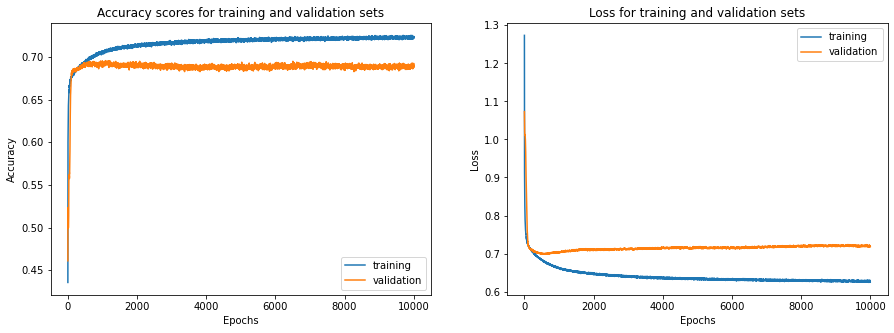

In [499]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Accuracy scores for training and validation sets')
plt.plot(history.history["sparse_categorical_accuracy"], label="training")
plt.plot(history.history["val_sparse_categorical_accuracy"], label="validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss for training and validation sets')
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [500]:
NN_score = round(model.evaluate(X_test_scaled,y_test, verbose=0)[1]*100,2)

print(f'The accuracy score on test set is: {NN_score}%')

The accuracy score on test set is: 68.1%


In [501]:
model.evaluate(X_test_scaled,y_test, verbose=0)[1]

NN_y_pred = model.predict_classes(X_test_scaled)
report_initial = classification_report(y_test, NN_y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      2185
           1       0.56      0.41      0.47      3277
           2       0.73      0.83      0.77      5462

    accuracy                           0.68     10924
   macro avg       0.66      0.65      0.65     10924
weighted avg       0.67      0.68      0.67     10924



From the above modeling and evaluation


- The final accuracy score is `68.1%`


- Model performed well on delivery window `0` and `2` but bad on `1`, with a recall of 41%


- It was expected to recognize the underlying patterns in the data but after several iterations the `accuracy was always stuck at ~69% accuracy on validation set`. 



- `Neural network` performed slightly less than the `Random Forest` Model, overall `XGBoost` is still the best model

--- 
# Summary

**bringing it all together**

Visually representing all the accuracy scores for all models

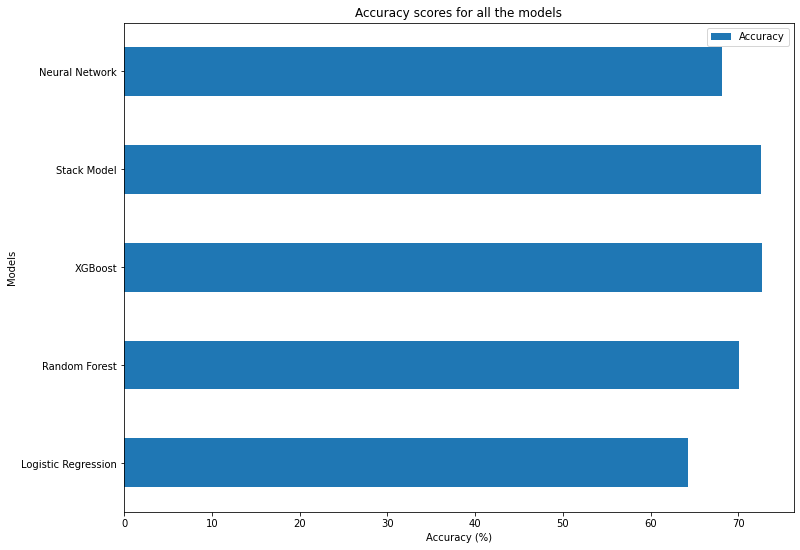

In [521]:

pd.DataFrame({'Accuracy':[log_score,random_score,XGB_score,stacked_score,NN_score]},
             index=['Logistic Regression','Random Forest',
                    'XGBoost','Stack Model','Neural Network']).plot(kind='barh',figsize=(12,9))

plt.title('Accuracy scores for all the models')
plt.ylabel('Models')
plt.xlabel('Accuracy (%)')
plt.show()

`XGBoost` is the best model with 72% accuracy 

### Summary

This concludes the section for `Feature Engineering` and `Modeling`, in this section the following was achieved:


**Feature Engineering**

- Features in the categories of `customers` (distance, state category, same state orders), `orders` (product size and weight) and `external factors` (Holidays) were added to the data set

- Imbalance in data set for some features such as `product_weight_g`,`price`,`freight value` `product_volume_cm3` and `distance` were adequately addressed.


- The target variable was divided into 3 delivery windows for better modeling `less than 3-days`,`3-7 days` and `over 7 days`


**Modeling**

- Base model was a `Logistic Regression` and was hypertuned with a test accuracy of `~64%`, but performs woefully in classifying `3-7 days` delivery window. This was investgated and no tangible pattern was found in this category.


- `Pycaret` was used in the model selection process, `Random Forest` and `Gradient Boosting` models(XGBoost) perfoms well on the data.


- `Random Forest` and `XGBoost` had a test accuracy of `~70%` and `~73%` respectively and XGBoost classified the `3-7 days` delivery window much better with recall of `53%`


- `Neural Network` was tuned using optuna, but didn't perform well on the data, with a accuracy of `68%` and recall of `41%` on the `3-7 days` delivery window. model appaers to be stuck at `~69% accuracy on validation set` for any of the designed NN architecture.


- Overall `XGBoost` is the best model with `~73%` accuracy


**In the Next Section:** 


- The Final model will be contructed using the data available now


- Summary of findings will be discussed 


- Next steps